Time taken:  0.00031566619873046875


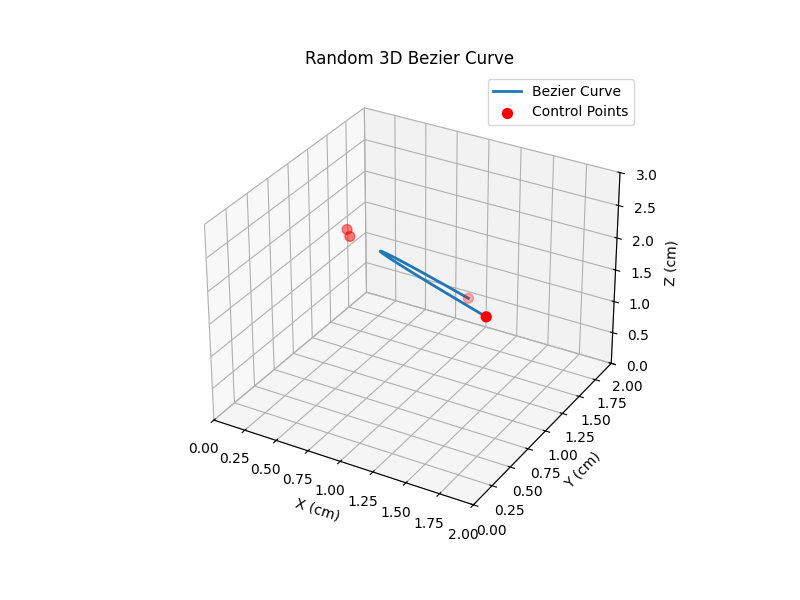

In [52]:
%matplotlib widget
import numpy as np
from scipy.special import comb
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Not needed in newer versions of matplotlib

class BoundedBezierCurve3D:
    def __init__(self, control_points=None):
        """
        Initialize the Bezier curve. If no control points are provided,
        the curve can be sampled randomly using sample_random_curve().
        """
        self.bounds = {
            'x': (0, 2),  # 2cm bound in x
            'y': (0, 2),  # 2cm bound in y
            'z': (0, 3)   # 3cm bound in z
        }
        if control_points is None:
            self.control_points = np.empty((0, 3))
        else:
            self.control_points = self.enforce_bounds(np.array(control_points))
    
    def enforce_bounds(self, points):
        """Clip the points so that they lie within the defined bounds."""
        points[:, 0] = np.clip(points[:, 0], self.bounds['x'][0], self.bounds['x'][1])
        points[:, 1] = np.clip(points[:, 1], self.bounds['y'][0], self.bounds['y'][1])
        points[:, 2] = np.clip(points[:, 2], self.bounds['z'][0], self.bounds['z'][1])
        return points
        
    def generate_curve(self, num_points=100):
        """
        Generate points along the Bezier curve using a vectorized Bernstein basis.
        
        Args:
            num_points: Number of points along the curve
            
        Returns:
            An array of shape (num_points, 3) representing the curve.
        """
        n = len(self.control_points) - 1
        t = np.linspace(0, 1, num_points)
        
        # Create a grid for vectorized computation of Bernstein basis
        i = np.arange(n + 1)[:, None]  # shape (n+1, 1)
        t = t[None, :]                 # shape (1, num_points)
        binom_coeffs = comb(n, i)        # shape (n+1, 1)
        
        bernstein_matrix = binom_coeffs * (t ** i) * ((1 - t) ** (n - i))
        # Dot product with control points (shape (n+1, 3)) to get the curve (shape (num_points, 3))
        curve = bernstein_matrix.T.dot(self.control_points)
        
        return self.enforce_bounds(curve)
        
    def add_control_point(self, point):
        """Add a new control point (ensuring it is within bounds)."""
        point = np.array(point)
        point = self.enforce_bounds(point.reshape(1, 3)).flatten()
        self.control_points = np.vstack([self.control_points, point])
        
    def modify_control_point(self, index, new_point):
        """Modify an existing control point (ensuring it is within bounds)."""
        if 0 <= index < len(self.control_points):
            new_point = np.array(new_point)
            new_point = self.enforce_bounds(new_point.reshape(1, 3)).flatten()
            self.control_points[index] = new_point
            
    def get_curve_length(self, num_points=1000):
        """Calculate the approximate length of the curve."""
        points = self.generate_curve(num_points)
        segments = np.diff(points, axis=0)
        lengths = np.sqrt(np.sum(segments**2, axis=1))
        return np.sum(lengths)
        
    def sample_random_curve(self, num_control_points=4, num_points=100):
        """
        Generate a random Bezier curve by sampling random control points within bounds.
        
        Args:
            num_control_points: Number of control points to generate (degree = num_control_points - 1)
            num_points: Number of points along the resulting curve
            
        Returns:
            The generated curve as an array of shape (num_points, 3).
        """
        cp_x = np.random.uniform(self.bounds['x'][0], self.bounds['x'][1], size=num_control_points)
        cp_y = np.random.uniform(self.bounds['y'][0], self.bounds['y'][1], size=num_control_points)
        cp_z = np.random.uniform(self.bounds['z'][0], self.bounds['z'][1], size=num_control_points)
        cp = np.column_stack((cp_x, cp_y, cp_z))
        self.control_points = cp
        return self.generate_curve(num_points)


# -------------------------------
# Visualization (e.g., in a Jupyter Notebook)
# -------------------------------

# Create an instance without predefined control points
bezier = BoundedBezierCurve3D()

# Sample a random Bezier curve with 4 control points and 100 points along the curve

import time
now = time.time()
curve_points = bezier.sample_random_curve(num_control_points=4, num_points=100)
print("Time taken: ", time.time() - now)

# Create a 3D plot of the curve and control points
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the Bezier curve
ax.plot(curve_points[:, 0], curve_points[:, 1], curve_points[:, 2], label="Bezier Curve", lw=2)

# Plot the control points (in red)
ax.scatter(bezier.control_points[:, 0], bezier.control_points[:, 1],
           bezier.control_points[:, 2], color='red', s=50, label="Control Points")

# Set axis limits based on the bounds
ax.set_xlim(bezier.bounds['x'])
ax.set_ylim(bezier.bounds['y'])
ax.set_zlim(bezier.bounds['z'])

ax.set_title("Random 3D Bezier Curve")
ax.set_xlabel("X (cm)")
ax.set_ylabel("Y (cm)")
ax.set_zlabel("Z (cm)")
ax.legend()
plt.show()


Time to reset: 0.00012135505676269531


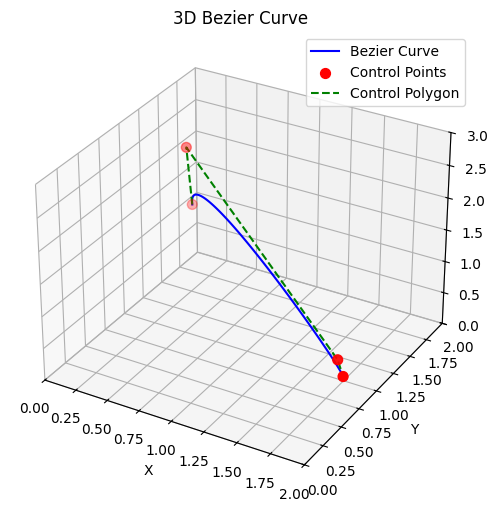

In [59]:
%matplotlib inline
import numpy as np
from scipy.special import comb
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class BoundedBezierCurve3D:
    def __init__(self, num_control_points=4):
        """
        Initialize a bounded 3D Bezier curve with random control points.
        
        Args:
            num_control_points: Number of control points for the Bezier curve.
        """
        self.bounds = {
            'x': (0, 2),  # 2cm bound in x
            'y': (0, 2),  # 2cm bound in y
            'z': (0, 3)   # 3cm bound in z
        }
        self.num_control_points = num_control_points

    def reset(self):
        """Reset the curve with random control points within bounds."""
        self.control_points = np.random.uniform(
            low=[self.bounds['x'][0], self.bounds['y'][0], self.bounds['z'][0]],
            high=[self.bounds['x'][1], self.bounds['y'][1], self.bounds['z'][1]],
            size=(self.num_control_points, 3)
        )
        self._update_binomial()

    def _update_binomial(self):
        """Update binomial coefficients when control points change."""
        self.n = len(self.control_points) - 1
        if self.n >= 0:
            self.binomial = comb(self.n, np.arange(self.n + 1))
        else:
            self.binomial = np.array([])

    def generate_curve(self, num_points=100):
        """Generate points along the Bezier curve."""
        if len(self.control_points) == 0:
            return np.zeros((0, 3))
        
        t = np.linspace(0, 1, num_points)
        i = np.arange(self.n + 1)[:, np.newaxis]
        
        # Vectorized Bernstein polynomial calculation
        t_powers = t ** i
        one_minus_t_powers = (1 - t) ** (self.n - i)
        B = self.binomial[:, np.newaxis] * t_powers * one_minus_t_powers
        
        # Matrix multiplication for curve points
        curve = B.T @ self.control_points
        return curve

    def get_curve_length(self, num_points=1000):
        """Approximate curve length using vectorized operations."""
        points = self.generate_curve(num_points)
        return np.sum(np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1)))

    def plot_curve(self, num_points=100):
        """Visualize the 3D Bezier curve using matplotlib."""
        curve = self.generate_curve(num_points)
        
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        
        # Plot the curve
        ax.plot(curve[:, 0], curve[:, 1], curve[:, 2], label='Bezier Curve', color='b')
        
        # Plot control points
        ax.scatter(self.control_points[:, 0], self.control_points[:, 1], self.control_points[:, 2],
                   color='r', label='Control Points', s=50)
        
        # Draw lines connecting control points
        ax.plot(self.control_points[:, 0], self.control_points[:, 1], self.control_points[:, 2],
                color='g', linestyle='--', label='Control Polygon')
        
        # Set axis labels and limits
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_xlim(self.bounds['x'])
        ax.set_ylim(self.bounds['y'])
        ax.set_zlim(self.bounds['z'])
        
        ax.legend()
        plt.title('3D Bezier Curve')
        plt.show()

# Example usage in Jupyter Notebook
if __name__ == "__main__":
    # Create a random Bezier curve
    bezier = BoundedBezierCurve3D(num_control_points=4)
    
    # Reset and generate a new random curve
    import time
    now = time.time()
    bezier.reset()
    print("Time to reset:", time.time() - now)
    bezier.plot_curve()

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Define the beta schedule function
def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    if schedule_name == "linear":
        scale = 1000 / num_diffusion_timesteps
        betas = np.linspace(scale * 0.0001, scale * 0.02, num_diffusion_timesteps, dtype=np.float64)
        return np.array(betas, dtype=np.float64)
    elif schedule_name == "squaredcos_cap_v2":
        return betas_for_alpha_bar(
            num_diffusion_timesteps,
            lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
        )
    else:
        raise NotImplementedError(f"unknown beta schedule: {schedule_name}")

# Define the alpha_bar function for squaredcos_cap_v2
def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return np.array(betas, dtype=np.float64)

# Define the diffusion parameters
num_diffusion_timesteps = 1000
beta_schedule = "linear"  # or "squaredcos_cap_v2"

# Compute betas and other related terms
betas = get_named_beta_schedule(beta_schedule, num_diffusion_timesteps)
alphas = 1.0 - betas
alphas_cumprod = np.cumprod(alphas, axis=0)
alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])
alphas_cumprod_next = np.append(alphas_cumprod[1:], 0.0)

# Compute posterior variance
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)

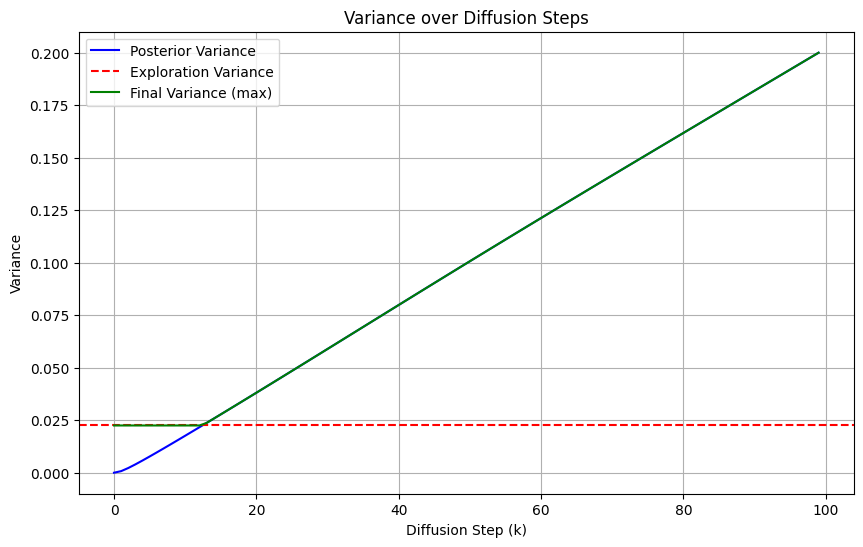

In [8]:
# Define exploration noise variance (var_explore)
var_explore = 0.0225# Example value, adjust as needed

# Compute the final variance
final_variance = np.maximum(posterior_variance, var_explore)

# Plot posterior_variance, var_explore, and final_variance
plt.figure(figsize=(10, 6))
plt.plot(posterior_variance, label="Posterior Variance", color="blue")
plt.axhline(y=var_explore, color="red", linestyle="--", label="Exploration Variance")
plt.plot(final_variance, label="Final Variance (max)", color="green")
plt.xlabel("Diffusion Step (k)")
plt.ylabel("Variance")
plt.title("Variance over Diffusion Steps")
plt.grid(True)
plt.legend()
plt.show()

/tmp/ipykernel_17394/2157795119.py:32: RuntimeWarning: invalid value encountered in sqrt
  sqrt_alphas_cumprod = np.sqrt(alphas_cumprod)
/tmp/ipykernel_17394/2157795119.py:34: RuntimeWarning: invalid value encountered in sqrt
  sqrt_recip_alphas = np.sqrt(1.0 / alphas)


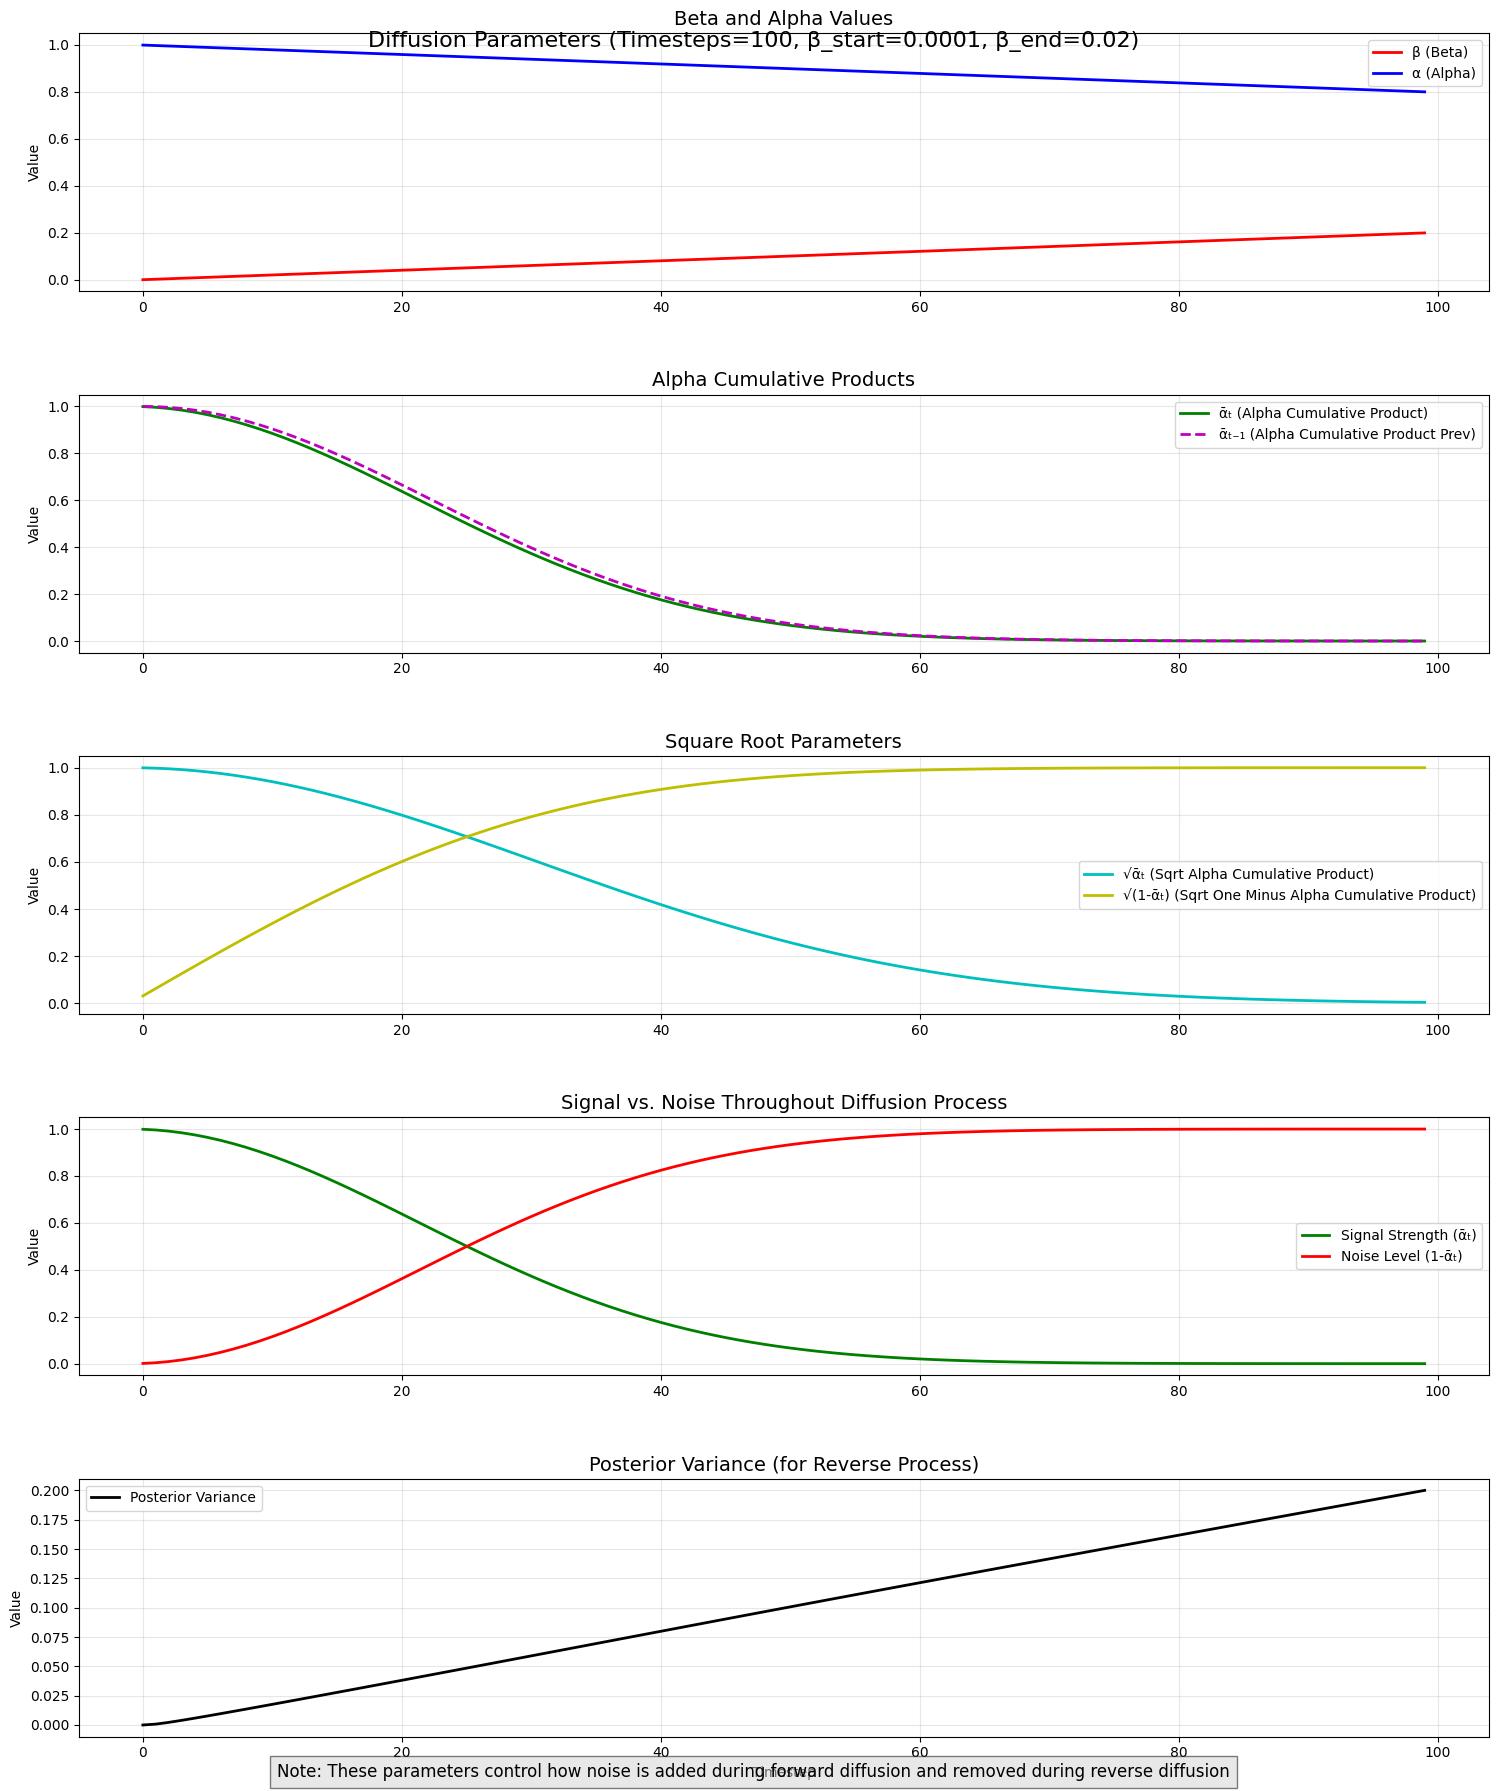

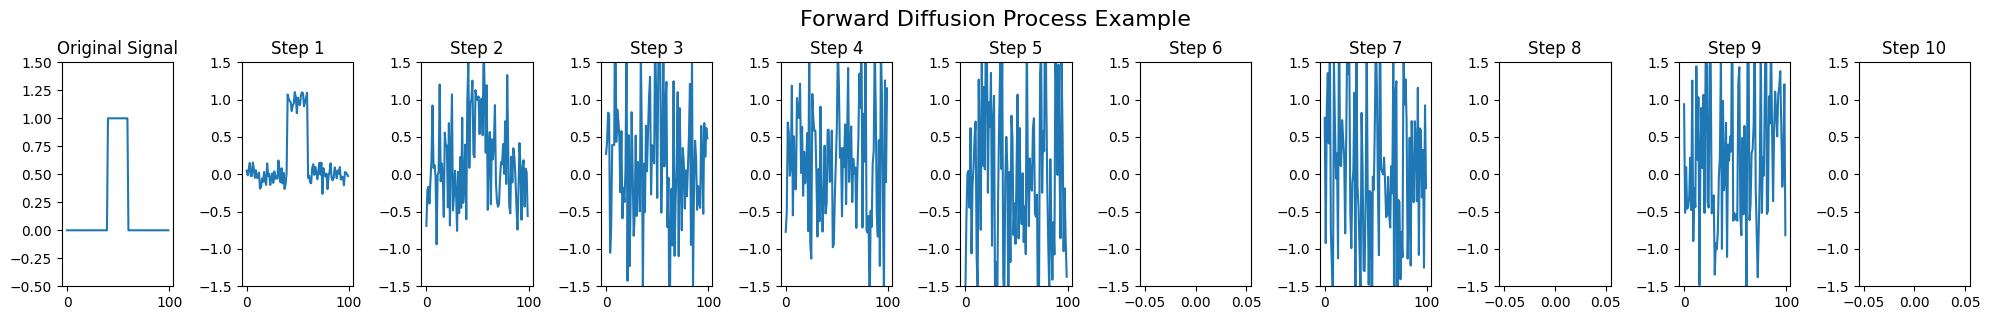

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def compute_diffusion_parameters(num_diffusion_timesteps=1000, beta_start=0.0001, beta_end=0.02):
    """
    Compute diffusion model parameters.
    
    Args:
        num_diffusion_timesteps: Number of steps in the diffusion process
        beta_start: Starting beta value
        beta_end: Ending beta value
        
    Returns:
        Dict of diffusion parameters
    """
    # Scale values
    scale = 1000 / num_diffusion_timesteps
    
    # Create beta schedule (amount of noise added at each step)
    betas = np.linspace(scale * beta_start, scale * beta_end, num_diffusion_timesteps, dtype=np.float64)
    
    # Calculate alphas (portion of original signal preserved at each step)
    alphas = 1.0 - betas
    
    # Calculate cumulative products
    alphas_cumprod = np.cumprod(alphas, axis=0)
    alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])
    alphas_cumprod_next = np.append(alphas_cumprod[1:], 0.0)
    
    # Calculate square roots (used in the diffusion equations)
    sqrt_alphas_cumprod = np.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = np.sqrt(1.0 - alphas_cumprod)
    sqrt_recip_alphas = np.sqrt(1.0 / alphas)
    
    # Calculate posterior variances (used in the reverse process)
    posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
    posterior_log_variance_clipped = np.log(np.append(posterior_variance[1], posterior_variance[1:]))
    
    return {
        "timesteps": np.arange(num_diffusion_timesteps),
        "betas": betas,
        "alphas": alphas,
        "alphas_cumprod": alphas_cumprod,
        "alphas_cumprod_prev": alphas_cumprod_prev,
        "alphas_cumprod_next": alphas_cumprod_next,
        "sqrt_alphas_cumprod": sqrt_alphas_cumprod,
        "sqrt_one_minus_alphas_cumprod": sqrt_one_minus_alphas_cumprod,
        "sqrt_recip_alphas": sqrt_recip_alphas,
        "posterior_variance": posterior_variance,
        "posterior_log_variance_clipped": posterior_log_variance_clipped
    }

def visualize_diffusion_parameters(params, figure_size=(15, 18), sample_points=None):
    """
    Visualize diffusion parameters.
    
    Args:
        params: Dict of diffusion parameters
        figure_size: Size of the figure (width, height)
        sample_points: Sample specific timesteps (useful for larger timesteps)
    """
    if sample_points is not None:
        # Sample specific points
        indices = np.linspace(0, len(params["timesteps"]) - 1, sample_points).astype(int)
        for key in params:
            if key != "timesteps" and isinstance(params[key], np.ndarray) and len(params[key]) > 0:
                params[key] = params[key][indices]
        params["timesteps"] = params["timesteps"][indices]
    
    # Create figure with subplots
    fig = plt.figure(figsize=figure_size)
    gs = gridspec.GridSpec(5, 1, height_ratios=[1, 1, 1, 1, 1])
    
    # Subplot 1: Betas and Alphas
    ax1 = plt.subplot(gs[0])
    ax1.plot(params["timesteps"], params["betas"], 'r-', label='β (Beta)', linewidth=2)
    ax1.plot(params["timesteps"], params["alphas"], 'b-', label='α (Alpha)', linewidth=2)
    ax1.set_title('Beta and Alpha Values', fontsize=14)
    ax1.set_ylabel('Value')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Subplot 2: Alpha Cumulative Products
    ax2 = plt.subplot(gs[1])
    ax2.plot(params["timesteps"], params["alphas_cumprod"], 'g-', 
             label='ᾱₜ (Alpha Cumulative Product)', linewidth=2)
    ax2.plot(params["timesteps"], params["alphas_cumprod_prev"], 'm--', 
             label='ᾱₜ₋₁ (Alpha Cumulative Product Prev)', linewidth=2)
    ax2.set_title('Alpha Cumulative Products', fontsize=14)
    ax2.set_ylabel('Value')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Subplot 3: Square Roots
    ax3 = plt.subplot(gs[2])
    ax3.plot(params["timesteps"], params["sqrt_alphas_cumprod"], 'c-', 
             label='√ᾱₜ (Sqrt Alpha Cumulative Product)', linewidth=2)
    ax3.plot(params["timesteps"], params["sqrt_one_minus_alphas_cumprod"], 'y-', 
             label='√(1-ᾱₜ) (Sqrt One Minus Alpha Cumulative Product)', linewidth=2)
    ax3.set_title('Square Root Parameters', fontsize=14)
    ax3.set_ylabel('Value')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    # Subplot 4: Signal and Noise Curves
    ax4 = plt.subplot(gs[3])
    signal_strength = params["alphas_cumprod"]
    noise_level = 1.0 - params["alphas_cumprod"]
    ax4.plot(params["timesteps"], signal_strength, 'g-', label='Signal Strength (ᾱₜ)', linewidth=2)
    ax4.plot(params["timesteps"], noise_level, 'r-', label='Noise Level (1-ᾱₜ)', linewidth=2)
    ax4.set_title('Signal vs. Noise Throughout Diffusion Process', fontsize=14)
    ax4.set_ylabel('Value')
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    # Subplot 5: Posterior Variance
    ax5 = plt.subplot(gs[4])
    ax5.plot(params["timesteps"], params["posterior_variance"], 'k-', 
             label='Posterior Variance', linewidth=2)
    ax5.set_title('Posterior Variance (for Reverse Process)', fontsize=14)
    ax5.set_xlabel('Timestep')
    ax5.set_ylabel('Value')
    ax5.grid(True, alpha=0.3)
    ax5.legend()
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4)
    
    # Add annotations
    plt.figtext(0.5, 0.01, 'Note: These parameters control how noise is added during forward diffusion and removed during reverse diffusion', 
                ha='center', fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
    
    return fig

def sample_diffusion_process(num_steps=10):
    """
    Visualize what happens to an image during the diffusion process
    using a simple 1D signal.
    
    Args:
        num_steps: Number of diffusion steps to visualize
    """
    # Original signal (simulating an image pixel row)
    x0 = np.zeros(100)
    x0[40:60] = 1.0  # A simple square signal
    
    # Compute diffusion parameters
    params = compute_diffusion_parameters(num_diffusion_timesteps=num_steps)
    
    # Create the figure
    fig, axes = plt.subplots(1, num_steps+1, figsize=(20, 3))
    
    # Plot original signal
    axes[0].plot(x0)
    axes[0].set_title('Original Signal')
    axes[0].set_ylim(-0.5, 1.5)
    
    # Plot each timestep
    np.random.seed(42)  # For reproducibility
    xt = x0.copy()
    
    for t in range(num_steps):
        # Generate noise
        noise = np.random.normal(size=xt.shape)
        
        # Apply diffusion step
        xt = params["sqrt_alphas_cumprod"][t] * x0 + params["sqrt_one_minus_alphas_cumprod"][t] * noise
        
        # Plot
        axes[t+1].plot(xt)
        axes[t+1].set_title(f'Step {t+1}')
        axes[t+1].set_ylim(-1.5, 1.5)
    
    plt.tight_layout()
    return fig

# Example usage
if __name__ == "__main__":
    # Set parameters
    num_timesteps = 100
    beta_start = 0.0001
    beta_end = 0.02
    
    # Compute parameters
    params = compute_diffusion_parameters(
        num_diffusion_timesteps=num_timesteps,
        beta_start=beta_start,
        beta_end=beta_end
    )
    
    # Create visualization with sampled points for clarity
    fig1 = visualize_diffusion_parameters(params, sample_points=100)
    fig1.suptitle(f'Diffusion Parameters (Timesteps={num_timesteps}, β_start={beta_start}, β_end={beta_end})', 
                 fontsize=16, y=0.98)
    plt.savefig('diffusion_parameters.png', dpi=300, bbox_inches='tight')
    
    # Visualize diffusion process on a simple signal
    fig2 = sample_diffusion_process(num_steps=10)
    fig2.suptitle('Forward Diffusion Process Example', fontsize=16, y=1.05)
    plt.savefig('diffusion_process.png', dpi=300, bbox_inches='tight')
    
    # Show plots
    plt.show()

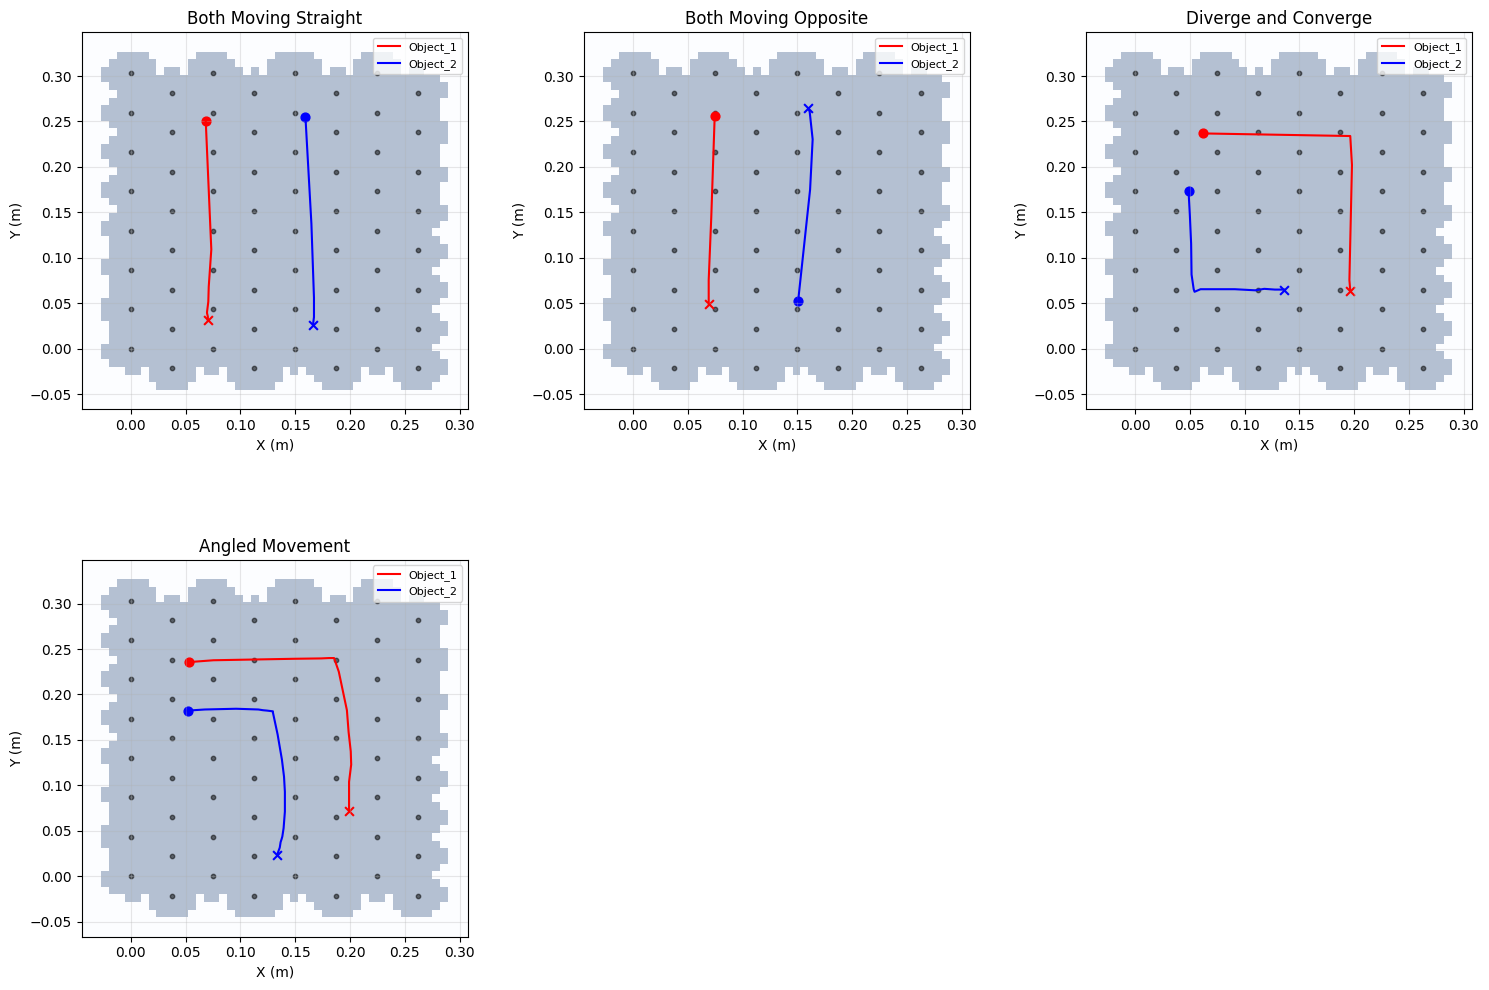

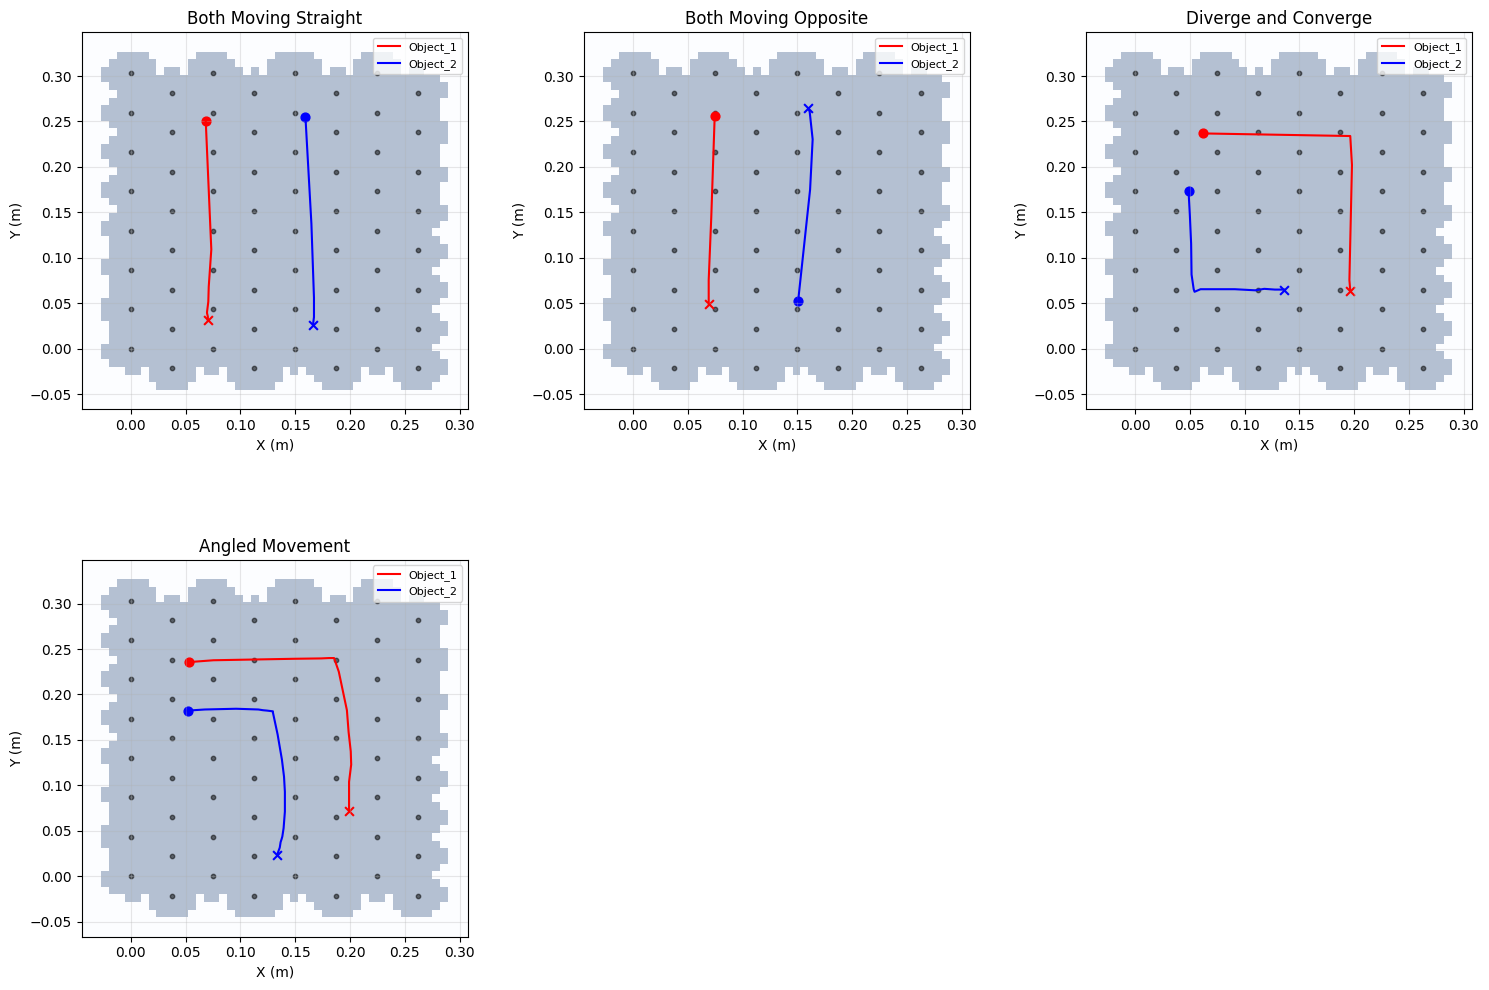

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import pickle
from scipy.spatial import KDTree

# Load the pickle file
def load_trajectory_data(file_path="delta_array_trajectories.pkl"):
    """Load trajectory data from pickle file"""
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

# Display basic information about the trajectories
def show_trajectory_info(data):
    """Display information about the loaded trajectories"""
    # Handle both old and new data formats
    if 'trajectory_sets' in data:
        # New format with multiple named trajectory sets
        info_rows = []
        
        # Add overall info
        info_rows.append(("Number of Trajectory Sets", len(data['trajectory_sets'])))
        
        # Add details for each set
        for traj_name, objects in data['trajectory_sets'].items():
            info_rows.append((f"Set: {traj_name}", f"{len(objects)} objects"))
            
            for obj_id, traj in objects.items():
                point_count = len(traj) if traj is not None else 0
                info_rows.append((f"  - {obj_id}", f"{point_count} points"))
        
        # Add grid info
        info_rows.append(("Grid Points", len(data['grid_points']) if data['grid_points'] is not None else 0))
        info_rows.append(("Grid Size", f"{data['grid_size']}x{data['grid_size']}"))
        
        # Add system info
        info_rows.append(("Number of Delta Robots", len(data['robot_positions']) if 'robot_positions' in data else "Unknown"))
        info_rows.append(("Workspace Radius", f"{data['workspace_radius']*100:.1f} cm" if 'workspace_radius' in data else "Unknown"))
        info_rows.append(("X Workspace Range", f"{data['workspace_bounds']['min_x']:.4f} to {data['workspace_bounds']['max_x']:.4f} m" if 'workspace_bounds' in data else "Unknown"))
        info_rows.append(("Y Workspace Range", f"{data['workspace_bounds']['min_y']:.4f} to {data['workspace_bounds']['max_y']:.4f} m" if 'workspace_bounds' in data else "Unknown"))
        
        # Add metadata
        if 'metadata' in data:
            info_rows.append(("Units", data['metadata']['units'] if 'units' in data['metadata'] else "Unknown"))
            info_rows.append(("Date Created", data['metadata']['date_created'] if 'date_created' in data['metadata'] else "Unknown"))
    else:
        # Old format with just trajectory1/trajectory2
        info_rows = [
            ("Trajectory 1 Points", len(data['trajectory1']) if data['trajectory1'] is not None else 0),
            ("Trajectory 2 Points", len(data['trajectory2']) if data['trajectory2'] is not None else 0),
            ("Grid Points", len(data['grid_points']) if data['grid_points'] is not None else 0),
            ("Grid Size", f"{data['grid_size']}x{data['grid_size']}"),
        ]
        
        if 'robot_positions' in data:
            info_rows.extend([
                ("Number of Delta Robots", len(data['robot_positions'])),
                ("Workspace Radius", f"{data['workspace_radius']*100:.1f} cm" if 'workspace_radius' in data else "Unknown"),
            ])
            
        if 'workspace_bounds' in data:
            info_rows.extend([
                ("X Workspace Range", f"{data['workspace_bounds']['min_x']:.4f} to {data['workspace_bounds']['max_x']:.4f} m"),
                ("Y Workspace Range", f"{data['workspace_bounds']['min_y']:.4f} to {data['workspace_bounds']['max_y']:.4f} m"),
            ])
            
        if 'metadata' in data:
            info_rows.extend([
                ("Units", data['metadata']['units'] if 'units' in data['metadata'] else "Unknown"),
                ("Date Created", data['metadata']['date_created'] if 'date_created' in data['metadata'] else "Unknown"),
            ])
    
    return pd.DataFrame(info_rows, columns=["Property", "Value"])

# List available trajectory sets
def list_trajectory_sets(data):
    """List all available trajectory sets in the data file"""
    if 'trajectory_sets' in data:
        sets = list(data['trajectory_sets'].keys())
        if not sets:
            print("No trajectory sets found in data file.")
        else:
            print(f"Available trajectory sets ({len(sets)}):")
            for i, set_name in enumerate(sets):
                objects = data['trajectory_sets'][set_name]
                print(f"{i+1}. {set_name} - {len(objects)} objects")
                for obj_id, traj in objects.items():
                    points = len(traj) if traj is not None else 0
                    print(f"   - {obj_id}: {points} points")
    else:
        print("Data file uses old format with fixed trajectory1/trajectory2 objects.")
        print("trajectory1:", "Present" if data['trajectory1'] is not None else "Not present")
        print("trajectory2:", "Present" if data['trajectory2'] is not None else "Not present")

# Basic static visualization of trajectories
def visualize_trajectories(data, trajectory_set=None, figsize=(10, 8)):
    """Create a static visualization of the trajectories and grid points"""
    fig, ax = plt.subplots(figsize=figsize)
    
    # Get workspace bounds if available
    if 'workspace_bounds' in data:
        bounds = data['workspace_bounds']
        min_x, max_x = bounds['min_x'], bounds['max_x']
        min_y, max_y = bounds['min_y'], bounds['max_y']
    else:
        # Use defaults that would work with the old data format
        min_x, max_x = 0, 0.3
        min_y, max_y = 0, 0.3
    
    # Add delta robot positions and workspace circles if available
    if 'robot_positions' in data and 'workspace_radius' in data:
        # Create workspace visualization
        robot_positions = data['robot_positions']
        workspace_radius = data['workspace_radius']
        
        # Create grid to map workspace coverage
        resolution = 100
        xx, yy = np.meshgrid(
            np.linspace(min_x, max_x, resolution),
            np.linspace(min_y, max_y, resolution)
        )
        zz = np.zeros_like(xx, dtype=bool)
        
        # Create KDTree for efficient nearest-neighbor lookup
        robot_kdtree = KDTree(robot_positions)
        
        # Mark points within workspace
        for i in range(xx.shape[0]):
            for j in range(xx.shape[1]):
                pt = np.array([xx[i, j], yy[i, j]])
                distance, _ = robot_kdtree.query(pt, k=1)
                zz[i, j] = distance <= workspace_radius
        
        # Plot the workspace as a colored area
        ax.pcolormesh(xx, yy, zz, cmap='Blues', alpha=0.3, shading='auto')
        
        # Plot all delta robot positions
        ax.scatter(
            robot_positions[:, 0],
            robot_positions[:, 1],
            color='black', s=20, marker='o', label='Delta Robots'
        )
        
        # Add workspace circles for each delta robot (show just a few to avoid clutter)
        for pos in robot_positions[::4]:  # Plot every 4th robot to reduce clutter
            circle = patches.Circle(
                pos, workspace_radius, 
                fill=False, color='gray', linestyle='-', alpha=0.2
            )
            ax.add_patch(circle)
    else:
        # Fallback to old-style visualization
        ax.add_patch(plt.Rectangle((min_x, min_y), max_x-min_x, max_y-min_y, 
                                 fill=False, color='gray', linestyle='--'))
    
    # Define a set of colors for different objects
    colors = ['r', 'b', 'g', 'c', 'm', 'y', 'orange', 'purple', 'brown', 'pink']
    
    # Plot trajectories based on data format
    if 'trajectory_sets' in data:
        # New format with multiple named trajectory sets
        if trajectory_set is None:
            # If no specific set is selected, plot the first one
            if data['trajectory_sets']:
                trajectory_set = list(data['trajectory_sets'].keys())[0]
            else:
                trajectory_set = None
        
        if trajectory_set and trajectory_set in data['trajectory_sets']:
            # Set the title to the trajectory set name
            ax.set_title(f'Trajectory Set: {trajectory_set}', fontsize=16)
            
            # Plot each object in the set
            for i, (obj_id, traj) in enumerate(data['trajectory_sets'][trajectory_set].items()):
                if traj is not None and len(traj) > 0:
                    color = colors[i % len(colors)]
                    ax.plot(traj[:, 0], traj[:, 1], color=color, linewidth=2, label=f'{obj_id}')
                    ax.scatter(traj[0, 0], traj[0, 1], color=color, marker='o', s=80, edgecolor='black')
                    ax.scatter(traj[-1, 0], traj[-1, 1], color=color, marker='x', s=80, edgecolor='black')
        else:
            ax.set_title('No Trajectory Set Selected', fontsize=16)
    else:
        # Old format with just trajectory1/trajectory2
        ax.set_title('Delta Array Trajectory Visualization', fontsize=16)
        
        # Plot trajectory 1 if it exists
        if data['trajectory1'] is not None and len(data['trajectory1']) > 0:
            traj1 = data['trajectory1']
            ax.plot(traj1[:, 0], traj1[:, 1], 'r-', linewidth=2, label='Object 1')
            ax.scatter(traj1[0, 0], traj1[0, 1], color='r', marker='o', s=80, edgecolor='black')
            ax.scatter(traj1[-1, 0], traj1[-1, 1], color='r', marker='x', s=80, edgecolor='black')
        
        # Plot trajectory 2 if it exists
        if data['trajectory2'] is not None and len(data['trajectory2']) > 0:
            traj2 = data['trajectory2']
            ax.plot(traj2[:, 0], traj2[:, 1], 'b-', linewidth=2, label='Object 2')
            ax.scatter(traj2[0, 0], traj2[0, 1], color='b', marker='o', s=80, edgecolor='black')
            ax.scatter(traj2[-1, 0], traj2[-1, 1], color='b', marker='x', s=80, edgecolor='black')
    
    # Plot grid points if they exist
    if data['grid_points'] is not None and len(data['grid_points']) > 0:
        grid = data['grid_points']
        ax.scatter(grid[:, 0], grid[:, 1], color='g', marker='.', s=30, alpha=0.5, label='Grid Points')
    
    # Set axis limits
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)
    
    ax.set_xlabel('X Position (m)', fontsize=12)
    ax.set_ylabel('Y Position (m)', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)
    
    plt.tight_layout()
    return fig

# Visualize all trajectory sets in a grid
def visualize_all_trajectory_sets(data, figsize=(15, 10)):
    """Create a grid of visualizations for all trajectory sets"""
    if 'trajectory_sets' not in data or not data['trajectory_sets']:
        print("No trajectory sets found in data file.")
        return None
    
    trajectory_sets = data['trajectory_sets']
    num_sets = len(trajectory_sets)
    
    # Calculate grid dimensions based on number of sets
    if num_sets <= 3:
        rows, cols = 1, num_sets
    else:
        cols = min(3, num_sets)  # Maximum 3 columns
        rows = (num_sets + cols - 1) // cols  # Ceiling division
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    # Ensure axes is always an array we can iterate over, even for a single subplot
    axes_flat = np.atleast_1d(axes)
    if axes_flat.ndim > 1:
        axes_flat = axes_flat.flatten()
    
    # Get workspace bounds and robot data
    if 'workspace_bounds' in data:
        bounds = data['workspace_bounds']
        min_x, max_x = bounds['min_x'], bounds['max_x']
        min_y, max_y = bounds['min_y'], bounds['max_y']
    else:
        min_x, max_x = 0, 0.3
        min_y, max_y = 0, 0.3
    
    # Create workspace visualization data
    if 'robot_positions' in data and 'workspace_radius' in data:
        robot_positions = data['robot_positions']
        workspace_radius = data['workspace_radius']
        
        # Create grid to map workspace coverage
        resolution = 50  # Lower resolution for speed in multi-plot
        xx, yy = np.meshgrid(
            np.linspace(min_x, max_x, resolution),
            np.linspace(min_y, max_y, resolution)
        )
        zz = np.zeros_like(xx, dtype=bool)
        
        # Create KDTree for efficient nearest-neighbor lookup
        robot_kdtree = KDTree(robot_positions)
        
        # Mark points within workspace
        for i in range(xx.shape[0]):
            for j in range(xx.shape[1]):
                pt = np.array([xx[i, j], yy[i, j]])
                distance, _ = robot_kdtree.query(pt, k=1)
                zz[i, j] = distance <= workspace_radius
    
    # Define a set of colors for different objects
    colors = ['r', 'b', 'g', 'c', 'm', 'y', 'orange', 'purple', 'brown', 'pink']
    
    # Plot each trajectory set
    for i, (traj_name, objects) in enumerate(trajectory_sets.items()):
        if i >= len(axes_flat):
            break  # Safety check
            
        ax = axes_flat[i]
        
        # Set up the plot
        ax.set_xlim(min_x, max_x)
        ax.set_ylim(min_y, max_y)
        ax.set_title(traj_name, fontsize=12)
        ax.set_xlabel('X (m)', fontsize=10)
        ax.set_ylabel('Y (m)', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # Plot workspace if available
        if 'robot_positions' in data and 'workspace_radius' in data:
            ax.pcolormesh(xx, yy, zz, cmap='Blues', alpha=0.3, shading='auto')
            
            # Plot robot positions
            ax.scatter(
                robot_positions[:, 0], 
                robot_positions[:, 1],
                color='black', s=10, marker='o', alpha=0.5
            )
        
        # Plot each object in the set
        for j, (obj_id, traj) in enumerate(objects.items()):
            if traj is not None and len(traj) > 0:
                color = colors[j % len(colors)]
                ax.plot(traj[:, 0], traj[:, 1], color=color, linewidth=1.5, label=obj_id)
                ax.scatter(traj[0, 0], traj[0, 1], color=color, marker='o', s=40)
                ax.scatter(traj[-1, 0], traj[-1, 1], color=color, marker='x', s=40)
        
        ax.legend(fontsize=8, loc='upper right')
    
    # Hide any unused subplots
    for i in range(len(trajectory_sets), len(axes_flat)):
        axes_flat[i].axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3, hspace=0.4)
    
    return fig

# Calculate and visualize trajectory metrics
def analyze_trajectories(data, trajectory_set=None, object_id=None):
    """Calculate and visualize metrics for the trajectories"""
    metrics = {}
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # First, determine which trajectories to analyze based on the data format
    trajectories_to_analyze = {}
    
    if 'trajectory_sets' in data:
        # New format with multiple named trajectory sets
        if trajectory_set is None:
            # If no specific set is selected, use the first one
            if data['trajectory_sets']:
                trajectory_set = list(data['trajectory_sets'].keys())[0]
            else:
                print("No trajectory sets found in data")
                return None, None
                
        if trajectory_set in data['trajectory_sets']:
            if object_id is not None and object_id in data['trajectory_sets'][trajectory_set]:
                # Analyze a specific object
                trajectories_to_analyze[object_id] = data['trajectory_sets'][trajectory_set][object_id]
            else:
                # Analyze all objects in the set
                trajectories_to_analyze = data['trajectory_sets'][trajectory_set]
        else:
            print(f"Trajectory set '{trajectory_set}' not found")
            return None, None
    else:
        # Old format with trajectory1/trajectory2
        if data['trajectory1'] is not None:
            trajectories_to_analyze["Object 1"] = data['trajectory1']
        if data['trajectory2'] is not None:
            trajectories_to_analyze["Object 2"] = data['trajectory2']
    
    # Function to compute metrics for a trajectory
    def compute_metrics(traj, name):
        if traj is None or len(traj) < 2:
            return None
        
        # Distance between consecutive points
        diffs = np.diff(traj, axis=0)
        distances = np.sqrt(np.sum(diffs**2, axis=1))
        
        # Compute velocities (assuming uniform time steps)
        velocities = distances  # Units would be distance/timestep
        
        # Compute directions/angles
        angles = np.arctan2(diffs[:, 1], diffs[:, 0]) * 180 / np.pi
        
        # Total path length
        total_distance = np.sum(distances)
        
        # Calculate if the trajectory stays within robot workspace (if robot positions data exists)
        in_workspace = None
        if 'robot_positions' in data and 'workspace_radius' in data:
            robot_positions = data['robot_positions']
            workspace_radius = data['workspace_radius']
            robot_kdtree = KDTree(robot_positions)
            
            # Check if each point is in workspace
            in_workspace = np.zeros(len(traj), dtype=bool)
            for i, point in enumerate(traj):
                distance, _ = robot_kdtree.query(point, k=1)
                in_workspace[i] = distance <= workspace_radius
                
            workspace_coverage = np.mean(in_workspace) * 100  # percentage
        else:
            workspace_coverage = "Unknown"
            
        # Store metrics
        return {
            "distances": distances,
            "velocities": velocities,
            "angles": angles,
            "total_distance": total_distance,
            "mean_velocity": np.mean(velocities),
            "max_velocity": np.max(velocities),
            "mean_angle_change": np.mean(np.abs(np.diff(angles))) if len(angles) > 1 else 0,
            "workspace_coverage": workspace_coverage,
            "in_workspace": in_workspace
        }
    
    # Compute metrics for each trajectory
    for name, traj in trajectories_to_analyze.items():
        metrics[name] = compute_metrics(traj, name)
    
    # Plot distance over time
    ax = axes[0, 0]
    for name, m in metrics.items():
        if m:
            ax.plot(m["distances"], label=name)
    ax.set_title("Distance Between Consecutive Points")
    ax.set_xlabel("Point Index")
    ax.set_ylabel("Distance (m)")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot cumulative distance
    ax = axes[0, 1]
    for name, m in metrics.items():
        if m:
            ax.plot(np.cumsum(m["distances"]), label=name)
    ax.set_title("Cumulative Distance")
    ax.set_xlabel("Point Index")
    ax.set_ylabel("Cumulative Distance (m)")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot angles over time
    ax = axes[1, 0]
    for name, m in metrics.items():
        if m:
            ax.plot(m["angles"], label=name)
    ax.set_title("Direction Angle (degrees)")
    ax.set_xlabel("Point Index")
    ax.set_ylabel("Angle")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Create a summary table
    ax = axes[1, 1]
    ax.axis('off')
    
    summary = []
    headers = ["Metric"] + list(metrics.keys())
    
    # Add metrics to the summary
    metrics_to_show = [
        ("Total Distance (m)", "total_distance"),
        ("Mean Velocity (m/step)", "mean_velocity"),
        ("Max Velocity (m/step)", "max_velocity"),
        ("Mean Angle Change (°)", "mean_angle_change"),
        ("Workspace Coverage (%)", "workspace_coverage")
    ]
    
    for label, key in metrics_to_show:
        row = [label]
        for name in metrics.keys():
            if metrics[name] and key in metrics[name]:
                if isinstance(metrics[name][key], str):
                    row.append(metrics[name][key])
                else:
                    row.append(f"{metrics[name][key]:.2f}")
            else:
                row.append("N/A")
        summary.append(row)
    
    table = ax.table(cellText=summary, colLabels=headers, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    
    # Add a title showing the trajectory set
    if 'trajectory_sets' in data and trajectory_set:
        plt.suptitle(f"Analysis of '{trajectory_set}' Trajectory Set", fontsize=16)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Make room for suptitle
    
    return fig, metrics


data = load_trajectory_data("./data/test_traj/test_traj_multiobj.pkl")
show_trajectory_info(data)
visualize_all_trajectory_sets(data)

/tmp/ipykernel_2550977/31083792.py:184: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(traj[-1, 0], traj[-1, 1], color=color, marker='x', s=80, edgecolor='black')


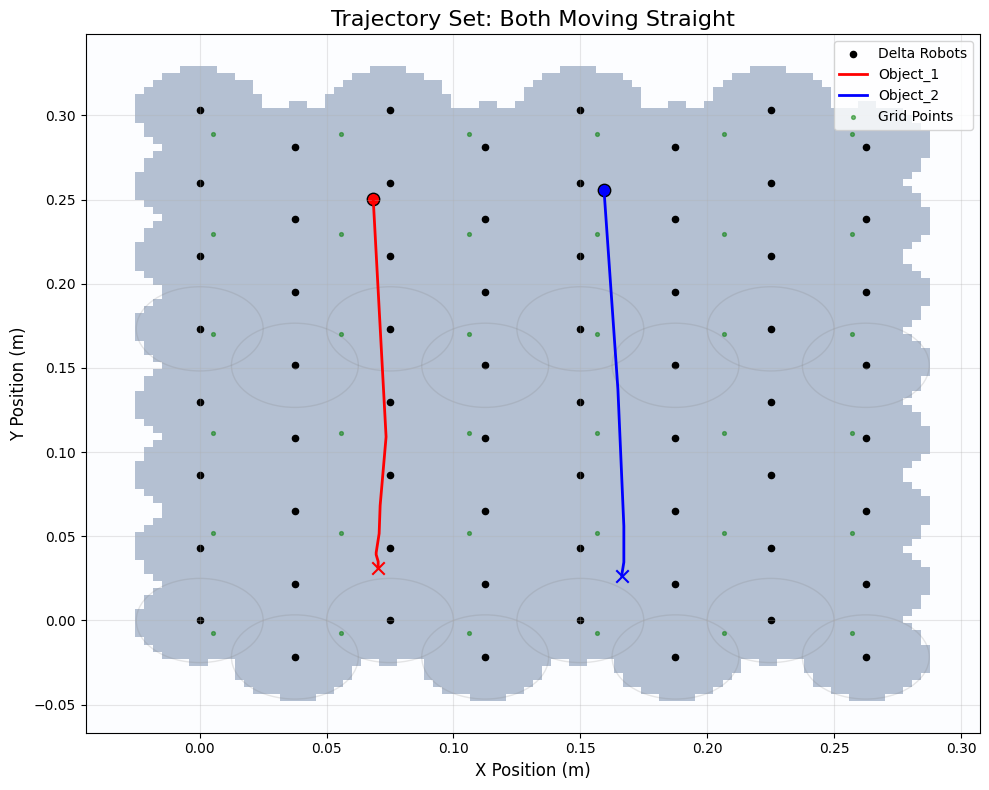

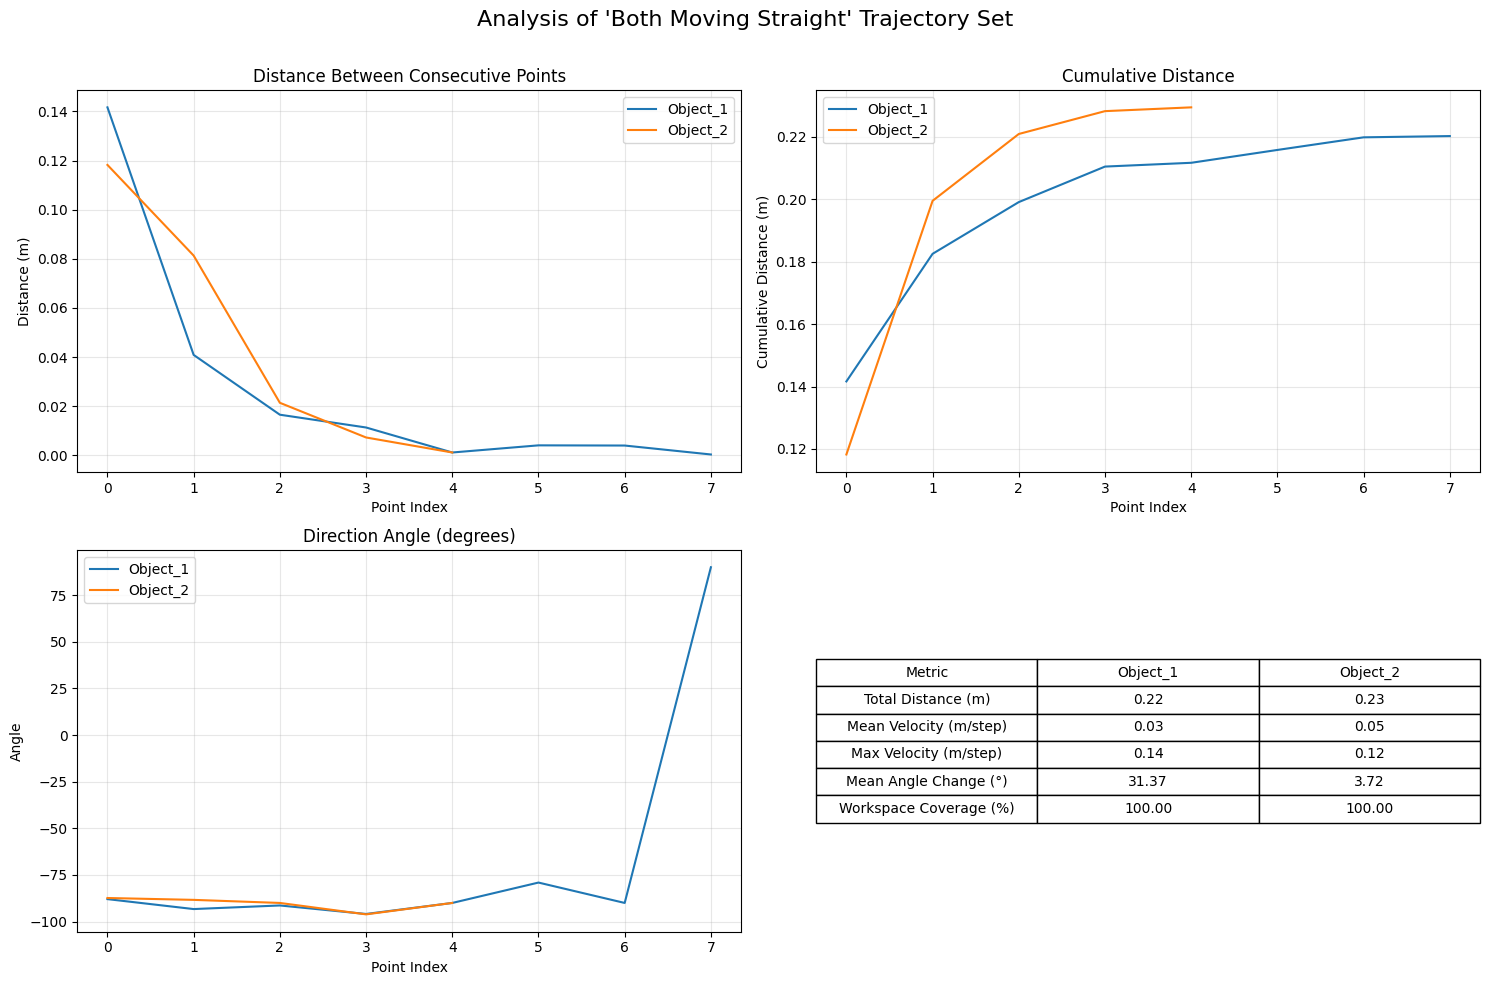

In [18]:
visualize_trajectories(data, trajectory_set="Both Moving Straight")
fig, metrics = analyze_trajectories(data, trajectory_set="Both Moving Straight")

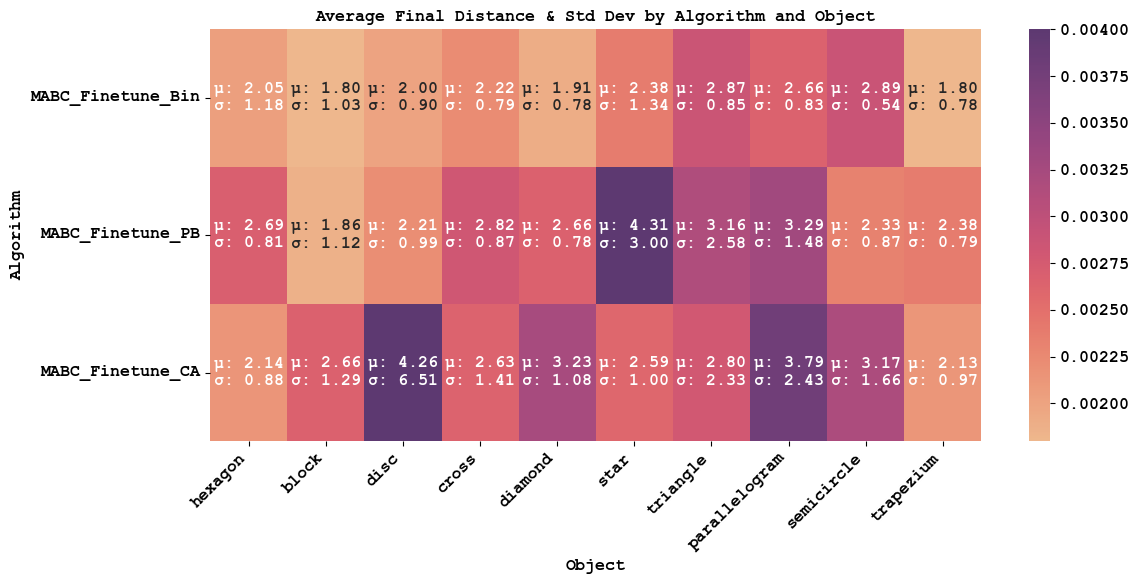

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for heatmap
OBJ_NAMES = ['hexagon', "block", 'disc', 'cross', 'diamond', 'star', 'triangle', 'parallelogram', 'semicircle', "trapezium"]
# algos = ["Vis Servo", "MATSAC", "MABC", "MABC Finetuned"]
algos = ["MABC_Finetune_Bin","MABC_Finetune_PB","MABC_Finetune_CA"]

# Initialize arrays for means and stds
dist_mean = np.zeros((len(algos), len(OBJ_NAMES)), dtype=np.float64)
dist_std = np.zeros((len(algos), len(OBJ_NAMES)), dtype=np.float64)

# Loop over each algorithm and object to gather final distances across all trajectories & runs
for a_idx, algo in enumerate(algos):
    for o_idx, obj_name in enumerate(OBJ_NAMES):
        dist_list = []
        obj_data = experiment_data[algo].get(obj_name, {})
        
        for traj_name, run_dict in obj_data.items():
            for run_id, step_data_list in run_dict.items():
                if step_data_list:  # If there are any steps
                    dist_list.append(step_data_list[-1]['dist'])  # Get final distance
        
        if dist_list:
            dist_mean[a_idx, o_idx] = np.mean(dist_list)
            dist_std[a_idx, o_idx] = np.std(dist_list)
        else:
            dist_mean[a_idx, o_idx] = np.nan
            dist_std[a_idx, o_idx] = np.nan

# Create annotation text with mean and std
annot_text = np.empty_like(dist_mean, dtype=object)
for i in range(len(algos)):
    for j in range(len(OBJ_NAMES)):
        m = dist_mean[i, j]
        s = dist_std[i, j]
        if np.isnan(m):
            annot_text[i, j] = ""
        else:
            annot_text[i, j] = f"µ: {1000*m:.2f}\nσ: {1000*s:.2f}"

# Create the heatmap
plt.figure(figsize=(12, 6))
plt.rcParams['font.family'] = 'Courier New'
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'

font_properties = {
    'family': 'Courier New',
    'size': 12,
    'weight': 'bold',
}

# Create heatmap
sns.heatmap(
    dist_mean,
    annot=annot_text,
    fmt="",
    xticklabels=OBJ_NAMES,
    # yticklabels=["Vis Servo", "MATSAC", "MABC", "MABC-FT"],
    yticklabels=["MABC_Finetune_Bin","MABC_Finetune_PB","MABC_Finetune_CA"],
    cmap='flare',
    alpha=0.9,
    edgecolor='black',
    vmax=0.004
)

plt.title('Average Final Distance & Std Dev by Algorithm and Object', fontdict=font_properties)
plt.xlabel('Object', fontdict=font_properties)
plt.ylabel('Algorithm', fontdict=font_properties)
plt.xticks(rotation=45, ha='right')  # Rotate object names for better readability
plt.tight_layout()
plt.show()

In [7]:
import numpy as np
from skimage.morphology import skeletonize
import cv2
from collections import deque
def get_skeleton_from_img(img, trad=True, mask=False):
    if not mask:
        if trad:
            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            mask = cv2.inRange(hsv, lower_green, upper_green)
            mask = (mask > 0).astype(np.uint8)
        else:
            raise NotImplementedError("Only trad-based segmentation is supported in sim.")
    else:
        mask = img

    skeleton = skeletonize(mask)
    coords = np.column_stack(np.nonzero(skeleton))

    if coords.shape[0] < 2:
        return coords

    coord_to_idx = {tuple(pt): i for i, pt in enumerate(coords)}
    n_pixels = coords.shape[0]
    neighbors = [[] for _ in range(n_pixels)]
    for i, (y, x) in enumerate(coords):
        for dy in (-1, 0, 1):
            for dx in (-1, 0, 1):
                if dy == 0 and dx == 0:
                    continue
                ny, nx = y + dy, x + dx
                if (ny, nx) in coord_to_idx:
                    neighbors[i].append(coord_to_idx[(ny, nx)])

    
    def bfs_farthest(start):
        visited = set([start])
        parent = {start: -1}
        queue = deque([start])
        farthest = start
        while queue:
            cur = queue.popleft()
            farthest = cur
            for nbr in neighbors[cur]:
                if nbr not in visited:
                    visited.add(nbr)
                    parent[nbr] = cur
                    queue.append(nbr)
        return farthest, parent
    
    def reconstruct_path(end_idx, parent):
        path = []
        node = end_idx
        while node != -1:
            path.append(node)
            node = parent[node]
        path.reverse()
        return path

    A, _ = bfs_farthest(0)
    B, parentB = bfs_farthest(A)
    visited = set([A])
    parentAB = {A: -1}
    queue = deque([A])
    while queue:
        curr = queue.popleft()
        if curr == B:
            break
        for nbr in neighbors[curr]:
            if nbr not in visited:
                visited.add(nbr)
                parentAB[nbr] = curr
                queue.append(nbr)
    path_indices = reconstruct_path(B, parentAB)
    ordered_coords = coords[path_indices]
    return ordered_coords

def sample_points(ordered_coords, total_points):
    """
    Samples `total_points` equidistant points along ordered_coords (y,x).
    Handles edge cases where skeleton is degenerate or has repeated distances.
    """
    n = ordered_coords.shape[0]
    if n == 0:
        return np.zeros((total_points, 2))
    if n == 1:
        return np.tile(ordered_coords[0], (total_points, 1))

    diffs = np.diff(ordered_coords, axis=0)
    dists = np.hypot(diffs[:, 0], diffs[:, 1])  # length of each segment
    cumulative_dist = np.hstack(([0.0], np.cumsum(dists)))
    total_length = cumulative_dist[-1]

    if total_length == 0:
        return np.tile(ordered_coords[0], (total_points, 1))

    unique_mask = np.diff(cumulative_dist, prepend=-1) > 0
    cumdist_unique = cumulative_dist[unique_mask]
    coords_unique = ordered_coords[unique_mask]

    sample_dists = np.linspace(0, cumdist_unique[-1], total_points)
    sampled_y = np.interp(sample_dists, cumdist_unique, coords_unique[:, 0])
    sampled_x = np.interp(sample_dists, cumdist_unique, coords_unique[:, 1])
    sampled_points = np.column_stack((sampled_y, sampled_x))

    return sampled_points

In [153]:
from PIL import Image
from lang_sam import LangSAM

model = LangSAM()

Predicting 1 masks
Predicted 1 masks
Inference time: 0.2476351261138916


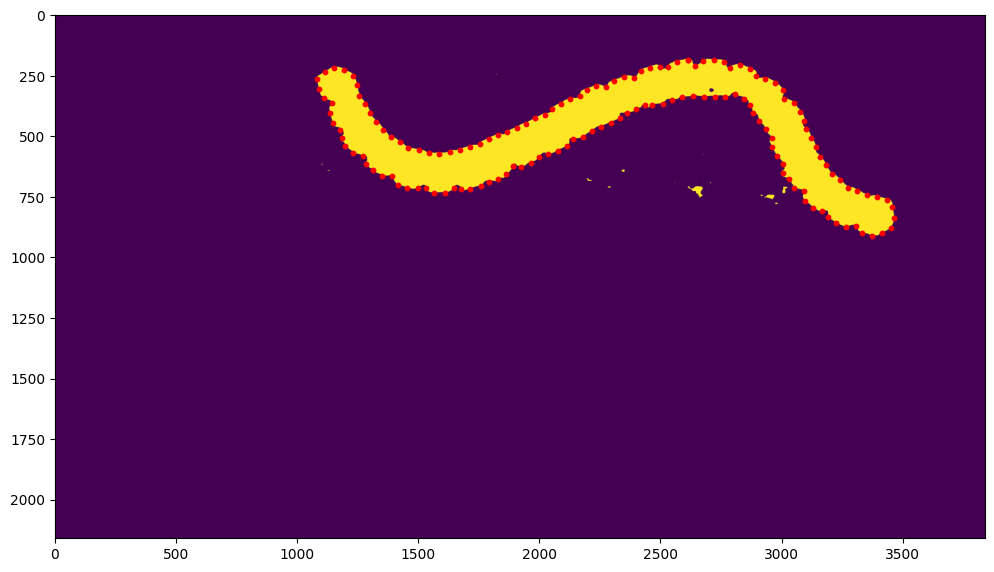

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import time
import cv2
from skimage import img_as_ubyte

lower_green_filter = np.array([35, 50, 50])
upper_green_filter = np.array([85, 255, 255])
# kernel = np.ones((11,11), np.uint8)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11, 11))


plt.figure(figsize=(12, 8))
image = cv2.imread("./data/temp/real_rope_2.jpg")
# image = cv2.imread("./data/temp/rope_init.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
hsv_mask = cv2.inRange(hsv, lower_green_filter, upper_green_filter)


now = time.time()
image = Image.fromarray(image)
text_prompt = "green rope"
results = model.predict([image], [text_prompt])

mask = results[0]['masks'][0]
mask = img_as_ubyte(mask)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
h, w = mask.shape
flood = mask.copy()
bg_mask = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(flood, bg_mask, (0,0), 255)
holes = cv2.bitwise_not(flood)
filled = cv2.bitwise_or(mask, holes)


contours, hierarchy = cv2.findContours(filled, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
main_contour = max(contours, key=cv2.contourArea)

# Contour points are usually shape (N, 1, 2) with (x, y) format
# Reshape to (N, 2)
contour_points_xy = main_contour.reshape(-1, 2)

# Convert contour points from (x, y) to (y, x) to match sample_points function expectation
contour_points_yx = contour_points_xy[:, ::-1] # Swap columns y=pos[1], x=pos[0]

# Use your existing sample_points function to sample along the contour
sampled_points = sample_points(contour_points_yx, total_points=150)


plt.imshow(mask)
# goal_rope_coords = get_skeleton_from_img(mask, mask=True)
# sampled_points = sample_points(goal_rope_coords, total_points=50)
print("Inference time:", time.time() - now)
plt.scatter(sampled_points[:, 1], sampled_points[:, 0], color='red', s=10)

In [151]:
import time
import numpy as np
from PIL import Image

# Simulate a typical image size (1080p)
arr = np.random.randint(0, 256, size=(1080, 1920, 3), dtype=np.uint8)

# Warm-up
pil_img = Image.fromarray(arr)
_ = np.asarray(pil_img)

# Number of iterations for timing
n = 100

# Measure Image.fromarray
start = time.perf_counter()
for _ in range(n):
    img = Image.fromarray(arr)
time_fromarray = time.perf_counter() - start

# Measure np.asarray
start = time.perf_counter()
for _ in range(n):
    _ = np.asarray(pil_img)
time_astype = time.perf_counter() - start

# Display results
print(f"Average Image.fromarray: {time_fromarray / n * 1000:.3f} ms per call")
print(f"Average np.asarray:    {time_astype / n * 1000:.3f} ms per call")


Average Image.fromarray: 1.016 ms per call
Average np.asarray:    0.780 ms per call


Predicting 1 masks
Predicted 1 masks
Inference time: 0.1779336929321289


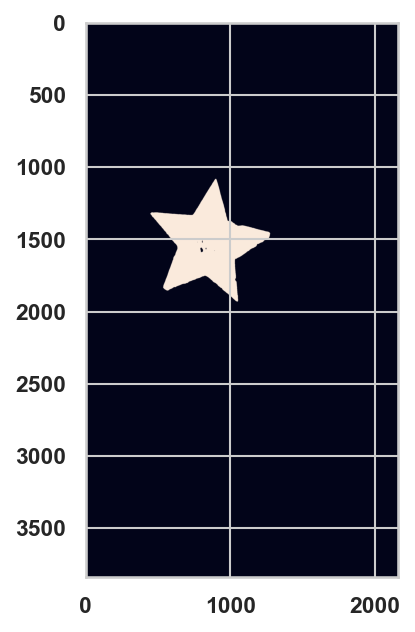

IndexError: index 1 is out of bounds for axis 0 with size 1

In [154]:
image_pil = Image.open("./data/temp/star.jpg").convert("RGB")
now = time.time()
text_prompt = "green block"
results = model.predict([image_pil], [text_prompt])
print("Inference time:", time.time() - now)
for i in range(2):
    plt.imshow(np.moveaxis(results[0]['masks'][i], 0, -1))
    plt.show()

In [1]:

from utils.vision_utils import VisUtils
import numpy as np
plane_size = np.array([(0.009,  -0.034),(0.24200, 0.376)])
vis_utils = VisUtils(obj_detection_model="IDEA-Research/grounding-dino-tiny", 
                segmentation_model="facebook/sam-vit-base",
                device="cuda",
                traditional=False, plane_size=plane_size)
vis_utils.set_label("green rope")

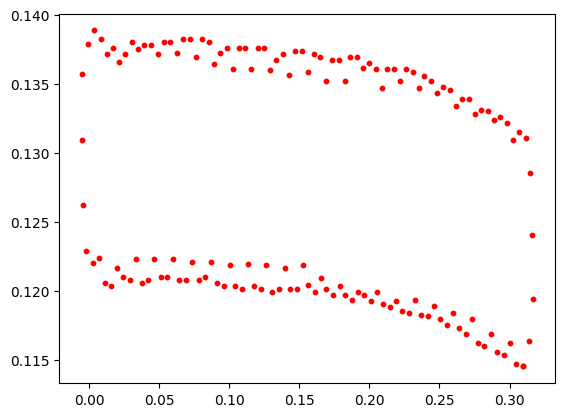

In [3]:

import cv2
from skimage import img_as_ubyte
import matplotlib.pyplot as plt

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11, 11))
goal_img = cv2.imread("./data/temp/rope_goal.jpg")
goal_img = cv2.resize(goal_img, (1920, 1080))
sampled_points = vis_utils.get_bd_pts(goal_img)

plt.scatter(sampled_points[:, 1], sampled_points[:, 0], color='red', s=10)
# plt.xlim(plane_size[0][0], plane_size[1][0])
# plt.ylim(plane_size[0][1], plane_size[1][1])

In [4]:
import pickle as pkl
pkl.dump(sampled_points, open("./data/temp/rope_goal_coords.pkl", "wb"))

In [ ]:

vid_paths = ["./data/videos/real/video_MABC_Finetune_PB_CA_square_trapezium.mp4 ",
"./data/videos/real/video_MABC_Finetune_PB_CA_cross_star.mp4 ",
"./data/videos/real/video_MABC_Finetune_PB_CA_snek_hexagon.mp4 ",
"./data/videos/real/video_MABC_Finetune_CA_snek_hexagon.mp4 ",
"./data/videos/real/video_MABC_Finetune_PB_snek_hexagon.mp4 ",
"./data/videos/real/video_MABC_Finetune_Bin_square_trapezium.mp4 ",
"./data/videos/real/video_MABC_Finetune_PB_square_trapezium.mp4 ",
"./data/videos/real/video_MABC_Finetune_CA_square_trapezium.mp4 ",
"./data/videos/real/video_MABC_Finetune_CA_cross_star.mp4 ",
"./data/videos/real/video_MABC_Finetune_PB_cross_star.mp4 ",
"./data/videos/real/video_MABC_Finetune_Bin_cross_star.mp4 ",
"./data/videos/real/video_MABC_Finetune_Bin_snek_hexagon.mp4 ",
"./data/videos/real/video_MATSAC_snek_hexagon.mp4 ",
"./data/videos/real/video_MABC_Finetune_snek_hexagon.mp4 ",
"./data/videos/real/video_MABC_Finetune_PB_square_hexagon.mp4 ",
"./data/videos/real/video_Vis Servo_snek_hexagon.mp4"]

In [ ]:
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
from utils.vision_utils import VisUtils

ALGO_NAME = "MABC_Finetune_PB"
TRAJ_NAME = "snek"
OBJ_NAME = "block"
DEVICE = 'cpu' # <<< SET: Device for VisUtils if needed ('cuda', 'cpu')

# --- File Paths ---
BASE_DATA_PATH = "./data/test_traj/"
BACKGROUND_IMG_PATH = "./only_robots.jpg"
TARGET_TRAJ_PATH = os.path.join(BASE_DATA_PATH, "test_trajs_new.pkl")
RESULTS_PKL_PATH = os.path.join(BASE_DATA_PATH, f"test_traj_{ALGO_NAME}_{TRAJ_NAME}_{OBJ_NAME}.pkl")
OUTPUT_IMG_PATH = f"./data/results/real/trajectory_overlay_{ALGO_NAME}_{TRAJ_NAME}_{OBJ_NAME}.png"


plane_size = np.array([(0.009,  -0.034),(0.24200, 0.376)])
vis_utils = VisUtils(obj_detection_model="IDEA-Research/grounding-dino-tiny", 
                segmentation_model="facebook/sam-vit-base",
                device="cuda",
                traditional=False, plane_size=plane_size)


def world_to_pixel(world_coords_list):
    if not world_coords_list:
        return []
    world_vecs = np.array(world_coords_list)[:, :2]
    pixel_vecs = vis_utils.convert_world_2_pix(world_vecs)
    pixel_coords_list = [(int(px), int(py)) for px, py in pixel_vecs]
    return pixel_coords_list


In [ ]:
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
import re # For parsing filenames
from utils.vision_utils import VisUtils # Assuming VisUtils is importable
import torch

# --- Configuration ---
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' # <<< SET: Device for VisUtils ('cuda', 'cpu')
FRAME_SKIP = 5 # <<< SET: Process every Nth frame (1 = process all)
N_OBJ_TO_DETECT = 1 # <<< SET: Number of objects expected for get_bdpts

# --- Critical VisUtils Config ---
# You MUST provide the correct plane_size used during the experiments/recordings
# This might need to be loaded from a config file or defined based on setup
# EXAMPLE Placeholder: Replace with your actual value(s)
PLANE_SIZE = np.array([(0.009,  -0.034),(0.24200, 0.376)])

# --- File Paths ---
BASE_VIDEO_PATH = "./data/videos/real/"
BACKGROUND_IMG_PATH = "./data/temp/only_robots.jpg"
TARGET_TRAJ_PATH = "./data/test_traj/test_trajs_new.pkl" # Path to target trajectories
OUTPUT_DIR = "./data/results/real/" # Directory to save plots

img_height, img_width = 1080, 1920


# List of video paths provided by the user
vid_paths = ["./data/videos/real/video_MABC_Finetune_PB_CA_square_trapezium.mp4",
             "./data/videos/real/video_MABC_Finetune_PB_CA_cross_star.mp4",
             "./data/videos/real/video_MABC_Finetune_PB_CA_snek_hexagon.mp4",
             "./data/videos/real/video_MABC_Finetune_CA_snek_hexagon.mp4",
             "./data/videos/real/video_MABC_Finetune_PB_snek_hexagon.mp4",
             "./data/videos/real/video_MABC_Finetune_Bin_square_trapezium.mp4",
             "./data/videos/real/video_MABC_Finetune_PB_square_trapezium.mp4",
             "./data/videos/real/video_MABC_Finetune_CA_square_trapezium.mp4",
             "./data/videos/real/video_MABC_Finetune_CA_cross_star.mp4",
             "./data/videos/real/video_MABC_Finetune_PB_cross_star.mp4",
             "./data/videos/real/video_MABC_Finetune_Bin_cross_star.mp4",
             "./data/videos/real/video_MABC_Finetune_Bin_snek_hexagon.mp4",
             "./data/videos/real/video_MATSAC_snek_hexagon.mp4",
             "./data/videos/real/video_MABC_Finetune_snek_hexagon.mp4",
             # "./data/videos/real/video_MABC_Finetune_PB_square_hexagon.mp4", # Seems like obj mismatch? Assuming square_trapezium or hexagon
             "./data/videos/real/video_Vis Servo_snek_hexagon.mp4"]

vid_paths = [p.strip() for p in vid_paths]
vis_utils = VisUtils(obj_detection_model="IDEA-Research/grounding-dino-tiny",
                        segmentation_model="facebook/sam-vit-base",
                        device=DEVICE,
                        traditional=False, 
                        plane_size=PLANE_SIZE)

with open(TARGET_TRAJ_PATH, 'rb') as f:
    target_traj_data = pickle.load(f)

background_bgr = cv2.imread(BACKGROUND_IMG_PATH)
background_bgr = cv2.resize(background_bgr, (1920, 1080))
if background_bgr is None:
    raise FileNotFoundError(f"Background image not found at {BACKGROUND_IMG_PATH}")
background_rgb = cv2.cvtColor(background_bgr, cv2.COLOR_BGR2RGB)
img_height, img_width = background_rgb.shape[:2]
print(f"Loaded background image ({img_width}x{img_height})")
    

# --- Ensure output directory exists ---
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Coordinate Transformation Wrapper ---
def world_to_pixel(world_coords_list, img_w, img_h):
    """Converts list of world [(x,y),...] to list of pixel [(u,v),...] using VisUtils logic."""
    # if not world_coords_list: return []
    world_vecs = np.array(world_coords_list)[:, :2] # Ensure shape is (N, 2)

    # Use the logic derived from VisUtils, but with actual image dimensions
    # Assumes vis_utils.delta_plane_x/y and vis_utils.plane_size are accessible
    # If not, calculate them from PLANE_SIZE
    try:
        delta_x = vis_utils.delta_plane_x
        delta_y = vis_utils.delta_plane_y
        origin_x = vis_utils.plane_size[0][0]
        origin_y = vis_utils.plane_size[0][1]
    except AttributeError:
        # Fallback calculation if not attributes
        delta_x = PLANE_SIZE[1][0] - PLANE_SIZE[0][0]
        delta_y = PLANE_SIZE[1][1] - PLANE_SIZE[0][1]
        origin_x = PLANE_SIZE[0][0]
        origin_y = PLANE_SIZE[0][1]
        if delta_x == 0 or delta_y == 0:
            print("Error: Cannot calculate delta_plane from PLANE_SIZE.")
            return []

    pixel_vecs = np.zeros_like(world_vecs, dtype=int)
    # Pixel U (X-coordinate) depends on Image Width
    pixel_vecs[:, 0] = ((world_vecs[:, 0] - origin_x) / delta_x * img_w).astype(int)
    # Pixel V (Y-coordinate) depends on Image Height, and is inverted
    pixel_vecs[:, 1] = (img_h - ((world_vecs[:, 1] - origin_y) / delta_y * img_h)).astype(int)

    return [(int(px), int(py)) for px, py in pixel_vecs]

# --- Function to get object patch (using bounding box approximation) ---
def get_object_patch_and_bounds(frame_bgr, world_bounds):
    """
    Gets pixel bounds and extracts the BGR patch.
    Returns None, None if conversion fails or bounds are invalid.
    """
    if world_bounds is None or len(world_bounds) < 2: return None, None

    # Convert world bounding points to pixel coordinates
    pixel_bounds = world_to_pixel(world_bounds, frame_bgr.shape[1], frame_bgr.shape[0])
    if not pixel_bounds: return None, None

    # Find min/max pixel coordinates to define the bounding box
    px_coords = np.array(pixel_bounds)
    try:
        x_min, y_min = np.min(px_coords, axis=0)
        x_max, y_max = np.max(px_coords, axis=0)
    except ValueError: # Handle empty array if conversion failed badly
        return None, None

    # Ensure bounds are within image dimensions and valid
    h, w = frame_bgr.shape[:2]
    x_min = max(0, x_min)
    y_min = max(0, y_min)
    x_max = min(w - 1, x_max)
    y_max = min(h - 1, y_max)

    if x_min >= x_max or y_min >= y_max: return None, None # Invalid box

    # Crop the patch (BGR)
    patch_bgr = frame_bgr[y_min:y_max+1, x_min:x_max+1]
    pixel_box = (x_min, y_min, x_max, y_max)

    return patch_bgr, pixel_box

# --- Process Each Video ---
for vid_path in vid_paths:
    print(f"\n--- Processing Video: {vid_path} ---")
    base_filename = os.path.basename(vid_path)
    filename_no_ext = os.path.splitext(base_filename)[0]
    parts = filename_no_ext.split('_')
    if len(parts) >= 4:
        obj_name_parsed = parts[-1]
        traj_name_parsed = parts[-2]
        algo_name_parsed = "_".join(parts[1:-2])
        print(f"  Parsed: Algo='{algo_name_parsed}', Traj='{traj_name_parsed}', Obj='{obj_name_parsed}'")
    else:
        print(f"  Warning: Could not parse filename '{filename_no_ext}'. Skipping.")
        continue

    # --- Get Target Path ---
    if traj_name_parsed not in target_traj_data:
        print(f"  Warning: Target trajectory '{traj_name_parsed}' not found. Skipping.")
        continue
    target_world_poses = target_traj_data[traj_name_parsed]
    target_world_coords_list = [pose[:2] for pose in target_world_poses]
    target_pixel_coords = world_to_pixel(target_world_coords_list, img_width, img_height)
    if not target_pixel_coords:
        print("  Warning: Failed to convert target coordinates. Skipping.")
        continue

    # --- Extract Actual Path and Patches from Video ---
    detected_patches_data = [] # Store tuples: (patch_rgba, pixel_box, alpha)
    cap = cv2.VideoCapture(vid_path)
    if not cap.isOpened(): print(f"  Error opening video {vid_path}. Skipping."); continue

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames_to_process_indices = [i for i in range(total_frames) if i % FRAME_SKIP == 0]
    num_patches_to_overlay = len(frames_to_process_indices)

    frame_idx = 0
    processed_count = 0
    while True:
        ret, frame = cap.read()
        if not ret: break

        if frame_idx % FRAME_SKIP == 0:
            current_frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            print(f"\r  Processing frame {frame_idx}/{total_frames}...", end="")
            processed_count += 1
            bd_pts_world = None # Initialize to None

            bd_pts_world_raw = vis_utils.get_bdpts(frame, N_OBJ_TO_DETECT)
            
            is_valid_bd_pts = False
            if bd_pts_world_raw is not None:
                # Ensure it's a NumPy array and has the right structure
                if isinstance(bd_pts_world_raw, (list, tuple)):
                    bd_pts_world_raw = np.array(bd_pts_world_raw) # Attempt conversion

                if isinstance(bd_pts_world_raw, np.ndarray) and bd_pts_world_raw.ndim == 2 and bd_pts_world_raw.shape[0] >= 2 and bd_pts_world_raw.shape[1] >= 2:
                    # Looks like a valid array of at least 2 points with at least (x, y)
                    bd_pts_world = bd_pts_world_raw # Assign valid points
                    is_valid_bd_pts = True
                    
            if is_valid_bd_pts:
                patch_bgr, pixel_box = get_object_patch_and_bounds(frame, bd_pts_world) # Pass the validated array

                if patch_bgr is not None and patch_bgr.size > 0:
                    patch_rgba = cv2.cvtColor(patch_bgr, cv2.COLOR_BGR2RGBA)
                    alpha_val = 0.1 + (0.9 * (processed_count / max(1, num_patches_to_overlay)))
                    patch_rgba[:, :, 3] = (patch_rgba[:, :, 3] * alpha_val).astype(np.uint8)
                    detected_patches_data.append((patch_rgba, pixel_box, alpha_val))

        frame_idx += 1
    # (rest of the code: cap.release(), plotting, etc.)

    cap.release()
    print(f"\n  Finished video processing. Extracted {len(detected_patches_data)} patches.")

    # --- Plotting ---
    print("  Generating plot with opacity overlay...")
    fig, ax = plt.subplots(figsize=(10, 10 * (img_height / img_width)))
    ax.imshow(background_rgb) # Show background first

    # Overlay detected object patches with increasing alpha
    if detected_patches_data:
        print(f"  Overlaying {len(detected_patches_data)} patches...")
        # Sort by alpha maybe? Or just plot in order. Order matters for overlap.
        # Let's plot in the order they were detected.
        for patch_rgba, pixel_box, alpha_val in detected_patches_data:
            x_min, y_min, x_max, y_max = pixel_box
            # Use imshow to place the patch correctly, respecting alpha
            ax.imshow(patch_rgba, extent=(x_min, x_max, y_max, y_min), # extent=(left, right, bottom, top)
                      interpolation='nearest', alpha=1.0) # Use alpha baked into patch_rgba


    # Plot Target Trajectory (on top)
    if target_pixel_coords:
        target_x, target_y = zip(*target_pixel_coords)
        ax.plot(target_x, target_y, color='cyan', linestyle=':', linewidth=2.0, # Dotted target path
                # marker='.', markersize=3, # Smaller markers if needed
                label='Target Path', zorder=10) # Ensure target path is visible

    # Optional: Plot actual centroid path faintly for reference
    actual_pixel_centroids = world_to_pixel([data[1] for data in detected_patches_data if data[1]], img_width, img_height) # Need to re-calc centroids if needed
    if len(actual_pixel_centroids) > 1:
       actual_x, actual_y = zip(*actual_pixel_centroids)
       ax.plot(actual_x, actual_y, color='red', linestyle='-', linewidth=1.0, alpha=0.5, label='Centroid Path (Actual)', zorder=5)


    # --- Final Plot Customization ---
    ax.set_title(f"{algo_name_parsed} on '{obj_name_parsed}' - Traj: '{traj_name_parsed}' (Object Overlay)", fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend(loc='best', fontsize=9)
    ax.set_xlim(0, img_width) # Ensure plot limits match image
    ax.set_ylim(img_height, 0) # Ensure plot limits match image (inverted y)
    plt.tight_layout()

    # --- Save ---
    output_filename = f"overlay_opacity_{algo_name_parsed}_{traj_name_parsed}_{obj_name_parsed}.png"
    output_path = os.path.join(OUTPUT_DIR, output_filename)
    try:
        plt.savefig(output_path, dpi=150, bbox_inches='tight') # Lower DPI might be faster/smaller
        print(f"  Saved plot to: {output_path}")
    except Exception as e:
        print(f"  Error saving plot: {e}")
    plt.close(fig)

print("\n--- All videos processed ---")

Loaded background image (1920x1080)

--- Processing Video: ./data/videos/real/video_MABC_Finetune_PB_CA_square_trapezium.mp4 ---
  Parsed: Algo='MABC_Finetune_PB_CA', Traj='square', Obj='trapezium'
  Processing frame 2210/2214...
  Finished video processing. Extracted 443 patches.
  Generating plot with opacity overlay...
  Overlaying 443 patches...
  Saved plot to: ./data/results/real/overlay_opacity_MABC_Finetune_PB_CA_square_trapezium.png

--- Processing Video: ./data/videos/real/video_MABC_Finetune_PB_CA_cross_star.mp4 ---
  Parsed: Algo='MABC_Finetune_PB_CA', Traj='cross', Obj='star'
  Processing frame 960/963...
  Finished video processing. Extracted 193 patches.
  Generating plot with opacity overlay...
  Overlaying 193 patches...
  Saved plot to: ./data/results/real/overlay_opacity_MABC_Finetune_PB_CA_cross_star.png

--- Processing Video: ./data/videos/real/video_MABC_Finetune_PB_CA_snek_hexagon.mp4 ---
  Parsed: Algo='MABC_Finetune_PB_CA', Traj='snek', Obj='hexagon'
  Processi

KeyboardInterrupt: 

In [ ]:
import cv2
import os
import numpy as np
from pathlib import Path

def convert_bgr_to_rgb(input_folder, output_folder, extensions=None):
    if extensions is None:
        extensions = ['.mp4', '.avi', '.mov', '.mkv']
    
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    # Get all video files in input folder
    input_path = Path(input_folder)
    video_files = []
    for ext in extensions:
        video_files.extend(list(input_path.glob(f'*{ext}')))
    
    print(f"Found {len(video_files)} video files to process")
    
    for video_file in video_files:
        input_path = str(video_file)
        filename = video_file.name
        output_path = os.path.join(output_folder, filename)
        
        print(f"Processing {filename}...")
        
        # Open input video
        cap = cv2.VideoCapture(input_path)
        if not cap.isOpened():
            print(f"Error: Could not open video {input_path}")
            continue
        
        # Get video properties
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        # Create VideoWriter object
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can change the codec as needed
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
        
        frame_count = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # bgr_for_writing = cv2.cvtColor(rgb_frame, cv2.COLOR_RGB2BGR)
            out.write(rgb_frame)
            
            frame_count += 1
            if frame_count % 100 == 0:
                print(f"Processed {frame_count}/{total_frames} frames")
        
        cap.release()
        out.release()
        
        print(f"Completed {filename}")
    print("All videos have been processed!")

if __name__ == "__main__":
    input_folder = "/home/nagababa/Sarvesh/Research/PaperWritingMaterial/MADDM/videos/input"
    output_folder = "/home/nagababa/Sarvesh/Research/PaperWritingMaterial/MADDM/videos/output"
    
    convert_bgr_to_rgb(input_folder, output_folder)

Found 16 video files to process
Processing video_MABC_Finetune_PB_CA_snek_hexagon.mp4...
Processed 100/890 frames
Processed 200/890 frames
Processed 300/890 frames
Processed 400/890 frames
Processed 500/890 frames
Processed 600/890 frames
Processed 700/890 frames
Processed 800/890 frames
Completed video_MABC_Finetune_PB_CA_snek_hexagon.mp4
Processing video_MABC_Finetune_CA_snek_hexagon.mp4...
Processed 100/906 frames
Processed 200/906 frames
Processed 300/906 frames
Processed 400/906 frames
Processed 500/906 frames
Processed 600/906 frames
Processed 700/906 frames
Processed 800/906 frames
Processed 900/906 frames
Completed video_MABC_Finetune_CA_snek_hexagon.mp4
Processing video_MABC_Finetune_snek_hexagon.mp4...
Processed 100/433 frames
Processed 200/433 frames
Processed 300/433 frames
Processed 400/433 frames
Completed video_MABC_Finetune_snek_hexagon.mp4
Processing video_MABC_Finetune_Bin_square_trapezium.mp4...
Processed 100/3072 frames
Processed 200/3072 frames
Processed 300/3072 f

[mov,mp4,m4a,3gp,3g2,mj2 @ 0x2d9c9f40] moov atom not found


Processed 100/3194 frames
Processed 200/3194 frames
Processed 300/3194 frames
Processed 400/3194 frames
Processed 500/3194 frames
Processed 600/3194 frames
Processed 700/3194 frames
Processed 800/3194 frames
Processed 900/3194 frames
Processed 1000/3194 frames
Processed 1100/3194 frames
Processed 1200/3194 frames
Processed 1300/3194 frames
Processed 1400/3194 frames
Processed 1500/3194 frames
Processed 1600/3194 frames
Processed 1700/3194 frames
Processed 1800/3194 frames
Processed 1900/3194 frames
Processed 2000/3194 frames
Processed 2100/3194 frames
Processed 2200/3194 frames
Processed 2300/3194 frames
Processed 2400/3194 frames
Processed 2500/3194 frames
Processed 2600/3194 frames
Processed 2700/3194 frames
Processed 2800/3194 frames
Processed 2900/3194 frames
Processed 3000/3194 frames
Processed 3100/3194 frames
Completed video_MABC_Finetune_Bin_cross_star.mp4
Processing video_MABC_Finetune_CA_cross_star.mp4...
Processed 100/1651 frames
Processed 200/1651 frames
Processed 300/1651 

In [ ]:
import cv2
import os
import numpy as np
import pickle as pkl
from pathlib import Path
import sys # Added for error handling

# --- Configuration ---
# Colors for trajectories (BGR format for OpenCV)
GT_COLOR = (0, 255, 0)  # Green
ACTUAL_COLOR = (0, 0, 255) # Red
CURRENT_STEP_COLOR = (0, 255, 255) # Yellow (for current actual movement)
MARKER_COLOR_GT = (0, 128, 0) # Darker Green for target marker
MARKER_COLOR_ACTUAL = (0, 0, 128) # Darker Red for actual pos marker

# Drawing parameters
LINE_THICKNESS = 2
MARKER_RADIUS_CURRENT = 5
MARKER_RADIUS_PATH = 3 # Smaller markers for the path points


# UPDATED world_to_pixel function
def world_to_pixel(world_coord, frame_width, frame_height, plane_corners):
    world_x, world_y = world_coord[0], world_coord[1]

    x_min, y_min = plane_corners[0]
    x_max, y_max = plane_corners[1]

    world_width = x_max - x_min
    world_height = y_max - y_min

    if world_width <= 0 or world_height <= 0:
        print(f"Error: Invalid world dimensions calculated from corners ({world_width}x{world_height}). Check plane_corners.", file=sys.stderr)
        return None

    px_float = ((world_x - x_min) / world_width) * frame_width
    py_float = ((world_y - y_min) / world_height) * frame_height
    py_float_inverted = frame_height - 1 - py_float

    px = int(px_float)
    py = int(py_float_inverted) # Use the inverted Y coordinate
    px = max(0, min(frame_width - 1, px))
    py = max(0, min(frame_height - 1, py))

    return (px, py)

# Main overlay function (signature accepts plane_size which will be plane_corners)
def overlay_trajectories_on_video(input_video_path,output_video_path,gt_traj_pkl_path,actual_traj_pkl_path,traj_name,plane_size,):
    extension = ".mp4"

    input_path_obj = Path(input_video_path)
    output_path_obj = Path(output_video_path)
    output_path_obj.parent.mkdir(parents=True, exist_ok=True)

    # --- Load Trajectory Data --- (Same as before)
    print(f"Loading ground truth data from: {gt_traj_pkl_path}")
    traj_data_all = pkl.load(open(gt_traj_pkl_path, "rb"))
    raw_gt_poses = traj_data_all[traj_name].tolist()
    if not raw_gt_poses or len(raw_gt_poses) < 2:
            print(f"Error: Insufficient ground truth trajectory found for '{traj_name}' in {gt_traj_pkl_path}")
            return
    initial_start_pose = raw_gt_poses[0]
    gt_goal_poses_world = raw_gt_poses[1:]
    print(f"  Loaded {len(gt_goal_poses_world)} ground truth goal poses for '{traj_name}'.")


    print(f"Loading actual performance data from: {actual_traj_pkl_path}")
    try:
        actual_data_all = pkl.load(open(actual_traj_pkl_path, "rb"))
        obj_name_key = list(actual_data_all.keys())[0]
        if traj_name not in actual_data_all[obj_name_key]:
             print(f"Error: Trajectory '{traj_name}' not found in actual performance data file {actual_traj_pkl_path} for object '{obj_name_key}'")
             return
        step_data_list = actual_data_all[obj_name_key][traj_name]
        if not step_data_list:
            print(f"Error: No actual performance steps found for '{traj_name}' in {actual_traj_pkl_path}")
            return
        actual_init_poses_world = [step.get('init_qpos') for step in step_data_list] # Use .get for safety
        actual_final_poses_world = [step.get('final_qpos') for step in step_data_list]
        # Filter out None values if keys were missing
        valid_step_indices = [i for i, (init, final) in enumerate(zip(actual_init_poses_world, actual_final_poses_world)) if init is not None and final is not None]
        actual_init_poses_world = [actual_init_poses_world[i] for i in valid_step_indices]
        actual_final_poses_world = [actual_final_poses_world[i] for i in valid_step_indices]
        num_actual_steps = len(actual_init_poses_world)
        if num_actual_steps == 0:
             print(f"Error: No valid actual steps with init_qpos and final_qpos found for '{traj_name}'")
             return
        print(f"  Loaded {num_actual_steps} valid actual steps for '{traj_name}'.")
    except Exception as e:
        print(f"Error loading or processing actual performance data: {e}")
        return

    # --- Consistency Check --- (Same as before)
    if len(gt_goal_poses_world) != num_actual_steps:
        print(f"Warning: Mismatch between number of ground truth goals ({len(gt_goal_poses_world)}) and actual steps ({num_actual_steps}). Overlay might be incorrect.")
        min_steps = min(len(gt_goal_poses_world), num_actual_steps)
        gt_goal_poses_world = gt_goal_poses_world[:min_steps]
        actual_init_poses_world = actual_init_poses_world[:min_steps]
        actual_final_poses_world = actual_final_poses_world[:min_steps]
        num_actual_steps = min_steps
        if num_actual_steps == 0:
            print("Error: No matching steps found after consistency check.")
            return

    # --- Video Processing --- (Setup same as before)
    cap = cv2.VideoCapture(str(input_path_obj))
    if not cap.isOpened():
        print(f"Error: Could not open video {input_video_path}")
        return

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames <= 0 or fps <= 0:
        print(f"Warning: Could not read total frames or FPS from video. Frame synchronization might be inaccurate.")
        total_frames = 1

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(str(output_video_path), fourcc, fps, (width, height))
    if not out.isOpened():
        print(f"Error: Could not create video writer for {output_video_path}")
        cap.release()
        return

    print(f"Processing video: {input_path_obj.name} ({width}x{height} @ {fps:.2f}fps, {total_frames} frames)")
    print(f"Outputting to: {output_video_path}")
    # Use plane_size directly as it now contains the corners
    print(f"Using Plane Corner Coordinates (world units): {plane_size}")

    # --- Coordinate Conversion using updated world_to_pixel ---
    # Pass plane_size (which is the corner array) to the function
    gt_goal_poses_pixel = [world_to_pixel(pose, width, height, plane_size) for pose in gt_goal_poses_world]
    actual_init_poses_pixel = [world_to_pixel(pose, width, height, plane_size) for pose in actual_init_poses_world]
    actual_final_poses_pixel = [world_to_pixel(pose, width, height, plane_size) for pose in actual_final_poses_world]

    # --- Filtering and Frame Sync --- (Same as before)
    valid_indices_gt = [i for i, px in enumerate(gt_goal_poses_pixel) if px is not None]
    valid_indices_init = [i for i, px in enumerate(actual_init_poses_pixel) if px is not None]
    valid_indices_final = [i for i, px in enumerate(actual_final_poses_pixel) if px is not None]
    valid_indices_steps = sorted(list(set(valid_indices_gt) & set(valid_indices_init) & set(valid_indices_final)))

    if not valid_indices_steps:
         print("Error: No valid pixel coordinates could be generated for any step. Check world_to_pixel function, input data, and plane_corners.")
         cap.release()
         out.release()
         # Optionally delete the empty output file
         if Path(output_video_path).exists():
             os.remove(output_video_path)
         return

    gt_goal_poses_pixel = [gt_goal_poses_pixel[i] for i in valid_indices_steps]
    actual_init_poses_pixel = [actual_init_poses_pixel[i] for i in valid_indices_steps]
    actual_final_poses_pixel = [actual_final_poses_pixel[i] for i in valid_indices_steps]
    num_drawable_steps = len(valid_indices_steps)

    if num_drawable_steps > 0 and total_frames > 0:
        frames_per_step = total_frames / num_drawable_steps
    else:
        frames_per_step = float('inf')
        print("Warning: Cannot determine frames per step.")

    # --- Frame Processing Loop --- (Drawing logic same as before)
    frame_count = 0
    processed_frames_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        processed_frames_count += 1

        current_step_index = int(frame_count / frames_per_step)
        current_step_index = min(current_step_index, num_drawable_steps - 1)

        if num_drawable_steps > 0 and current_step_index >= 0:
            # 1. Draw Cumulative Ground Truth Path (Goals)
            for i in range(current_step_index):
                 if gt_goal_poses_pixel[i] and gt_goal_poses_pixel[i+1]:
                     cv2.line(frame, gt_goal_poses_pixel[i], gt_goal_poses_pixel[i+1], GT_COLOR, LINE_THICKNESS)
                 if gt_goal_poses_pixel[i]:
                     cv2.circle(frame, gt_goal_poses_pixel[i], MARKER_RADIUS_PATH, GT_COLOR, -1)

            # 2. Draw Cumulative Actual Path
            if actual_init_poses_pixel[0] and actual_final_poses_pixel[0]:
                 cv2.line(frame, actual_init_poses_pixel[0], actual_final_poses_pixel[0], CURRENT_STEP_COLOR, LINE_THICKNESS)
                 cv2.circle(frame, actual_init_poses_pixel[0], MARKER_RADIUS_PATH, ACTUAL_COLOR, -1)

            for i in range(current_step_index):
                 if actual_final_poses_pixel[i] and actual_init_poses_pixel[i+1]: # Connect end of last step to start of next
                      cv2.line(frame, actual_final_poses_pixel[i], actual_init_poses_pixel[i+1], ACTUAL_COLOR, LINE_THICKNESS//2, lineType=cv2.LINE_AA)

                 if actual_init_poses_pixel[i+1] and actual_final_poses_pixel[i+1]: # Connect start to end of the completed step i+1
                      cv2.line(frame, actual_init_poses_pixel[i+1], actual_final_poses_pixel[i+1], ACTUAL_COLOR, LINE_THICKNESS)

                 if actual_final_poses_pixel[i]:
                    cv2.circle(frame, actual_final_poses_pixel[i], MARKER_RADIUS_PATH, ACTUAL_COLOR, -1)

            # 3. Draw Current Step Information
            current_gt_goal_pixel = gt_goal_poses_pixel[current_step_index]
            current_actual_init_pixel = actual_init_poses_pixel[current_step_index]
            current_actual_final_pixel = actual_final_poses_pixel[current_step_index]

            if current_actual_init_pixel and current_actual_final_pixel:
                 cv2.line(frame, current_actual_init_pixel, current_actual_final_pixel, CURRENT_STEP_COLOR, LINE_THICKNESS + 1)

            if current_gt_goal_pixel:
                cv2.circle(frame, current_gt_goal_pixel, MARKER_RADIUS_CURRENT, MARKER_COLOR_GT, -1)
                cv2.putText(frame, "Target", (current_gt_goal_pixel[0] + 5, current_gt_goal_pixel[1] - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.4, MARKER_COLOR_GT, 1, cv2.LINE_AA)

            if current_actual_final_pixel:
                cv2.circle(frame, current_actual_final_pixel, MARKER_RADIUS_CURRENT, MARKER_COLOR_ACTUAL, -1)
                cv2.putText(frame, "Actual", (current_actual_final_pixel[0] + 5, current_actual_final_pixel[1] + 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.4, MARKER_COLOR_ACTUAL, 1, cv2.LINE_AA)

        # --- Write Frame ---
        out.write(frame)

        frame_count += 1
        if frame_count % 100 == 0:
            print(f"Processed {frame_count}/{total_frames} frames")

    # --- Cleanup ---
    cap.release()
    out.release()
    cv2.destroyAllWindows()

    print(f"Completed processing {processed_frames_count} frames.")
    print(f"Output video saved to: {output_video_path}")


# ==========================================
# Example Usage (adjust paths and parameters)
# ==========================================
if __name__ == "__main__":
    # --- !!! IMPORTANT: SET THESE PARAMETERS !!! ---

    # 1. Identify the specific experiment run
    ALGO = "MABC_Finetune_Bin" # Example: Algorithm name used in filename
    TRAJ_NAME = "snek"          # Example: Trajectory name (e.g., 'snek', 'cross', 'square')
    OBJ_NAME = "hexagon"           # Example: Object name

    # 2. Define Paths
    base_data_dir = "./data/test_traj/"
    base_video_dir = "/home/nagababa/Sarvesh/Research/PaperWritingMaterial/MADDM/videos/"

    input_video_filename = f"video_{ALGO}_{TRAJ_NAME}_{OBJ_NAME}.mp4"
    input_video_full_path = os.path.join(base_video_dir, "input", input_video_filename)

    output_video_filename = f"video_{ALGO}_{TRAJ_NAME}_{OBJ_NAME}_overlay.mp4"
    output_video_full_path = os.path.join(base_video_dir, "output", output_video_filename)

    ground_truth_pkl = os.path.join(base_data_dir, "test_trajs_new.pkl")
    actual_perf_pkl = os.path.join(base_data_dir, f"test_traj_{ALGO}_{TRAJ_NAME}_{OBJ_NAME}.pkl")

    # 3. Define Plane Size using Corner Coordinates <<-- UPDATED
    # Use the provided numpy array directly
    PLANE_SIZE_CORNERS = np.array([(0.009,  -0.034),(0.24200, 0.376)]) # [[x_min, y_min], [x_max, y_max]]

    # --- Check if files exist ---
    if not os.path.exists(input_video_full_path):
        print(f"ERROR: Input video not found: {input_video_full_path}")
        sys.exit(1)
    if not os.path.exists(ground_truth_pkl):
        print(f"ERROR: Ground truth pickle not found: {ground_truth_pkl}")
        sys.exit(1)
    if not os.path.exists(actual_perf_pkl):
        print(f"ERROR: Actual performance pickle not found: {actual_perf_pkl}")
        sys.exit(1)

    # --- Run the overlay function ---
    print("Starting trajectory overlay process...")
    overlay_trajectories_on_video(
        input_video_path=input_video_full_path,
        output_video_path=output_video_full_path,
        gt_traj_pkl_path=ground_truth_pkl,
        actual_traj_pkl_path=actual_perf_pkl,
        traj_name=TRAJ_NAME,
        plane_size=PLANE_SIZE_CORNERS # Pass the corner array here
    )

    print("Overlay process finished.")

Starting trajectory overlay process...
Loading ground truth data from: ./data/test_traj/test_trajs_new.pkl
  Loaded 19 ground truth goal poses for 'snek'.
Loading actual performance data from: ./data/test_traj/test_traj_MABC_Finetune_Bin_snek_hexagon.pkl
  Loaded 33 valid actual steps for 'snek'.
Processing video: video_MABC_Finetune_Bin_snek_hexagon.mp4 (1920x1080 @ 120.00fps, 2080 frames)
Outputting to: /home/nagababa/Sarvesh/Research/PaperWritingMaterial/MADDM/videos/output/video_MABC_Finetune_Bin_snek_hexagon_overlay.mp4
Using Plane Corner Coordinates (world units): [[ 0.009 -0.034]
 [ 0.242  0.376]]
Processed 100/2080 frames
Processed 200/2080 frames
Processed 300/2080 frames
Processed 400/2080 frames
Processed 500/2080 frames
Processed 600/2080 frames
Processed 700/2080 frames
Processed 800/2080 frames
Processed 900/2080 frames
Processed 1000/2080 frames
Processed 1100/2080 frames
Processed 1200/2080 frames
Processed 1300/2080 frames
Processed 1400/2080 frames
Processed 1500/2080

Found data for 72 algorithm-object-trajectory combinations.
Generating heatmaps...
Generating heatmaps for: Mean Reward, Mean Error (m), Robots Used (%)
  Processing metric: Mean Reward
    Global scale for Mean Reward: vmin=2.266 (0th), vmax=41.815 (85th)


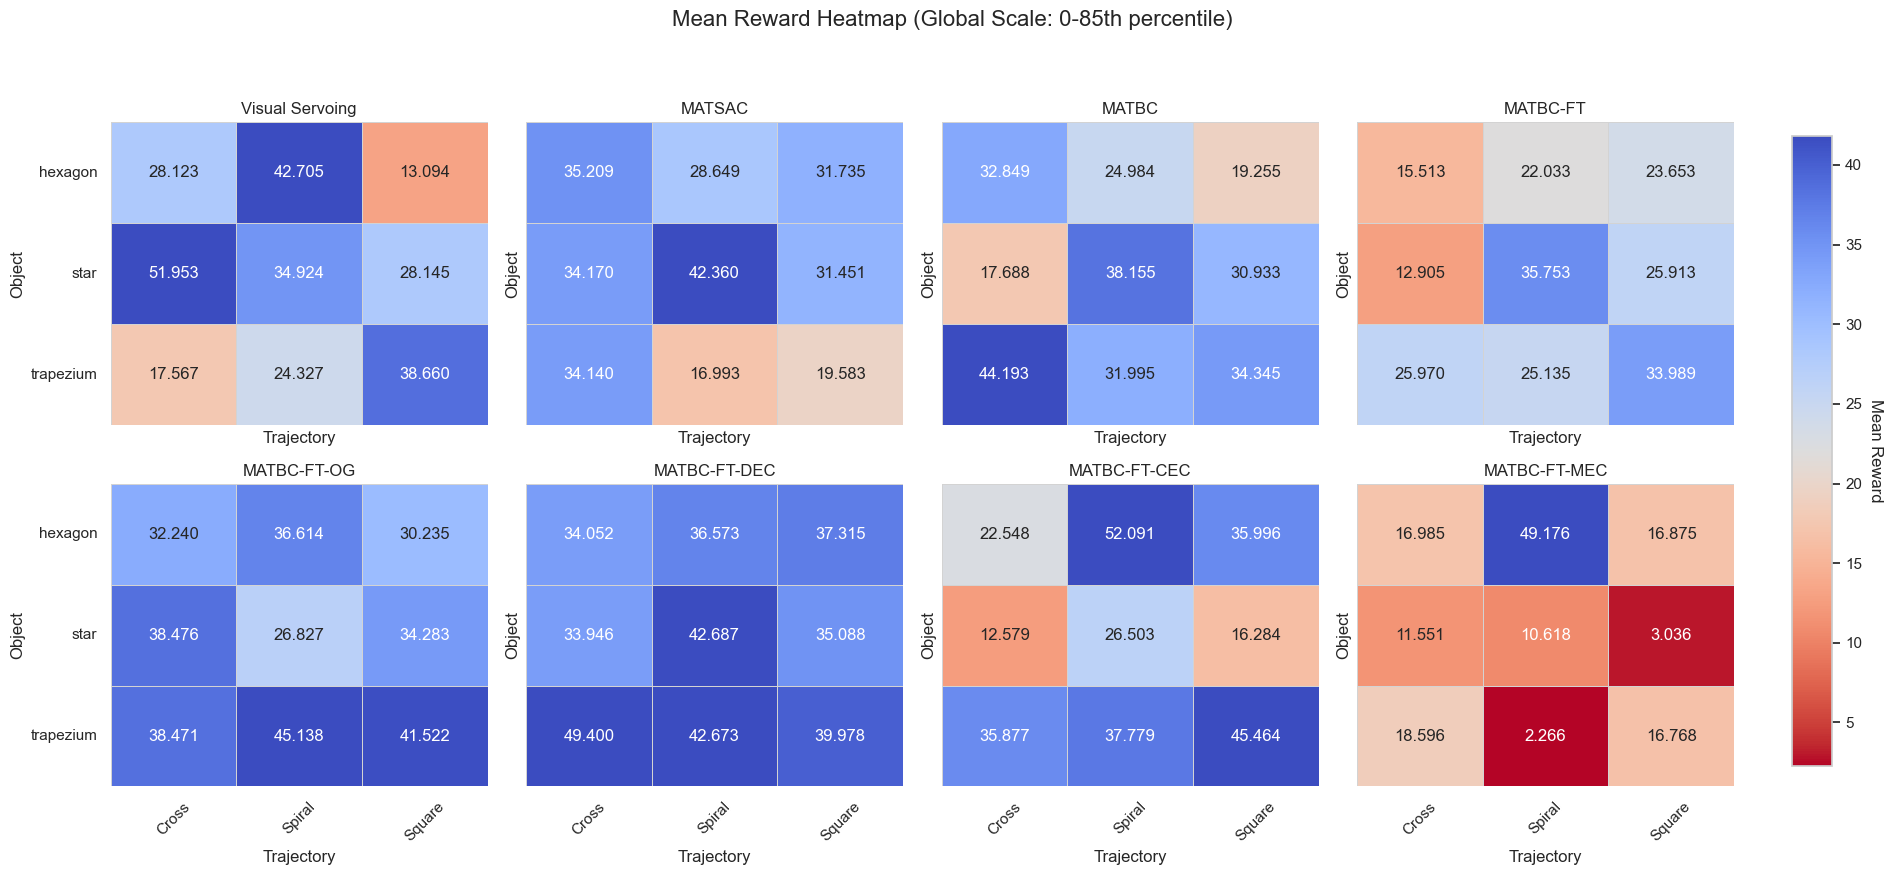

  Processing metric: Mean Error (m)
    Global scale for Mean Error (m): vmin=0.011 (0th), vmax=0.050 (85th)


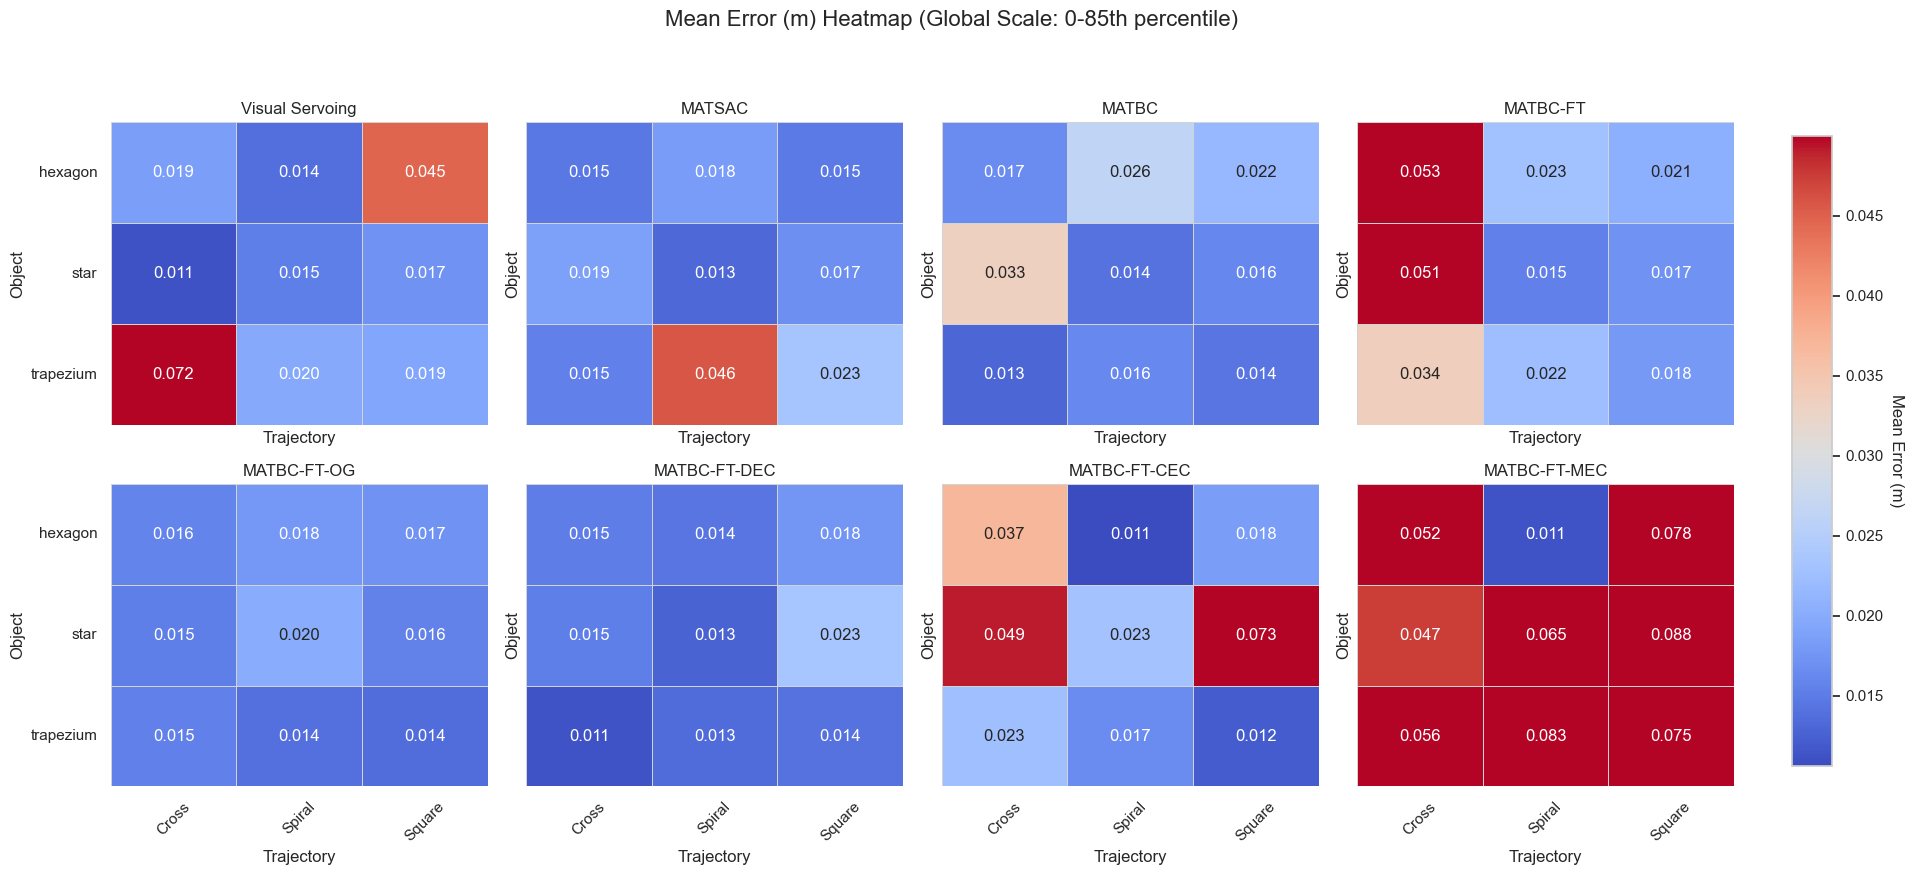

  Processing metric: Robots Used (%)
    Global scale for Robots Used (%): vmin=1.817 (0th), vmax=100.000 (85th)


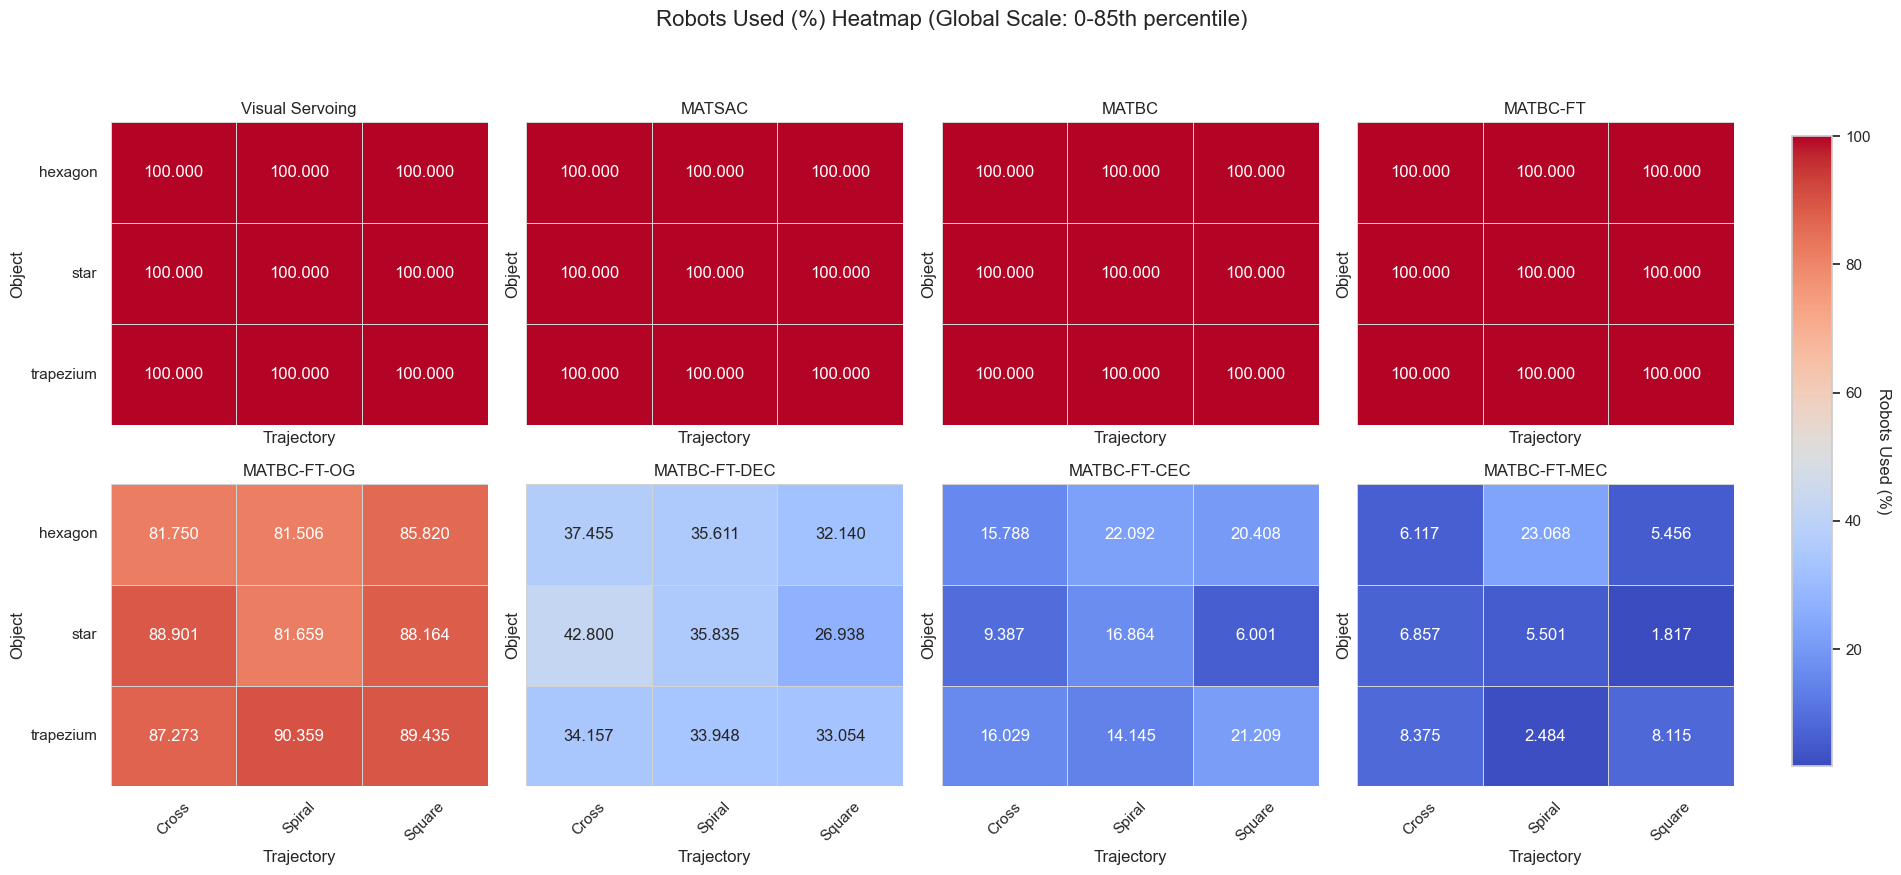

Finished generating heatmaps.
Analysis complete. Check the plots directory for results.

Summary of algorithm performance (Mean Reward):
                     count       mean        std        min        25%  \
Algorithm                                                                
MABC                   9.0  30.488727   8.586658  17.688226  24.984272   
MABC_Finetune          9.0  24.540438   7.443345  12.904736  22.033488   
MABC_Finetune_Bin      9.0  35.978516   5.712574  26.827420  32.239956   
MABC_Finetune_CA       9.0  31.680087  13.191433  12.579417  22.547540   
MABC_Finetune_PB       9.0  39.079117   5.126043  33.945529  35.088467   
MABC_Finetune_PB_CA    9.0  16.207967  13.760351   2.265954  10.618346   
MATSAC                 9.0  30.476533   7.882118  16.993045  28.648788   
Vis Servo              9.0  31.055319  12.308953  13.094327  24.326726   

                           50%        75%        max  
Algorithm                                             
MABC        

In [11]:
import os
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Configuration for the analysis
ALGO_COLORS = {
    'Vis Servo': "#FF5A5F",      
    'MATSAC': "#3498DB",         
    'MABC': "#27AE60",           
    'MABC_Finetune': "#F39C12",  
    'MABC_Finetune_Bin': "#9B59B6",
    'MABC_Finetune_PB': "#2ECC71", 
    'MABC_Finetune_CA': "#E74C3C", 
    'MABC_Finetune_PB_CA': "#1ABC9C"
}
ALGOS = ['Vis Servo', 'MATSAC', "MABC", "MABC_Finetune", "MABC_Finetune_Bin", "MABC_Finetune_PB", "MABC_Finetune_CA", "MABC_Finetune_PB_CA"]
OBJECTS = ['hexagon', 'star', "trapezium"]
TRAJECTORIES = ['snek', 'cross', 'square']  # Based on your traj_name options

ALGO_NAME_MAP = {"Vis Servo": "Visual Servoing","MATSAC": "MATSAC","MABC": "MATBC",
                 "MABC_Finetune": "MATBC-FT","MABC_Finetune_Bin": "MATBC-FT-OG",
                 "MABC_Finetune_PB": "MATBC-FT-DEC","MABC_Finetune_CA": "MATBC-FT-CEC",
                 "MABC_Finetune_PB_CA": "MATBC-FT-MEC"
                }
TRAJ_NAME_MAP = {"snek": "Spiral","cross": "Cross","square": "Square"}
# Directory where pickle files are stored
DATA_DIR = './data/test_traj/'

# Function to extract performance metrics from a pickle file
def extract_metrics(file_path):
    with open(file_path, 'rb') as f:
        data = pkl.load(f)
    
    metrics = {}
    
    # Extract object and trajectory names from the first level of the dictionary
    for obj_name, obj_data in data.items():
        if obj_name not in metrics:
            metrics[obj_name] = {}
        
        # Extract trajectory data
        for traj_name, traj_steps in obj_data.items():
            if traj_name not in metrics[obj_name]:
                metrics[obj_name][traj_name] = {}
            
            # Calculate metrics from the steps
            rewards = [step['reward'] for step in traj_steps]
            distances = [step['dist'] for step in traj_steps]
            robot_counts = [step['robot_count'] for step in traj_steps]
            # action_magnitudes = [np.mean(np.linalg.norm(step['actions'], axis=1)) for step in traj_steps]
            robots_used_percent = []
            run_successful_within_maxtries = 0
            for step in traj_steps:
                actions = step['actions']  # Now actions is defined within the loop
                # Check if actions is a 3D array with x, y, z components
                if len(actions[0]) >= 3:
                    robots_in_contact = np.sum(actions[:, 2] < 0)  # Count robots with z < 0
                    total_robots = len(actions)
                    percent_used = (robots_in_contact / total_robots) * 100 if total_robots > 0 else 0
                    robots_used_percent.append(percent_used)
                else:
                    # If we only have x, y actions, we can't determine contact
                    robots_used_percent.append(100)
            
            # Store aggregated metrics
            metrics[obj_name][traj_name]['mean_reward'] = np.mean(rewards)
            metrics[obj_name][traj_name]['std_reward'] = np.std(rewards)
            metrics[obj_name][traj_name]['mean_distance'] = np.mean(distances)
            metrics[obj_name][traj_name]['std_distance'] = np.std(distances)
            
            metrics[obj_name][traj_name]['robots_used_percent'] = np.mean(robots_used_percent)

            # metrics[obj_name][traj_name]['mean_active_robots'] = np.mean(action_magnitudes)
            metrics[obj_name][traj_name]['mean_robot_count'] = np.mean(robot_counts)
            metrics[obj_name][traj_name]['success_rate'] = sum(1 for r in rewards if r > 70) / 20
    
    return metrics

# Collect all metrics into a DataFrame
def collect_metrics_to_df():
    all_data = []
    
    for algo in ALGOS:
        for obj in OBJECTS:
            for traj in TRAJECTORIES:
                file_name = f"test_traj_{algo}_{traj}_{obj}.pkl"
                file_path = os.path.join(DATA_DIR, file_name)
                
                # Check if the file exists
                if not os.path.exists(file_path):
                    print(f"File not found: {file_path}")
                    continue
                
                metrics = extract_metrics(file_path)
                if metrics and obj in metrics and traj in metrics[obj]:
                    # Add row to our data collection
                    row = {
                        'Algorithm': algo,
                        'Object': obj,
                        'Trajectory': TRAJ_NAME_MAP.get(traj, traj),
                        'Mean Reward': metrics[obj][traj]['mean_reward'],
                        'Success Rate': metrics[obj][traj]['success_rate'],
                        'Mean Error (m)': metrics[obj][traj]['mean_distance'],
                        'Robots Used (%)': metrics[obj][traj]['robots_used_percent'],
                        'Mean Robot Count': metrics[obj][traj]['mean_robot_count'],
                    }
                    all_data.append(row)
    
    # Convert to DataFrame
    return pd.DataFrame(all_data)

# Generate bar plots for each metric
def generate_bar_plots(df, output_dir='./plots/'):
    os.makedirs(output_dir, exist_ok=True)
    sns.set(style="whitegrid")
    algo_color_list = [ALGO_COLORS[algo] for algo in ALGOS]
    custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", algo_color_list)
    
    # Metrics to plot
    metrics = [
        ('Mean Reward', 'Higher is better'),
        ('Success Rate', 'Higher is better'),
        ('Mean Error (m)', 'Lower is better'),
        ('Robots Used (%)', 'Lower is better')
    ]
    
    for metric, subtitle in metrics:
        plt.figure(figsize=(14, 10))
        for i, obj in enumerate(df['Object'].unique()):
            ax = plt.subplot(2, 3, i+1)
            obj_data = df[df['Object'] == obj]
            pivoted = obj_data.pivot(index='Trajectory', columns='Algorithm', values=metric)
            pivoted.plot(kind='bar', ax=ax, rot=0, colormap=custom_cmap, width=0.8)
            
            ax.set_title(f"{obj.capitalize()}", fontsize=14)
            ax.set_ylabel(metric, fontsize=12)
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=8)
            
            for container in ax.containers:
                ax.bar_label(container, fmt='%.2f', fontsize=8)
        
        plt.title(f"{metric} by Object, Trajectory, and Algorithm\n{subtitle}", fontsize=16)
        plt.show()
        # plt.savefig(os.path.join(output_dir, f"{metric.replace(' ', '_').lower()}_comparison.png"), dpi=300, bbox_inches='tight')
        plt.close()
    
    # Also create a summary plot comparing algorithms across all objects
    summary_metrics = ['Mean Error (m)', 'Robots Used (%)', 'Success Rate']
    for metric in summary_metrics:
        plt.figure(figsize=(12, 6))
        algo_summary = df.groupby('Algorithm')[metric].mean().reset_index()
        algo_summary = algo_summary.sort_values(by=metric, ascending=False)
        palette = {algo: ALGO_COLORS[algo] for algo in algo_summary['Algorithm']}
        ax = sns.barplot(data=algo_summary, x='Algorithm', y=metric, palette=palette)
        
        for i, v in enumerate(algo_summary[metric]):
            ax.text(i, v + 0.02 * max(algo_summary[metric]), f"{v:.3f}", 
                    ha='center', va='bottom', fontweight='bold')
        
        plt.title(f"Average {metric} Across All Objects and Trajectories", fontsize=16)
        plt.tight_layout()
        
        # Save the figure
        # add_algorithm_color_legend(plt.gcf())
        plt.show()
        # plt.savefig(os.path.join(output_dir, f"summary_{metric.replace(' ', '_').lower()}.png"), dpi=300, bbox_inches='tight')
        plt.close()

# Generate performance heatmaps
def generate_heatmaps(df, output_dir='./plots/'):
    low_percentile=0
    high_percentile=85
    CMAP_HIGH_BETTER = 'coolwarm_r'
    CMAP_LOW_BETTER = 'coolwarm'
    
    all_algos = df['Algorithm'].unique()
    n_algos = len(all_algos)

    n_cols = min(4, n_algos) # Max 4 columns, fewer if fewer algos
    n_rows = int(np.ceil(n_algos / n_cols))

    metrics_to_plot = []
    if 'Mean Reward' in df.columns:
        metrics_to_plot.append('Mean Reward')
    if 'Mean Error (m)' in df.columns:
        metrics_to_plot.append('Mean Error (m)')
    metrics_to_plot.append('Robots Used (%)')

    if not metrics_to_plot:
        print("Error: DataFrame does not contain 'Mean Reward' or 'Mean Error' columns.")
        return

    print(f"Generating heatmaps for: {', '.join(metrics_to_plot)}")

    for metric in metrics_to_plot:
        print(f"  Processing metric: {metric}")
        # --- 1. Calculate Global Vmin/Vmax using Percentiles ---
        metric_data = df[metric].dropna()
        if not metric_data.empty:
            vmin = np.percentile(metric_data, low_percentile)
            vmax = np.percentile(metric_data, high_percentile)
            # Ensure vmin is strictly less than vmax
            if vmin >= vmax:
                vmin = metric_data.min() # Fallback to min/max if percentiles collapse
                vmax = metric_data.max()
                if vmin == vmax: # Handle case where all values are identical
                   vmin = vmin - 0.1 if vmin != 0 else -0.1
                   vmax = vmax + 0.1 if vmax != 0 else 0.1
            print(f"    Global scale for {metric}: vmin={vmin:.3f} ({low_percentile}th), vmax={vmax:.3f} ({high_percentile}th)")
        else:
            print(f"    Warning: No data found for metric '{metric}'. Skipping heatmaps.")
            continue # Skip this metric if no data

        cmap = CMAP_HIGH_BETTER if 'Reward' in metric else CMAP_LOW_BETTER
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4.5 * n_rows),
                                 squeeze=False, sharex=True, sharey=True) # Share axes if desired
        axes = axes.flatten()
        mappable = None 
        for i, algo in enumerate(all_algos):
            ax = axes[i]
            algo_data = df[df['Algorithm'] == algo]

            # Check if essential columns exist for pivot
            required_cols = ['Object', 'Trajectory', metric]
            if not all(col in algo_data.columns for col in required_cols):
                print(f"    Warning: Missing required columns for pivot in {ALGO_NAME_MAP.get(algo, algo)}. Skipping.")
                ax.set_title(f"{ALGO_NAME_MAP.get(algo, algo)}\n(Missing Data)", fontsize=12)
                ax.set_xticks([])
                ax.set_yticks([])
                continue

            heatmap_data = algo_data.pivot_table(index='Object', columns='Trajectory', values=metric, aggfunc='mean')
            if heatmap_data.empty:
                # print(f"    No heatmap data for {algo}, {metric}.")
                ax.set_title(f"{ALGO_NAME_MAP.get(algo, algo)}\n(No Data)", fontsize=12)
                ax.set_xticks([])
                ax.set_yticks([])
                continue

            hm = sns.heatmap(heatmap_data,annot=True,fmt=".3f",cmap=cmap,vmin=vmin,vmax=vmax,ax=ax,cbar=False,linewidths=0.5,linecolor='lightgray')
            ax.set_title(f"{ALGO_NAME_MAP.get(algo, algo)}", fontsize=12)
            ax.set_xlabel("Trajectory") # Set common labels if needed
            ax.set_ylabel("Object")
            ax.tick_params(axis='y', labelrotation=0)
            ax.tick_params(axis='x', labelrotation=45)
            mappable = hm

        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])
        fig.suptitle(f"{metric} Heatmap (Global Scale: {low_percentile}-{high_percentile}th percentile)", fontsize=16, y=0.99)
        fig.tight_layout(rect=[0.02, 0.02, 0.9, 0.95]) 
        if mappable is not None:
            cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) 
            cbar = fig.colorbar(mappable.collections[0], cax=cbar_ax)
            cbar.set_label(f"{metric}", rotation=270, labelpad=15)

        else:
             print(f"    No data plotted for metric '{metric}', skipping colorbar.")
             
        if output_dir and not os.path.exists(output_dir):
            os.makedirs(output_dir)
            print(f"Created output directory: {output_dir}")

        if output_dir:
            save_path = os.path.join(output_dir, f"heatmap_{metric.replace(' ', '_').lower()}_global_scale.png")
            plt.savefig(save_path, dpi=300) 

        plt.show()
        plt.close(fig) # Explicitly close the figure

    print("Finished generating heatmaps.")
        
def add_algorithm_color_legend(fig):
    """Add a small legend showing algorithm colors"""
    ax = fig.add_axes([0.85, 0.15, 0.1, 0.3])  # Position the legend
    ax.axis('off')
    
    # Add color patches
    for i, algo in enumerate(ALGOS):
        if algo in ALGO_COLORS:
            ax.add_patch(plt.Rectangle((0, i*0.1), 0.2, 0.08, color=ALGO_COLORS[algo]))
            ax.text(0.25, i*0.1+0.04, algo, fontsize=8)
    
    ax.set_title('Algorithm Colors', fontsize=10)
    
# Main function to run the analysis
def main():
    print("Collecting metrics from pickle files...")
    metrics_df = collect_metrics_to_df()
    if metrics_df.empty:
        print("No data found. Check file paths and try again.")
        return
    print(f"Found data for {len(metrics_df)} algorithm-object-trajectory combinations.")
    # print("Generating bar plots...")
    # generate_bar_plots(metrics_df)
    print("Generating heatmaps...")
    generate_heatmaps(metrics_df)
    print("Analysis complete. Check the plots directory for results.")
    return metrics_df

if __name__ == "__main__":
    
    df = main()
    
    # Print a summary table
    print("\nSummary of algorithm performance (Mean Reward):")
    summary = df.groupby('Algorithm')['Mean Reward'].describe()
    print(summary)
    
    # Check which algorithm performs best for each object
    print("\nBest algorithm for each object (based on Mean Reward):")
    best_by_obj = df.loc[df.groupby('Object')['Mean Reward'].idxmax()]
    print(best_by_obj[['Object', 'Algorithm', 'Mean Reward']])

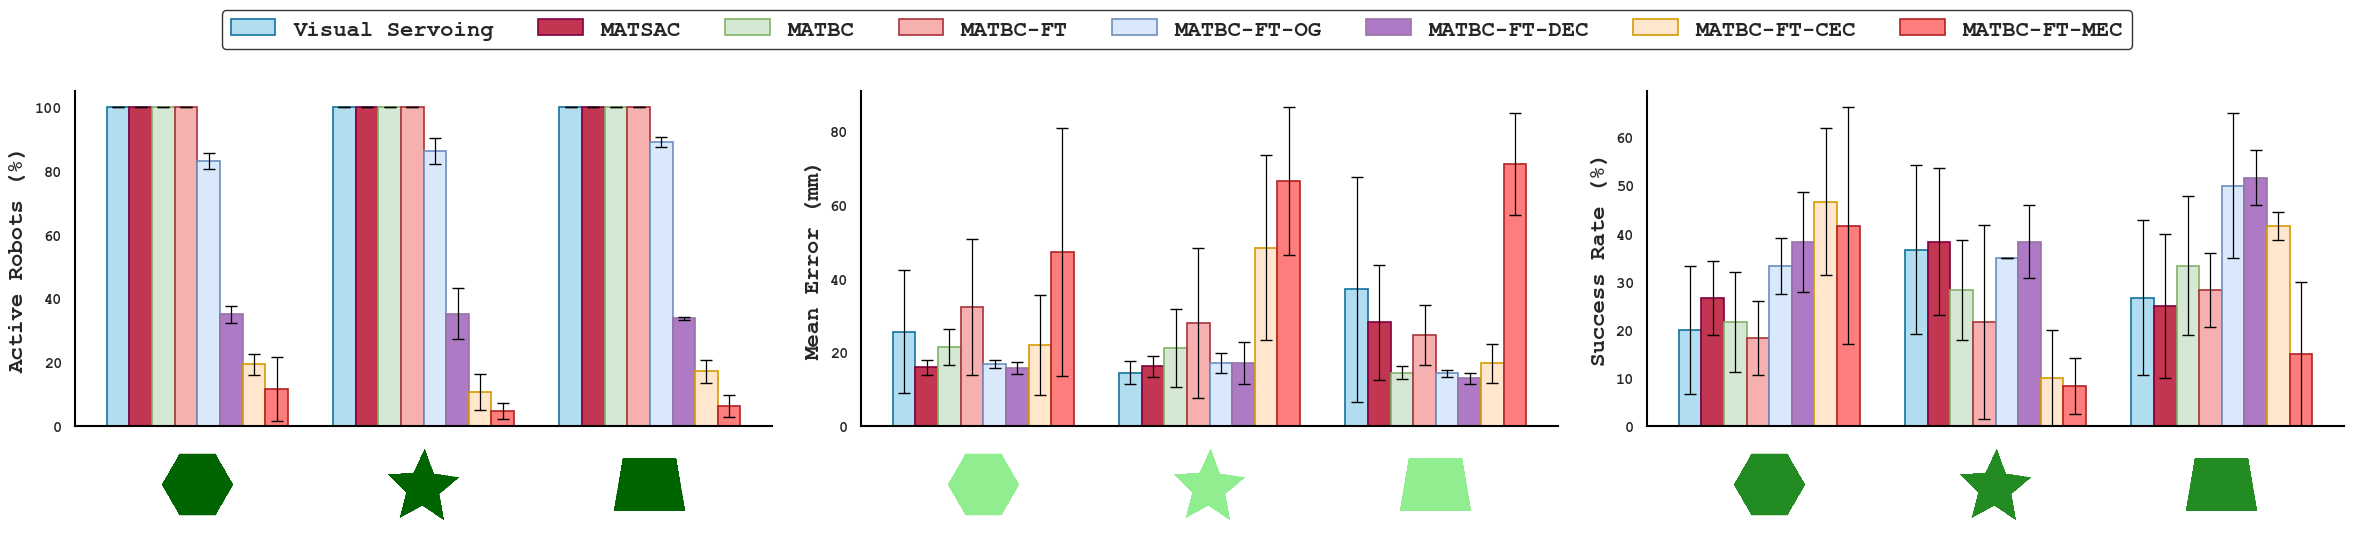

In [32]:
import os
import pickle
import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from matplotlib.patches import Rectangle
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# --- 1) Configuration & Constants ---
DATA_DIR   = './data/test_traj/'
ICONS_DIR  = './config/assets/icons/'

OBJ_NAMES         = ['hexagon', 'star', 'trapezium']
ALGOS_ORDER       = [
    'Vis Servo','MATSAC','MABC','MABC_Finetune',
    'MABC_Finetune_Bin','MABC_Finetune_PB',
    'MABC_Finetune_CA','MABC_Finetune_PB_CA'
]
ALGO_NAME_MAP = {
    "Vis Servo": "Visual Servoing","MATSAC": "MATSAC","MABC": "MATBC",
    "MABC_Finetune": "MATBC-FT","MABC_Finetune_Bin": "MATBC-FT-OG",
    "MABC_Finetune_PB": "MATBC-FT-DEC","MABC_Finetune_CA": "MATBC-FT-CEC",
    "MABC_Finetune_PB_CA": "MATBC-FT-MEC"
}

GLOBAL_FONT_FAMILY = "Courier New"
GLOBAL_FONT_WEIGHT = "bold"
GLOBAL_FONT_SIZE   = 22
plt.rcParams.update({
    'axes.edgecolor': 'black',
    'axes.linewidth': 1.5,
    'grid.color': '#CCCCCC',
    'grid.linestyle': '-',
    'grid.linewidth': 0.5,
    'font.family': GLOBAL_FONT_FAMILY,
    'font.weight': GLOBAL_FONT_WEIGHT,
    'font.size': GLOBAL_FONT_SIZE
})

FINAL_PALETTE = ['#B1DDF0','#C33651','#d5e8d4','#F7B0B0','#dae8fc','#AF7AC5','#FFE6CC','#FD7C7C']
EDGE_COLORS   = ['#10739e','#800040','#82b366','#A8323A','#6c8ebf','#9673a6','#d79b00','#B22222']

# Load & sort icons
all_icons = glob.glob(os.path.join(ICONS_DIR, '*.png'))
def get_sort_index(path):
    for i, obj in enumerate(OBJ_NAMES):
        if obj in path:
            return i
    return len(OBJ_NAMES)

icons_dark   = sorted([p for p in all_icons if 'dark'   in p], key=get_sort_index)[:len(OBJ_NAMES)]
icons_light  = sorted([p for p in all_icons if 'light'  in p], key=get_sort_index)[:len(OBJ_NAMES)]
icons_medium = sorted([p for p in all_icons if 'medium' in p], key=get_sort_index)[:len(OBJ_NAMES)]

# Data extraction
def extract_metrics(pkl_path):
    try:
        with open(pkl_path,'rb') as f:
            data = pickle.load(f)
    except:
        return {}
    mets = {}
    for obj, trajs in data.items():
        for traj, steps in trajs.items():
            if not steps: continue
            rewards = [s.get('reward', np.nan) for s in steps]
            dists   = [s.get('dist', np.nan)*1000 for s in steps]
            used    = []
            for s in steps:
                act = s.get('actions')
                n   = s.get('robot_count', 0)
                if len(act[0])==3 and n > 0:
                    used.append(np.sum(act[:,2] < 0) / n * 100)
                elif n > 0:
                    used.append(100.)
            success = sum(1 for r in rewards if r > 70)
            mets.setdefault(obj, {})[traj] = {
                'Robots Used (%)': np.mean(used) if used else np.nan,
                'Mean Error'     : np.mean(dists) if dists else np.nan,
                'Success Rate'   : success / 20 * 100
            }
    return mets

def collect_df():
    rows = []
    for algo in ALGOS_ORDER:
        for obj in OBJ_NAMES:
            for traj in ['snek','cross','square']:
                fn = f"test_traj_{algo}_{traj}_{obj}.pkl"
                path = os.path.join(DATA_DIR, fn)
                if not os.path.exists(path):
                    continue
                mets = extract_metrics(path).get(obj, {}).get(traj, None)
                if mets is None:
                    continue
                rows.append(dict(Algorithm=algo, Object=obj, **mets))
    return pd.DataFrame(rows)

df = collect_df()

object_df = df.groupby(['Object','Algorithm']).agg(['mean','std'])
object_df.columns = [
    'Robots Used (%)','Std Robots Used',
    'Mean Error','Std Mean Error',
    'Success Rate','Std Success Rate'
]
object_df = object_df.reset_index()

# Plotting on subplots
def plot_metric(ax, data_df, metric_col, error_col, y_label, obj_icons):
    # filter & prepare
    df = data_df[data_df['Object'].isin(OBJ_NAMES)].copy()
    df[error_col] = df[error_col].fillna(0)
    top = (df[metric_col] + df[error_col]).max() * 1.05

    # grouped barplot
    sns.barplot(
        x='Object', y=metric_col, hue='Algorithm', data=df,
        palette=FINAL_PALETTE[:len(ALGOS_ORDER)],
        order=OBJ_NAMES, hue_order=ALGOS_ORDER,
        ax=ax, linewidth=0, saturation=1, errorbar=None
    )
    if ax.get_legend():
        ax.get_legend().remove()
    # colored edges
    for hi, container in enumerate(ax.containers):
        ec = EDGE_COLORS[hi]
        for bar in container:
            bar.set_edgecolor(ec)
            bar.set_linewidth(1.2)

    # custom errorbars
    plot_df = (
        df.assign(
            Algorithm=pd.Categorical(df['Algorithm'], categories=ALGOS_ORDER, ordered=True),
            Object   =pd.Categorical(df['Object'],    categories=OBJ_NAMES,   ordered=True)
        )
        .sort_values(['Algorithm','Object'])
        .reset_index(drop=True)
    )
    for bar, (_, row) in zip(ax.patches, plot_df.iterrows()):
        xc = bar.get_x() + bar.get_width()/2
        ax.errorbar(
            xc, row[metric_col], yerr=row[error_col],
            fmt='none', ecolor='black', elinewidth=0.9, capsize=4
        )

    # styling
    ax.set_xlabel('')
    ax.set_ylabel(y_label, fontsize=16, fontweight='bold')
    ax.set_xticklabels([])
    ax.set_ylim(0, top)
    ax.grid(axis='y')
    sns.despine(ax=ax)

    # icons
    for x, icon_path in enumerate(obj_icons):
        try:
            img = cv2.imread(icon_path)
            im = OffsetImage(img, zoom=0.25)
            ab = AnnotationBbox(
                im, (x,0), xybox=(0,-10),
                xycoords=('data','axes fraction'),
                boxcoords='offset points',
                box_alignment=(0.5,1),
                frameon=False
            )
            ax.add_artist(ab)
        except Exception:
            pass

# create a 1×3 grid of axes
fig, axs = plt.subplots(1, 3, figsize=(24, 6), sharey=False)

# plot each metric on its own subplot
plot_metric( axs[0], object_df,
             'Robots Used (%)','Std Robots Used',
             'Active Robots (%)', icons_dark )

plot_metric( axs[1], object_df,
             'Mean Error','Std Mean Error',
             'Mean Error (mm)', icons_light )

plot_metric( axs[2], object_df,
             'Success Rate','Std Success Rate',
             'Success Rate (%)', icons_medium )

# build a single legend up top
handles = [
    Rectangle((0,0),1,1,
              facecolor=FINAL_PALETTE[i],
              edgecolor=EDGE_COLORS[i],
              linewidth=1.2)
    for i in range(len(ALGOS_ORDER))
]
labels = [ALGO_NAME_MAP[a] for a in ALGOS_ORDER]
fig.legend(
    handles, labels,
    loc='upper center', ncol=8,
    frameon=True, edgecolor='black', fontsize=16
)

plt.tight_layout(rect=[0, 0.05, 1, 0.90])
os.makedirs('plots', exist_ok=True)
fig.savefig('plots/real_summary.png', dpi=300, bbox_inches='tight')
plt.show()

Applying global plot styles...
Successfully set font to: Courier New
Looking for data files in: /home/nagababa/Sarvesh/Research/dexterous-manipulation-delta-arrays/Delta_Array_MJX/data/test_traj

Found 72 files, successfully processed 72 files.

Real-world data collected. Shape: (72, 8)
   Algorithm   Object Trajectory  Mean Reward  Success Rate  Mean Error  \
0  Vis Servo  hexagon       snek    42.704992          25.0   13.789407   
1  Vis Servo  hexagon      cross    28.123460          30.0   18.549106   
2  Vis Servo  hexagon     square    13.094327           5.0   44.635910   
3  Vis Servo     star       snek    34.923610          35.0   15.246228   
4  Vis Servo     star      cross    51.952639          55.0   11.135872   

   Robots Used (%)  Mean Robot Count  
0            100.0          8.117647  
1            100.0          7.604167  
2            100.0          7.442308  
3            100.0          8.600000  
4            100.0          9.533333  
Generating styled summary b

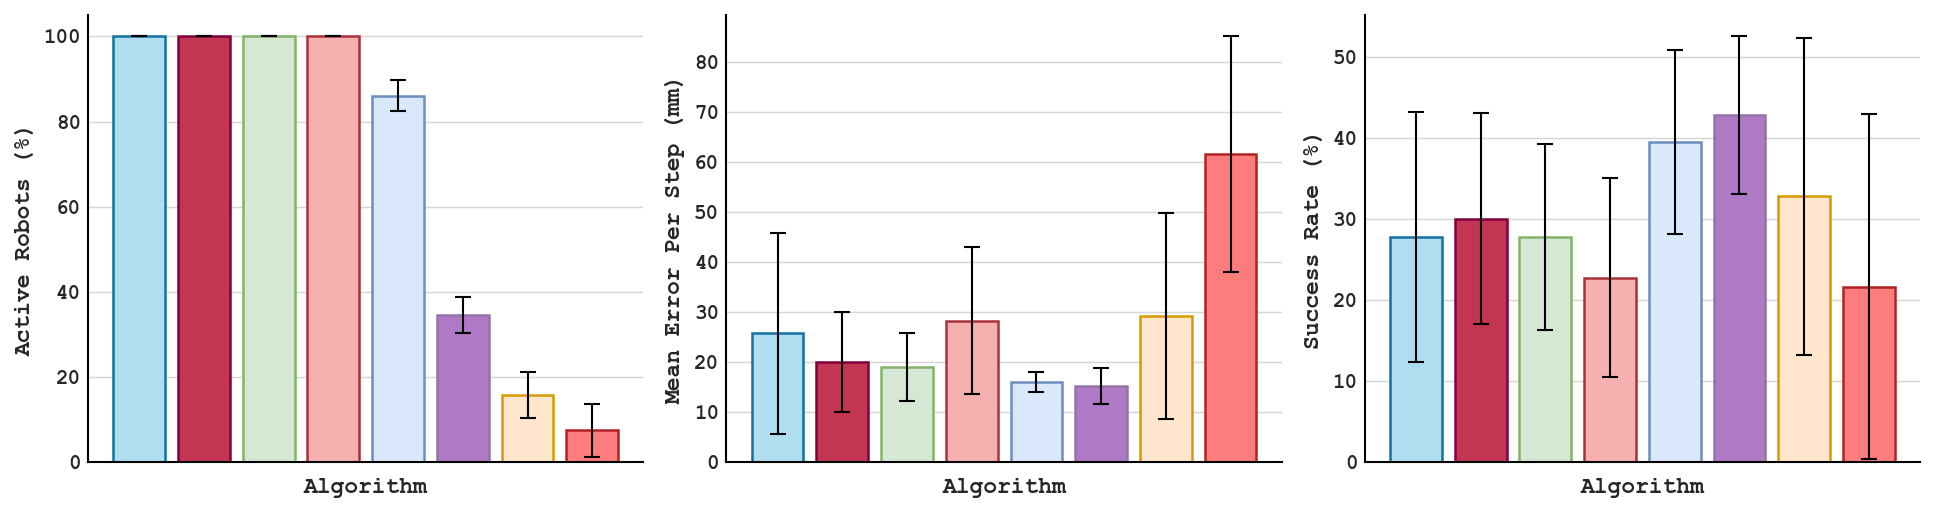


Analysis complete. Check the plots directory for styled summary results.

--- Real-World Data Summary ---

Summary by Algorithm (Mean over Objects/Trajectories):
                     Mean_Reward  Success_Rate  Mean_Error_mm  Robots_Used_Perc
Algorithm                                                                      
Vis Servo                 31.055        27.778         25.758           100.000
MATSAC                    30.477        30.000         20.099           100.000
MABC                      30.489        27.778         19.059           100.000
MABC_Finetune             24.540        22.778         28.322           100.000
MABC_Finetune_Bin         35.979        39.444         16.101            86.096
MABC_Finetune_PB          39.079        42.778         15.289            34.660
MABC_Finetune_CA          31.680        32.778         29.194            15.769
MABC_Finetune_PB_CA       16.208        21.667         61.636             7.532


In [ ]:

import os
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from collections import defaultdict # Keep if used in aggregation
# Import necessary for manual legend handles
from matplotlib.patches import Rectangle
from glob import glob
icons = glob('./config/assets/icons/*.png')

def get_sort_index(icon_name):
    for idx, obj in enumerate(OBJ_NAMES):
        if obj in icon_name:
            return idx
    return len(OBJ_NAMES)

icons_sorted = sorted([icon for icon in icons if "dark" in icon], key=get_sort_index)
obj_icons_0 = sorted([icon for icon in icons if "dark" in icon], key=get_sort_index)
obj_icons_1 = sorted([icon for icon in icons if "light" in icon], key=get_sort_index)
obj_icons_2 = sorted([icon for icon in icons if "medium" in icon], key=get_sort_index)
GLOBAL_FONT_FAMILY = "Courier New" # Use 'monospace' or 'sans-serif' for portability
GLOBAL_FONT_WEIGHT = "bold"       # 'normal', 'bold'
GLOBAL_FONT_SIZE   = 26           # Base size in points

# --- Configuration and Constants ---
# Use the Algorithm order relevant for THIS dataset (real-world)
# Ensure this list matches the algorithms present in your real-world data files
ALGOS_ORDER_REAL = [
    'Vis Servo', 'MATSAC', "MABC", "MABC_Finetune", "MABC_Finetune_Bin",
    "MABC_Finetune_PB", "MABC_Finetune_CA", "MABC_Finetune_PB_CA"
]
ALGO_NAME_MAP = {"Vis Servo": "Visual Servoing","MATSAC": "MATSAC","MABC": "MATBC",
                 "MABC_Finetune": "MATBC-FT","MABC_Finetune_Bin": "MATBC-FT-OG",
                 "MABC_Finetune_PB": "MATBC-FT-DEC","MABC_Finetune_CA": "MATBC-FT-CEC",
                 "MABC_Finetune_PB_CA": "MATBC-FT-MEC"
                }
TRAJ_NAME_MAP = {"snek": "Spiral","cross": "Cross","square": "Square"}

OBJECTS = ['hexagon', 'star', "trapezium"] # Real-world objects
TRAJECTORIES = ['snek', 'cross', 'square'] # Real-world trajectories
DATA_DIR = './data/test_traj/' # Adjust if needed

final_palette = ['#B1DDF0', '#C33651', '#d5e8d4', '#F7B0B0', "#dae8fc", '#AF7AC5', '#FFE6CC', '#FD7C7C']
# Edge colors
edge_colors =   ['#10739e', '#800040', '#82b366', '#A8323A', "#6c8ebf", '#9673a6', "#d79b00", '#B22222']
# --- Palettes and Font Settings (Adopted from Script 1 Styling) ---
# Base palettes from Script 1
_final_palette_base = ['#B1DDF0', '#C33651', '#d5e8d4', '#F7B0B0', "#dae8fc", '#AF7AC5', '#FFE6CC', '#FD7C7C']
_edge_colors_base =   ['#10739e', '#800040', '#82b366', '#A8323A', "#6c8ebf", '#9673a6', "#d79b00", '#B22222']

# Adapt palettes to the number of algorithms in THIS script's order
num_algos_real = len(ALGOS_ORDER_REAL)
final_palette_real = _final_palette_base[:num_algos_real]
edge_colors_real = _edge_colors_base[:num_algos_real]

# Handle potential mismatch in number of algorithms vs palette length
if len(final_palette_real) < num_algos_real:
     print(f"Warning: Script 1 palette length ({len(_final_palette_base)}) is less than the number of real-world algorithms ({num_algos_real}). Recycling colors.")
     final_palette_real = [ _final_palette_base[i % len(_final_palette_base)] for i in range(num_algos_real) ]
     edge_colors_real = [ _edge_colors_base[i % len(_edge_colors_base)] for i in range(num_algos_real) ]
elif len(final_palette_real) > num_algos_real:
     print(f"Warning: Script 1 palette length ({len(_final_palette_base)}) is greater than the number of real-world algorithms ({num_algos_real}). Truncating palettes.")
     # Already truncated by slicing, this is just a confirmation message.


# Font Settings from Script 1
# GLOBAL_FONT_FAMILY = "Courier New"
# GLOBAL_FONT_WEIGHT = "bold"
# GLOBAL_FONT_SIZE   = 10

# --- Apply rcParams for Global Styling ---
# Apply styling BEFORE creating plots
print("Applying global plot styles...")
try:
    # Set rcParams similar to Script 1
    plt.style.use('seaborn-v0_8-whitegrid') # Base style
    plt.rcParams.update({
        'axes.edgecolor': 'black', 'axes.linewidth': 1.0,
        'grid.color': '#CCCCCC', 'grid.linestyle': '-', 'grid.linewidth': 0.5,
        'font.family': GLOBAL_FONT_FAMILY,
        'font.weight': GLOBAL_FONT_WEIGHT,
        'font.size': GLOBAL_FONT_SIZE,
        'axes.labelsize': GLOBAL_FONT_SIZE * 1.1, # Slightly larger axis labels
        'axes.labelweight': GLOBAL_FONT_WEIGHT,
        'xtick.labelsize': GLOBAL_FONT_SIZE,
        'ytick.labelsize': GLOBAL_FONT_SIZE,
        'legend.fontsize': GLOBAL_FONT_SIZE * 0.9, # Slightly smaller legend
        'figure.dpi': 150, # Screen DPI
        'savefig.dpi': 300 # Save DPI
    })
    # Optional: Test font availability (as in script 1)
    fig_dummy, ax_dummy = plt.subplots(figsize=(0.1,0.1)); ax_dummy.text(0.5, 0.5, 'test', fontname=GLOBAL_FONT_FAMILY); plt.close(fig_dummy)
    print(f"Successfully set font to: {GLOBAL_FONT_FAMILY}")
except Exception as e:
    print(f"Warning: Font '{GLOBAL_FONT_FAMILY}' not found or error: {e}. Falling back to 'monospace'.")
    GLOBAL_FONT_FAMILY = 'monospace'
    plt.rcParams['font.family'] = GLOBAL_FONT_FAMILY


# --- Data Loading and Processing Functions (Keep from Script 2) ---
def extract_metrics(file_path):
    try:
        with open(file_path, 'rb') as f:
            data = pkl.load(f)
    except FileNotFoundError:
        # print(f"File not found during metric extraction: {file_path}")
        return None
    except Exception as e:
        print(f"Error loading pickle file {file_path}: {e}")
        return None

    metrics = {}
    for obj_name, obj_data in data.items():
        if obj_name not in metrics: metrics[obj_name] = {}
        for traj_name, traj_steps in obj_data.items():
            if not traj_steps: continue # Skip empty trajectory data
            if traj_name not in metrics[obj_name]: metrics[obj_name][traj_name] = {}

            rewards = [step['reward'] for step in traj_steps if 'reward' in step]
            distances = [step['dist'] * 1000 for step in traj_steps if 'dist' in step] # Convert m to mm if desired
            robots_used_percent = []
            robot_counts = []
            successes = 0
            total_traj_runs = len(traj_steps) # Or determine number of runs differently if needed

            for step in traj_steps:
                 # Calculate % Robots Used
                actions = step.get('actions')
                n_robots = step.get('robot_count', 0)
                robot_counts.append(n_robots)
                if isinstance(actions, np.ndarray) and actions.ndim == 2 and actions.shape[1] >= 3 and n_robots > 0:
                    robots_in_contact = np.sum(actions[:, 2] < 0)
                    percent_used = (robots_in_contact / n_robots) * 100
                    robots_used_percent.append(percent_used)
                elif n_robots > 0: # Assume all used if actions format is different or missing
                    robots_used_percent.append(100.0)

                 # Check success (adjust threshold if needed)
                if step.get('reward', -np.inf) > 70: # Use 70 as threshold example
                     successes += 1

            metrics[obj_name][traj_name]['mean_reward'] = np.mean(rewards) if rewards else np.nan
            metrics[obj_name][traj_name]['mean_distance'] = np.mean(distances) if distances else np.nan
            metrics[obj_name][traj_name]['robots_used_percent'] = np.mean(robots_used_percent) if robots_used_percent else np.nan
            metrics[obj_name][traj_name]['mean_robot_count'] = np.mean(robot_counts) if robot_counts else np.nan
            # Success rate calculation might need refinement based on definition (per step? per trajectory run?)
            # Assuming success rate per trajectory run (requires knowing run structure)
            # Placeholder: using average reward > threshold as proxy if run structure unknown
            metrics[obj_name][traj_name]['success_rate'] = np.sum([1 for r in rewards if r > 70 ])/20
            # If you have a known number of trials (e.g., 20) per file, use:
            # metrics[obj_name][traj_name]['success_rate'] = successes / 20.0

    # Flatten the nested dict if needed, or return as is if collect_metrics_to_df handles it
    return metrics


def collect_metrics_to_df():
    all_data = []
    print(f"Looking for data files in: {os.path.abspath(DATA_DIR)}")
    found_files = 0
    processed_files = 0

    for algo in ALGOS_ORDER_REAL: # Use the order defined for this script
        for obj in OBJECTS:
            for traj in TRAJECTORIES:
                file_name = f"test_traj_{algo}_{traj}_{obj}.pkl"
                file_path = os.path.join(DATA_DIR, file_name)

                if not os.path.exists(file_path):
                    print(f"File not found: {file_path}") # Verbose
                    continue # Skip if file doesn't exist

                found_files += 1
                metrics_extracted = extract_metrics(file_path)
                if metrics_extracted:
                    processed_files += 1
                    for obj_name_extracted, obj_data in metrics_extracted.items():
                        for traj_name_extracted, traj_metrics in obj_data.items():
                             if obj_name_extracted == obj and traj_name_extracted == traj:
                                row = {
                                    'Algorithm': algo,
                                    'Object': obj,
                                    'Trajectory': traj,
                                    'Mean Reward': traj_metrics.get('mean_reward', np.nan),
                                    'Success Rate': 100*traj_metrics.get('success_rate', np.nan),
                                    'Mean Error': traj_metrics.get('mean_distance', np.nan), # Use mm if converted in extract_metrics
                                    'Robots Used (%)': traj_metrics.get('robots_used_percent', np.nan),
                                    'Mean Robot Count': traj_metrics.get('mean_robot_count', np.nan),
                                }
                                all_data.append(row)

    if found_files == 0:
         print("\nERROR: No data files were found. Please check DATA_DIR and filename patterns.")
    elif processed_files == 0:
         print("\nERROR: Files were found, but no metrics could be extracted. Check file contents and extract_metrics function.")
    else:
         print(f"\nFound {found_files} files, successfully processed {processed_files} files.")

    return pd.DataFrame(all_data)


# --- NEW Plotting Function (Replicating Script 1 Style) ---
def generate_summary_bar_plots_styled(df, output_dir='./plots/'):
    """
    Generates a 1x3 summary bar plot for real-world data, mimicking
    the style of the simulation plots (Script 1).
    """
    if df.empty:
        print("DataFrame is empty. Cannot generate summary plots.")
        return

    os.makedirs(output_dir, exist_ok=True)
    summary_metrics = ['Robots Used (%)', 'Mean Error', 'Success Rate']
    y_labels = { # Map metric names to desired Y-axis labels
        'Robots Used (%)': 'Active Robots (%)',
        'Mean Error': 'Mean Error Per Step (mm)',
        'Success Rate': 'Success Rate (%)'
    }

    # Verify required metric columns exist
    missing_metrics = [m for m in summary_metrics if m not in df.columns]
    if missing_metrics:
        print(f"Error: DataFrame missing required metrics for summary plot: {missing_metrics}")
        print(f"Available columns: {df.columns.tolist()}")
        return

    # --- Create Figure with 1x3 Subplots ---
    fig, axes = plt.subplots(1, 3, figsize=(13, 4), sharey=False) # Adjust figsize as needed
    if len(summary_metrics) != 3: # Adjust if fewer/more than 3 metrics
        fig, axes = plt.subplots(1, len(summary_metrics), figsize=(4.5 * len(summary_metrics), 4), sharey=False)
        axes = np.array(axes).flatten() # Ensure axes is always iterable

    legend_handles = None # Initialize

    print("Generating styled summary bar plots for real-world data...")
    for i, metric in enumerate(summary_metrics):
        if i >= len(axes): break # Avoid index error if fewer axes than metrics
        ax = axes[i]
        y_label = y_labels.get(metric, metric)

        algo_summary_agg = df.groupby('Algorithm')[metric].agg(['mean', 'std'])
        algo_summary_agg = algo_summary_agg.reindex(ALGOS_ORDER_REAL)
        y_values = algo_summary_agg['mean'].values
        y_errors = algo_summary_agg['std'].fillna(0).values
        plot_df_mean = algo_summary_agg[['mean']].reset_index().rename(columns={'mean': metric})
        # algo_summary = df.groupby('Algorithm')[metric].mean()
        # algo_summary = algo_summary.reindex(ALGOS_ORDER_REAL) # Ensure correct order & includes all algos
        # algo_summary = algo_summary.reset_index()

        sns.barplot(x='Algorithm', y=metric, data=plot_df_mean,
                    order=ALGOS_ORDER_REAL,
                    hue='Algorithm', hue_order=ALGOS_ORDER_REAL,
                    palette=final_palette_real, ax=ax,
                    linewidth=0, saturation=1, errorbar=None,
                    dodge=False)

        num_bars_expected = len(ALGOS_ORDER_REAL)
        num_containers = len(ax.containers)
        applied_edges = 0

        # Check if containers match algorithms (most likely scenario with dodge=False)
        if num_containers == num_bars_expected:
             for algo_idx, container in enumerate(ax.containers):
                  if algo_idx < len(edge_colors_real):
                      ec = edge_colors_real[algo_idx]
                      # There should be only one bar per container in this setup
                      if container.patches:
                           bar = container.patches[0]
                           bar.set_edgecolor(ec)
                           bar.set_linewidth(1.2)
                           applied_edges += 1
                  else:
                      print(f"Warning: Not enough edge colors for algorithm index {algo_idx}")
        elif num_containers == 1 and len(ax.containers[0].patches) == num_bars_expected:
            # Fallback: Sometimes seaborn puts all bars in one container
            print(f"Info: Found {len(ax.containers[0].patches)} bars in a single container for metric '{metric}'. Applying edges sequentially.")
            container = ax.containers[0]
            for patch_idx, bar in enumerate(container.patches):
                 if patch_idx < len(edge_colors_real):
                     ec = edge_colors_real[patch_idx]
                     bar.set_edgecolor(ec)
                     bar.set_linewidth(1.2)
                     applied_edges +=1
                 else:
                      print(f"Warning: Not enough edge colors for bar index {patch_idx}")
        else:
             print(f"Warning: Unexpected container structure ({num_containers} containers) for metric '{metric}'. Edge colors may be wrong.")

        x_centers = np.arange(len(ALGOS_ORDER_REAL))

        # Plot error bars only for non-NaN y_values
        valid_mask = ~np.isnan(y_values)
        if np.any(valid_mask): # Check if there is any valid data to plot
            ax.errorbar(
                x=x_centers[valid_mask],
                y=y_values[valid_mask],
                yerr=y_errors[valid_mask],
                fmt='none',           # No line connecting points
                ecolor='black',       # Error bar color
                elinewidth=1.0,       # Thickness of error bar lines
                capsize=4,            # Size of the T-caps
                capthick=1.0,         # Thickness of the T-cap lines
                zorder=5              # Draw on top of bars
            )

        if applied_edges != num_bars_expected:
             print(f"Warning: Applied edge colors to {applied_edges}/{num_bars_expected} bars for metric '{metric}'.")


        # --- Customize axes (like script 1) ---
        ax.set_ylabel(y_label) # Uses global font settings from rcParams
        # ax.set_xlabel(None)
        ax.set_title(None)
        ax.set_xticklabels([])
        ax.tick_params(axis='x', bottom=False)
        # Y-tick labels use global font size

        ax.grid(axis='y', visible=True, linestyle='-', linewidth=0.7, color='#cccccc', alpha=0.8)
        ax.grid(axis='x', visible=False)
        sns.despine(ax=ax)

        # --- Capture Legend Handles (Manual approach like script 1) ---
        if i == 0: # Only need handles from the first plot
            display_labels = [ALGO_NAME_MAP.get(algo, algo) for algo in ALGOS_ORDER_REAL]
            handles = [Rectangle((0,0),1,1, facecolor=final_palette_real[j], edgecolor=edge_colors_real[j], linewidth=1.2)
                       for j in range(len(ALGOS_ORDER_REAL))]
            labels = display_labels
            legend_handles = handles

    # --- Add Common Legend (like script 1) ---
    # if legend_handles:
    #     fig.legend(handles=legend_handles, labels=labels,
    #                loc='upper center',
    #                bbox_to_anchor=(0.5, 1.0), # Adjust vertical position as needed
    #                ncol=min(len(ALGOS_ORDER_REAL), 8), # Limit columns
    #                frameon=True, edgecolor='black', facecolor='white',
    #                title='Algorithm', title_fontproperties={'size': GLOBAL_FONT_SIZE, 'weight': GLOBAL_FONT_WEIGHT}) # Use global font
    # else:
    #     print("Warning: Could not generate legend handles.")

    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 1, 0.88]) # Adjust top margin tighter for legend

    # --- Save ---
    save_filename = "real_results.png"
    save_path = os.path.join(output_dir, save_filename)
    print(f"Saving styled summary plot to {save_path}")
    try:
        plt.savefig(save_path) # dpi from rcParams
        plt.savefig(os.path.join(output_dir, "real_results.pdf"))
    except Exception as e:
        print(f"Error saving plot: {e}")

    plt.show()
    plt.close(fig) # Close the figure


# --- Main function ---
def main():
    print("Collecting metrics from real-world pickle files...")
    metrics_df_real = collect_metrics_to_df()

    if metrics_df_real.empty:
        print("\nNo real-world data processed. Exiting.")
        return

    print(f"\nReal-world data collected. Shape: {metrics_df_real.shape}")
    print(metrics_df_real.head())

    # --- Call the NEW styled summary plot function ---
    # Ensure the DataFrame has the expected columns before passing
    generate_summary_bar_plots_styled(metrics_df_real)

    # --- The old generate_bar_plots and generate_heatmaps are NOT called ---

    print("\nAnalysis complete. Check the plots directory for styled summary results.")
    return metrics_df_real

if __name__ == "__main__":
    df_real = main()

    # Optional: Print summary tables for the real-world data
    if df_real is not None and not df_real.empty:
        print("\n--- Real-World Data Summary ---")
        try:
            print("\nSummary by Algorithm (Mean over Objects/Trajectories):")
            # Use ALGOS_ORDER_REAL for consistent ordering
            summary_real = df_real.groupby('Algorithm').agg(
                 Mean_Reward=('Mean Reward', 'mean'),
                 Success_Rate=('Success Rate', 'mean'),
                 Mean_Error_mm=('Mean Error', 'mean'),
                 Robots_Used_Perc=('Robots Used (%)', 'mean')
            ).reindex(ALGOS_ORDER_REAL)
            print(summary_real.to_string(float_format="%.3f"))
        except KeyError as e:
            print(f"Could not generate full summary table due to missing column: {e}")
        except Exception as e:
            print(f"An error occurred during summary printing: {e}")

In [62]:

# --- Constants and Setup ---
REWARD_THRESHOLD = 70
MAX_TRIES = 3
ALGOS_ORDER = [
    "Vis Servo", "MATSAC", "MABC", "MABC_Finetune",
    "MABC_Finetune_Bin", "MABC_Finetune_PB", "MABC_Finetune_CA",
    "MABC_Finetune_PB_CA"
]
ALGO_NAME_MAP = {"Vis Servo": "Visual Servoing","MATSAC": "MATSAC","MABC": "MATBC",
                 "MABC_Finetune": "MATBC-FT","MABC_Finetune_Bin": "MATBC-FT-OG",
                 "MABC_Finetune_PB": "MATBC-FT-DEC","MABC_Finetune_CA": "MATBC-FT-CEC",
                 "MABC_Finetune_PB_CA": "MATBC-FT-MEC"
                }
TRAJ_NAME_MAP = {"snek": "Spiral","cross": "Cross","square": "Square"}
OBJ_NAMES = [
    "disc", "triangle", "block", "trapezium", "parallelogram", "semicircle", "diamond", "hexagon", "cross", "star"
]
def count_executed_actions(actions_array, n_robots):
    if actions_array is None or not isinstance(actions_array, np.ndarray): return n_robots
    if actions_array.shape == (n_robots, 3): return np.sum(actions_array[:, 2] < 0)
    if actions_array.shape == (n_robots, 2) or actions_array.shape == (n_robots,): return n_robots
    if actions_array.shape[0] == n_robots: return n_robots
    return n_robots

with open('./data/test_traj/test_traj_data_sel_acts.pkl', 'rb') as f:
    experiment_data = pickle.load(f)
    
def reject_outliers_iqr(data, m=1.5):
    data = np.asarray(data)
    if len(data) < 4: return data
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    if iqr == 0: return data
    lower_bound = q1 - (m * iqr)
    upper_bound = q3 + (m * iqr)
    return data[(data >= lower_bound) & (data <= upper_bound)]

# --- Aggregate ALL Run-Level Data (same as before) ---
all_run_data = defaultdict(lambda: defaultdict(list))
metrics_to_plot = {
    # 'Total Attempts': 'Attempts per Trajectory', # Simplified label
    '% Active Robots': 'Active Robots (%)',        # Simplified label
    'Avg Distance Error': 'Error per Step (mm)', # Simplified label
    "Success Rate": "Success Rate (%)"
}
metric_keys = list(metrics_to_plot.keys())

print("Processing all run-level data...")
# (Keep the exact aggregation loop from the previous script to fill all_run_data)
for algo in ALGOS_ORDER:
    if algo not in experiment_data: 
        continue
    for obj_name in OBJ_NAMES:
        if obj_name not in experiment_data[algo]: 
            continue
        if obj_name in ['hexagon', 'star', 'trapezium']:
            traj_data = experiment_data[algo][obj_name]
            run_success_outcomes_for_algo = []
            for traj_name, run_data in traj_data.items():
                if traj_name in ['snek', 'cross', 'square']:
                    for run_id, step_data_list in run_data.items():
                        if not step_data_list: 
                            continue
                        run_successful_within_maxtries = 0
                        total_attempts_this_run = step_data_list[-1]['try_id']
                        all_run_data[algo]['Total Attempts'].append(total_attempts_this_run)
                        
                        run_attempt_percentages = []
                        for ad in step_data_list:
                            nr = ad.get('robot_count', 1)
                            if nr > 0: 
                                run_attempt_percentages.append((count_executed_actions(ad['actions'], nr)/nr)*100)
                        if run_attempt_percentages: 
                            all_run_data[algo]['% Active Robots'].append(np.mean(run_attempt_percentages))
                        # 3. Avg Distance Error
                        run_dists = []
                        for i, ad in enumerate(step_data_list):
                            is_succ = ad['reward']>REWARD_THRESHOLD
                            # is_max=ad['tries']<=MAX_TRIES
                            if is_succ:
                                run_successful_within_maxtries += 1
                            
                            is_last=(i==len(step_data_list)-1)
                            # if is_succ or is_max or is_last: 
                            run_dists.append(1000*ad['dist'])
                        run_success_outcomes_for_algo.append(run_successful_within_maxtries)
                        if run_dists: 
                            all_run_data[algo]['Avg Distance Error'].append(np.mean(run_dists))
                    all_run_data[algo]['Success Rate'] = run_success_outcomes_for_algo
print("Finished aggregating run-level data.")


# --- Filter outliers and Create Long-Form DataFrame for Plotting ---
plot_data_list = []
print("Filtering outliers and preparing data for plotting...")
for algo in ALGOS_ORDER:
    if algo not in all_run_data: continue
    for metric in metric_keys:
        raw_data = all_run_data[algo][metric]
        if len(raw_data) > 0:
            filtered_data = reject_outliers_iqr(raw_data)
            for value in filtered_data:
                plot_value = (value/20) * 100 if metric == 'Success Rate' else value
                plot_data_list.append({
                    'Algorithm': algo,
                    'Metric': metric,
                    'Value': plot_value
                })

plotting_df = pd.DataFrame(plot_data_list)
metrics_df_real = collect_metrics_to_df()

Processing all run-level data...
Finished aggregating run-level data.
Filtering outliers and preparing data for plotting...
Looking for data files in: /home/nagababa/Sarvesh/Research/dexterous-manipulation-delta-arrays/Delta_Array_MJX/data/test_traj

Found 72 files, successfully processed 72 files.


Generating side-by-side summary bar plots...


Saving combined 1x6 summary plot to ./plots/combined_results.png


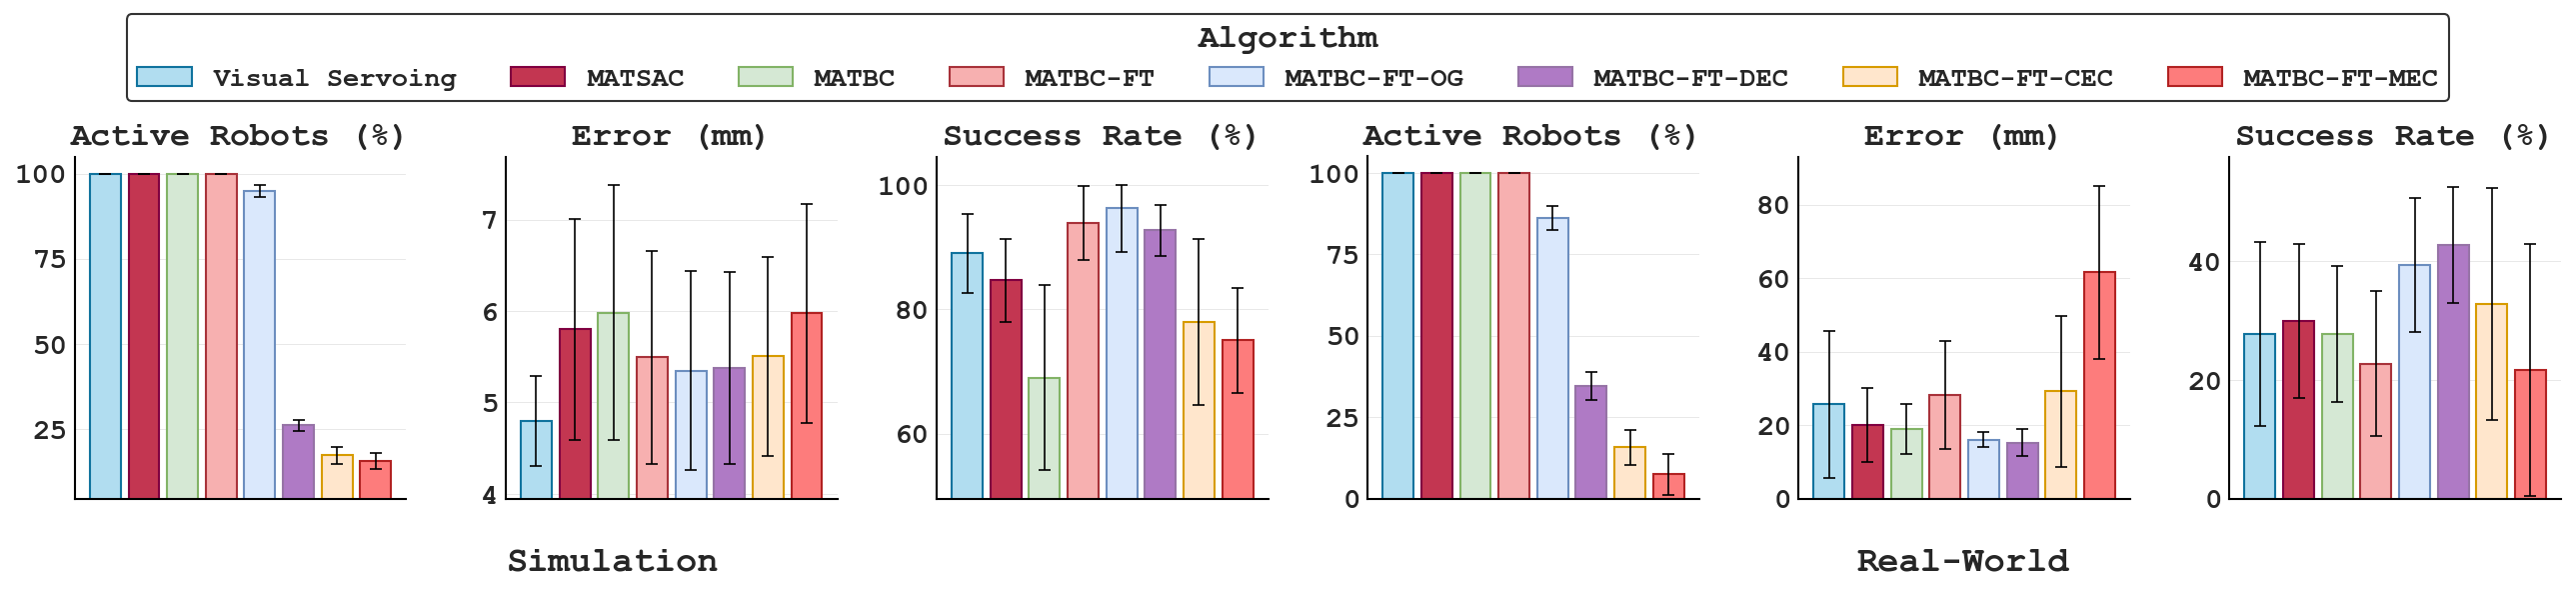

In [63]:
# --- [ Previous code: Imports, Constants, Palettes, Fonts, rcParams, Helpers, Data Loading/Aggregation ] ---
# Make sure plotting_df_sim and metrics_df_real are loaded/created

# --- Combined Plotting Function (1x6 Layout) ---
def generate_sidebyside_summary_plots(df_sim, df_real, output_dir='./plots/'):
    """
    Generates a 1x6 combined summary bar plot for simulation and real-world data.
    """

    if df_sim.empty or df_real.empty:
        print("One or both DataFrames are empty. Cannot generate combined plot.")
        return

    os.makedirs(output_dir, exist_ok=True)

    # --- Metric Definitions & Alignment ---
    # Ensure the order corresponds between sim and real
    sim_metrics = ['% Active Robots', 'Avg Distance Error', 'Success Rate']
    real_metrics = ['Robots Used (%)', 'Mean Error', 'Success Rate'] # Corresponding real metrics
    col_labels = ['Active Robots (%)', 'Error (mm)', 'Success Rate (%)'] # Unified labels for titles

    # --- Create Figure (1 row, 6 columns) ---
    n_metrics = len(sim_metrics) # Should be 3
    fig, axes = plt.subplots(1, n_metrics * 2, figsize=(18, 3.5), sharey=False) # Wider, shorter figure
    axes = axes.flatten() # Ensure axes is iterable

    legend_handles = None
    print("Generating side-by-side summary bar plots...")

    # --- Loop through Metrics (Columns) ---
    for i in range(n_metrics):
        sim_metric = sim_metrics[i]
        real_metric = real_metrics[i]
        col_label = col_labels[i] # Unified label part

        ax_sim = axes[i]
        ax_real = axes[i + n_metrics]

        metric_data_sim = df_sim[df_sim['Metric'] == sim_metric]
        if metric_data_sim.empty: raise ValueError(f"No sim data for {sim_metric}")
        algo_summary_sim = metric_data_sim.groupby('Algorithm')['Value'].agg(['mean', 'std']).reindex(ALGOS_ORDER)
        plot_df_mean_sim = algo_summary_sim[['mean']].reset_index().rename(columns={'mean': 'Value'})
        y_values_sim = algo_summary_sim['mean'].values
        y_errors_sim = algo_summary_sim['std'].fillna(0).values

        sns.barplot(x='Algorithm', y='Value', data=plot_df_mean_sim,
                    order=ALGOS_ORDER, hue='Algorithm', hue_order=ALGOS_ORDER,
                    palette=final_palette, ax=ax_sim, linewidth=0, saturation=1,
                    errorbar=None, dodge=False)

        # Apply Edge Colors (Sim)
        num_bars_expected = len(ALGOS_ORDER)
        num_containers = len(ax_sim.containers)
        # ... (Insert edge coloring loop for ax_sim - same as before) ...
        if num_containers == num_bars_expected:
            for algo_idx, container in enumerate(ax_sim.containers):
                if algo_idx < len(edge_colors): ec = edge_colors[algo_idx]; bar = container.patches[0]; bar.set_edgecolor(ec); bar.set_linewidth(1.0)
        elif num_containers == 1 and len(ax_sim.containers[0].patches) == num_bars_expected:
                container = ax_sim.containers[0]; # ... loop through patches ...
                for patch_idx, bar in enumerate(container.patches):
                    if patch_idx < len(edge_colors): ec = edge_colors[patch_idx]; bar.set_edgecolor(ec); bar.set_linewidth(1.0)

        # Add Clipped Error Bars (Sim)
        x_centers = np.arange(len(ALGOS_ORDER))
        valid_mask_sim = ~np.isnan(y_values_sim)
        if np.any(valid_mask_sim):
            # (Insert clipping logic for y_errors_sim based on col_label)
            if col_label in ['Active Robots (%)', 'Success Rate (%)']:
                lower_err = np.minimum(y_errors_sim[valid_mask_sim], y_values_sim[valid_mask_sim] - 0)
                upper_err = np.minimum(y_errors_sim[valid_mask_sim], 100 - y_values_sim[valid_mask_sim])
                error_to_plot_sim = np.maximum(0, np.array([lower_err, upper_err]))
            else: # Error metric
                lower_err = np.minimum(y_errors_sim[valid_mask_sim], y_values_sim[valid_mask_sim] - 0)
                error_to_plot_sim = np.maximum(0, np.array([lower_err, y_errors_sim[valid_mask_sim]]))

            ax_sim.errorbar(x=x_centers[valid_mask_sim], y=y_values_sim[valid_mask_sim], yerr=error_to_plot_sim,
                        fmt='none', ecolor='black', elinewidth=0.8, capsize=3, capthick=0.8, zorder=5)

        # Axis Styling (Sim)
        ax_sim.set_title(f"{col_label}", fontsize=GLOBAL_FONT_SIZE*1.6, fontweight="bold") # Title includes metric & context
        ax_sim.set_ylabel(None) # Remove Y label
        ax_sim.set_xlabel(None)
        ax_sim.set_xticklabels([])
        ax_sim.tick_params(axis='x', bottom=False)
        ax_sim.grid(axis='y', visible=True, linestyle='-', linewidth=0.4, color='#DDDDDD', alpha=0.8)
        ax_sim.grid(axis='x', visible=False)
        # (Set Y limits for ax_sim if desired)
        if np.any(valid_mask_sim): # Set ylim based on error bars
            min_val = np.nanmin(y_values_sim[valid_mask_sim] - error_to_plot_sim[0]) if error_to_plot_sim.ndim == 2 else np.nanmin(y_values_sim[valid_mask_sim] - error_to_plot_sim)
            max_val = np.nanmax(y_values_sim[valid_mask_sim] + error_to_plot_sim[1]) if error_to_plot_sim.ndim == 2 else np.nanmax(y_values_sim[valid_mask_sim] + error_to_plot_sim)
            pad = (max_val - min_val) * 0.1 if (max_val - min_val) > 0 else 1.0
            lim_low = max(0, min_val - pad)
            lim_high = max_val + pad
            if col_label in ['Active Robots (%)', 'Success Rate (%)']: lim_high = min(105, lim_high); lim_low = max(-5, lim_low)
            ax_sim.set_ylim(bottom=lim_low, top=lim_high)
        sns.despine(ax=ax_sim)

        
        if real_metric not in df_real.columns: raise ValueError(f"Column {real_metric} not in real df")
        algo_summary_real = df_real.groupby('Algorithm')[real_metric].agg(['mean', 'std']).reindex(ALGOS_ORDER)
        plot_df_mean_real = algo_summary_real[['mean']].reset_index().rename(columns={'mean': real_metric})
        y_values_real = algo_summary_real['mean'].values
        y_errors_real = algo_summary_real['std'].fillna(0).values

        sns.barplot(x='Algorithm', y=real_metric, data=plot_df_mean_real,
                    order=ALGOS_ORDER, hue='Algorithm', hue_order=ALGOS_ORDER,
                    palette=final_palette, ax=ax_real, linewidth=0, saturation=1,
                    errorbar=None, dodge=False)

        # Apply Edge Colors (Real)
        num_bars_expected = len(ALGOS_ORDER)
        num_containers = len(ax_real.containers)
        # ... (Insert edge coloring loop for ax_real - same as above) ...
        if num_containers == num_bars_expected:
            for algo_idx, container in enumerate(ax_real.containers):
                if algo_idx < len(edge_colors): ec = edge_colors[algo_idx]; bar = container.patches[0]; bar.set_edgecolor(ec); bar.set_linewidth(1.0)
        elif num_containers == 1 and len(ax_real.containers[0].patches) == num_bars_expected:
            container = ax_real.containers[0]; # ... loop through patches ...
            for patch_idx, bar in enumerate(container.patches):
                if patch_idx < len(edge_colors): ec = edge_colors[patch_idx]; bar.set_edgecolor(ec); bar.set_linewidth(1.0)


        # Add Clipped Error Bars (Real)
        valid_mask_real = ~np.isnan(y_values_real)
        if np.any(valid_mask_real):
            # (Insert clipping logic for y_errors_real based on col_label)
            if col_label in ['Active Robots (%)', 'Success Rate (%)']:
                lower_err = np.minimum(y_errors_real[valid_mask_real], y_values_real[valid_mask_real] - 0)
                upper_err = np.minimum(y_errors_real[valid_mask_real], 100 - y_values_real[valid_mask_real])
                error_to_plot_real = np.maximum(0, np.array([lower_err, upper_err]))
            else: # Error metric
                lower_err = np.minimum(y_errors_real[valid_mask_real], y_values_real[valid_mask_real] - 0)
                error_to_plot_real = np.maximum(0, np.array([lower_err, y_errors_real[valid_mask_real]]))

            ax_real.errorbar(x=x_centers[valid_mask_real], y=y_values_real[valid_mask_real], yerr=error_to_plot_real,
                            fmt='none', ecolor='black', elinewidth=0.8, capsize=3, capthick=0.8, zorder=5)

        # Axis Styling (Real)
        ax_real.set_title(f"{col_label}", fontsize=GLOBAL_FONT_SIZE*1.6, fontweight="bold") # Title includes metric & context
        ax_real.set_ylabel(None) # Remove Y label
        ax_real.set_xlabel(None)
        ax_real.set_xticklabels([])
        ax_real.tick_params(axis='x', bottom=False)
        ax_real.grid(axis='y', visible=True, linestyle='-', linewidth=0.4, color='#DDDDDD', alpha=0.8)
        ax_real.grid(axis='x', visible=False)
        # (Set Y limits for ax_real if desired)
        if np.any(valid_mask_real): # Set ylim based on error bars
                min_val = np.nanmin(y_values_real[valid_mask_real] - error_to_plot_real[0]) if error_to_plot_real.ndim == 2 else np.nanmin(y_values_real[valid_mask_real] - error_to_plot_real)
                max_val = np.nanmax(y_values_real[valid_mask_real] + error_to_plot_real[1]) if error_to_plot_real.ndim == 2 else np.nanmax(y_values_real[valid_mask_real] + error_to_plot_real)
                pad = (max_val - min_val) * 0.1 if (max_val - min_val) > 0 else 1.0
                lim_low = max(0, min_val - pad)
                lim_high = max_val + pad
                if col_label in ['Active Robots (%)', 'Success Rate (%)']: lim_high = min(105, lim_high); lim_low = max(-5, lim_low)
                ax_real.set_ylim(bottom=lim_low, top=lim_high)
        sns.despine(ax=ax_real)

        # --- Capture Legend Handles ---
        if i == 0: # Get handles only once (from Sim plot is fine)
             display_labels = [ALGO_NAME_MAP.get(algo, algo) for algo in ALGOS_ORDER]
             handles = [Rectangle((0,0),1,1, facecolor=final_palette[j], edgecolor=edge_colors[j], linewidth=1.0)
                       for j in range(len(ALGOS_ORDER))]
             labels = display_labels
             legend_handles = handles

    # --- Add Common Legend ---
    if legend_handles:
        
        fig.text(0.25, 0.0,
         "Simulation",
         ha="center", va="center",
         fontsize=GLOBAL_FONT_SIZE*1.7,
         fontweight="bold")
        fig.text(0.75, 0.0,
                "Real-World",
                ha="center", va="center",
                fontsize=GLOBAL_FONT_SIZE*1.7,
                fontweight="bold")
        fig.legend(handles=legend_handles, labels=labels,fontsize=GLOBAL_FONT_SIZE * 1.3,
                   loc='upper center', bbox_to_anchor=(0.5, 1.07), # Adjust position
                   ncol=min(len(labels), 8), frameon=True, edgecolor='black', facecolor='white',
                   title='Algorithm', title_fontproperties={'size': GLOBAL_FONT_SIZE*1.6, 'weight': GLOBAL_FONT_WEIGHT})

    # --- Final Layout Adjustment ---
    plt.tight_layout(rect=[0.02, 0.05, 0.98, 0.88]) # Adjust rect for legend and tight spacing
    plt.subplots_adjust(wspace=0.3) # Adjust width space between plots if needed

    # --- SAVE & SHOW ---
    save_filename = "combined_results.png"
    save_path = os.path.join(output_dir, save_filename)
    print(f"Saving combined 1x6 summary plot to {save_path}")
    try:
        plt.savefig(save_path)
        # plt.savefig(os.path.join(output_dir, "combined_summary_performance_1x6.pdf"))
    except Exception as e:
        print(f"Error saving plot: {e}")

    plt.show()
    plt.close(fig)


# --- Main Execution ---
if __name__ == "__main__":
    # --- Load or Aggregate Data ---
    # (Make sure plotting_df_sim and metrics_df_real are created here)
    # ... (example using dummy data if needed) ...

    # --- Call the plotting function ---
    if 'plotting_df' in locals() and 'metrics_df_real' in locals():
         if not plotting_df.empty and not metrics_df_real.empty:
              generate_sidebyside_summary_plots(plotting_df, metrics_df_real, output_dir='./plots/') # Call the new function
         else:
              print("One or both dataframes are empty after loading/aggregation.")
    else:
         print("Error: Simulation or Real-world DataFrame not loaded/generated.")

3
Applying global plot styles for real-world plots...
Successfully set font to: Courier New
Starting REAL-WORLD trajectory visualization...
Loaded ground truth data from: ./data/test_traj/test_trajs_new.pkl
Creating ALTERNATING plot grid: 3 rows x 8 columns
  Processing Trajectory: snek (Row 1)
      Loading data for Vis Servo / snek...
      Loading data for MATSAC / snek...
      Loading data for MABC / snek...
      Loading data for MABC_Finetune / snek...
      Loading data for MABC_Finetune_Bin / snek...
      Loading data for MABC_Finetune_PB / snek...
      Loading data for MABC_Finetune_CA / snek...
      Loading data for MABC_Finetune_PB_CA / snek...
  Processing Trajectory: cross (Row 2)
      Loading data for Vis Servo / cross...
      Loading data for MATSAC / cross...
      Loading data for MABC / cross...
      Loading data for MABC_Finetune / cross...
      Loading data for MABC_Finetune_Bin / cross...
      Loading data for MABC_Finetune_PB / cross...
      Loading data

/tmp/ipykernel_3058107/2953112575.py:167: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(gt_traj[:, 0], gt_traj[:, 1], 'k--', color="#444444", linewidth=2.0, alpha=0.8, zorder=5)
/tmp/ipykernel_3058107/2953112575.py:167: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(gt_traj[:, 0], gt_traj[:, 1], 'k--', color="#444444", linewidth=2.0, alpha=0.8, zorder=5)
/tmp/ipykernel_3058107/2953112575.py:167: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(gt_traj[:, 0], gt_traj[:, 1], 'k--', color="#444444", linewidth=2.0, alpha=0.8, zorder=5)
/tmp/ipykernel_3058107/2953112575.py:167: UserWarning: color is redundantly defined by the 'color' k

Real-world plot saved successfully to real_world_trajectories_compact.png


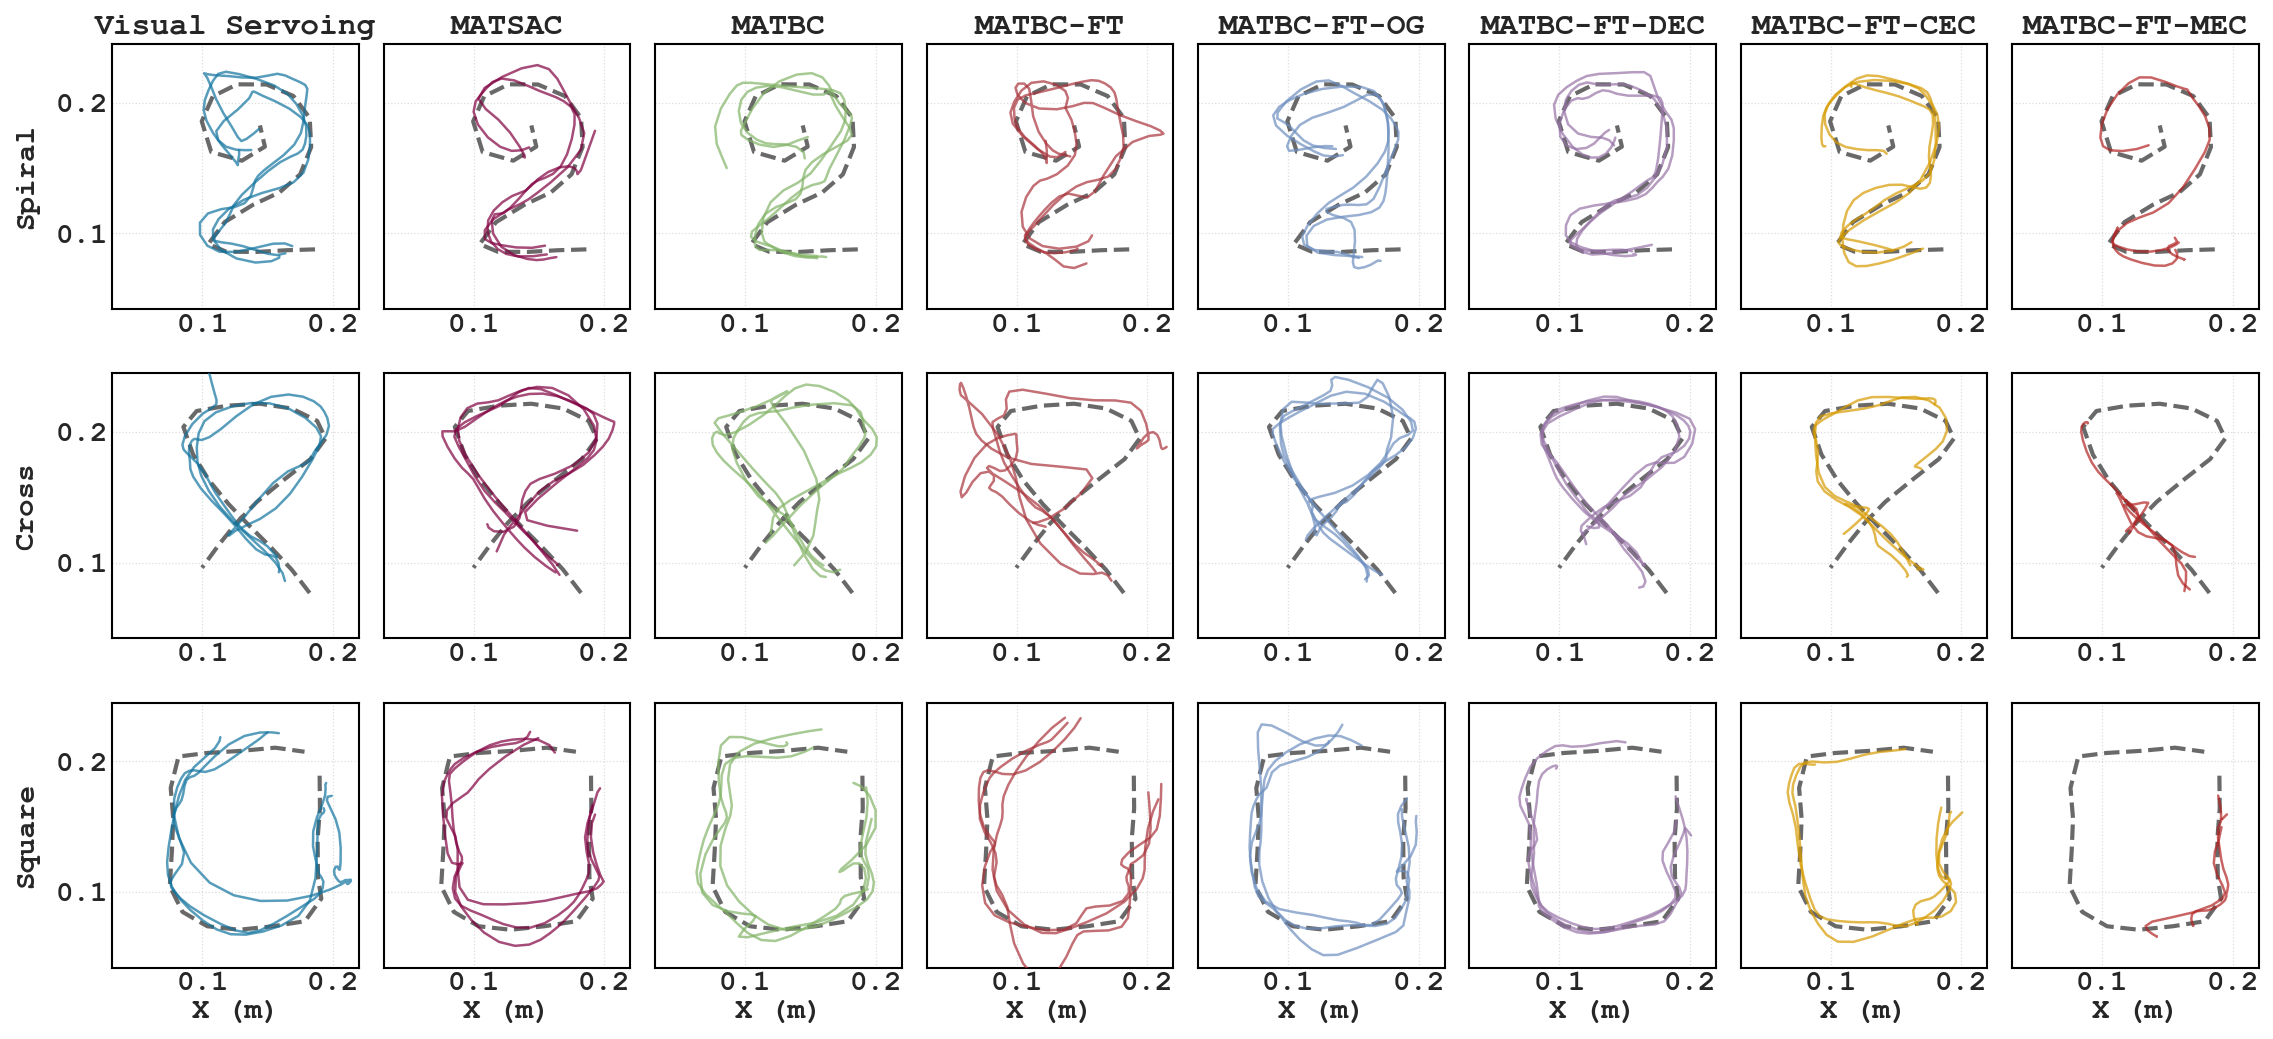

--- Real-World Visualization Complete ---


In [64]:

import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict
import pandas as pd
from scipy.ndimage import gaussian_filter1d
import os # Needed for file path operations

# --- Real World Constants ---
ALGOS_ORDER_REAL = [
    'Vis Servo', 'MATSAC', "MABC", "MABC_Finetune", "MABC_Finetune_Bin",
    "MABC_Finetune_PB", "MABC_Finetune_CA", "MABC_Finetune_PB_CA"
]
# Make sure ALGO_NAME_MAP covers all keys in ALGOS_ORDER_REAL
ALGO_NAME_MAP = {"Vis Servo": "Visual Servoing","MATSAC": "MATSAC","MABC": "MATBC",
                 "MABC_Finetune": "MATBC-FT","MABC_Finetune_Bin": "MATBC-FT-OG",
                 "MABC_Finetune_PB": "MATBC-FT-DEC","MABC_Finetune_CA": "MATBC-FT-CEC",
                 "MABC_Finetune_PB_CA": "MATBC-FT-MEC"
                }
# Make sure TRAJ_NAME_MAP covers all keys in TRAJECTORIES
TRAJ_NAME_MAP = {"snek": "Spiral","cross": "Cross","square": "Square"}

OBJECTS = ['hexagon', 'star', "trapezium"] # Real-world objects
TRAJECTORIES = ['snek', 'cross', 'square'] # Real-world trajectories
print(len(TRAJECTORIES))
DATA_DIR = './data/test_traj/' # Adjust if your real data is elsewhere

# --- Palettes (Adapted for Real World Algos) ---
_final_palette_base = ['#B1DDF0', '#C33651', '#d5e8d4', '#F7B0B0', "#dae8fc", '#AF7AC5', '#FFE6CC', '#FD7C7C']
_edge_colors_base =   ['#10739e', '#800040', '#82b366', '#A8323A', "#6c8ebf", '#9673a6', "#d79b00", '#B22222']

num_algos_real = len(ALGOS_ORDER_REAL)
final_palette_real = _final_palette_base[:num_algos_real]
edge_colors_real = _edge_colors_base[:num_algos_real]

if len(final_palette_real) < num_algos_real:
     print(f"Warning: Base palette length ({len(_final_palette_base)}) is less than the number of real-world algorithms ({num_algos_real}). Recycling colors.")
     final_palette_real = [ _final_palette_base[i % len(_final_palette_base)] for i in range(num_algos_real) ]
     edge_colors_real = [ _edge_colors_base[i % len(_edge_colors_base)] for i in range(num_algos_real) ]

# Create color lookup dictionaries for real algos
algo_fill_colors_real = {algo: color for algo, color in zip(ALGOS_ORDER_REAL, final_palette_real)}
algo_edge_colors_real = {algo: color for algo, color in zip(ALGOS_ORDER_REAL, edge_colors_real)}


# --- Font Settings ---
GLOBAL_FONT_FAMILY = "Courier New" # Or your preferred font
GLOBAL_FONT_WEIGHT = "bold"
GLOBAL_FONT_SIZE   = 10

# --- Apply rcParams for Global Styling ---
print("Applying global plot styles for real-world plots...")
try:
    plt.style.use('seaborn-v0_8-whitegrid') # Base style
    plt.rcParams.update({
        'axes.edgecolor': 'black', 'axes.linewidth': 1.0,
        'grid.color': '#DDDDDD', 'grid.linestyle': ':', 'grid.linewidth': 0.6, # Subtle grid
        'font.family': GLOBAL_FONT_FAMILY,
        'font.weight': GLOBAL_FONT_WEIGHT,
        'font.size': GLOBAL_FONT_SIZE,
        'axes.labelsize': GLOBAL_FONT_SIZE * 1.4,
        'axes.labelweight': GLOBAL_FONT_WEIGHT,
        'axes.titlesize': GLOBAL_FONT_SIZE * 1.5, # Title size for subplots
        'axes.titleweight': GLOBAL_FONT_WEIGHT,
        'xtick.labelsize': GLOBAL_FONT_SIZE* 1.4,
        'ytick.labelsize': GLOBAL_FONT_SIZE* 1.4,
        'legend.fontsize': GLOBAL_FONT_SIZE * 1.4,
        'figure.dpi': 150,
        'savefig.dpi': 300
    })
    # Test font
    fig_dummy, ax_dummy = plt.subplots(figsize=(0.1,0.1)); ax_dummy.text(0.5, 0.5, 'test', fontname=GLOBAL_FONT_FAMILY); plt.close(fig_dummy)
    print(f"Successfully set font to: {GLOBAL_FONT_FAMILY}")
except Exception as e:
    print(f"Warning: Font '{GLOBAL_FONT_FAMILY}' not found or error: {e}. Falling back to 'monospace'.")
    GLOBAL_FONT_FAMILY = 'monospace'
    plt.rcParams['font.family'] = GLOBAL_FONT_FAMILY
# --- Workspace boundary (reuse from previous) ---
x0, x1 = 0.011 + 0.02, 0.24 - 0.02
y0, y1 = 0.007 + 0.035, 0.27 - 0.025
width = x1 - x0
height = y1 - y0

# --- Helper Functions (compute_mean_std_path, smooth_trajectory - unchanged) ---
def compute_mean_std_path(run_data_list):
    valid_runs = [run for run in run_data_list if run is not None and len(run) > 0] # Added None check
    if not valid_runs: return np.array([]), np.array([])
    max_len = max(len(run) for run in valid_runs)
    if max_len == 0: return np.array([]), np.array([])
    num_runs = len(valid_runs)
    all_data = np.full((num_runs, max_len, 2), np.nan, dtype=float)
    for i, run in enumerate(valid_runs):
        length = len(run)
        # Ensure run data is numpy array before slicing
        run_array = np.array(run)
        if run_array.ndim == 2 and run_array.shape[1] >= 2:
             all_data[i, :length, :] = run_array[:, :2]
        else:
             print(f"Warning: Run {i} has unexpected shape {run_array.shape}. Skipping.") # Debug
             all_data[i, :, :] = np.nan # Mark run as invalid for mean calculation

    mean_xy = np.nanmean(all_data, axis=0); std_xy  = np.nanstd(all_data, axis=0)
    valid_steps = ~np.isnan(mean_xy).any(axis=1)
    return mean_xy[valid_steps], std_xy[valid_steps]

def smooth_trajectory(trajectory, sigma=1.5):
    if trajectory.shape[0] < 3: return trajectory
    smoothed_x = gaussian_filter1d(trajectory[:, 0], sigma=sigma, mode='nearest')
    smoothed_y = gaussian_filter1d(trajectory[:, 1], sigma=sigma, mode='nearest')
    return np.column_stack((smoothed_x, smoothed_y))


# --- Real World Visualization Function ---
def visualize_real_world_trajectories(
    ground_truth_path="./data/test_traj/test_trajs.pkl",
    output_filename="real_world_trajectories_compact.png",
    position_key='final_qpos', # *** KEY PARAMETER: Adjust if your position data uses a different key ***
    fallback_position_key='object_pose', # Optional: try this key if position_key is not found
    smoothing_sigma=1.5,
    save_plots=False
):
    # --- Load Ground Truth ---
    try:
        test_trajs = pickle.load(open(ground_truth_path, "rb"))
        print(f"Loaded ground truth data from: {ground_truth_path}")
    except FileNotFoundError:
        print(f"Warning: Ground truth file not found at {ground_truth_path}. Ground truth cannot be plotted.")
        test_trajs = {}
    except Exception as e:
        print(f"Error loading ground truth data: {e}"); test_trajs = {}

    # --- Setup Plot Grid ---
    n_rows = len(TRAJECTORIES)
    n_cols = num_algos_real # Total columns for alternating layout (3 objects * 2 plot types)

    # Adjust figsize: Mask plots might be wider than trajectory plots
    mask_width_factor = 2.7 # Width factor for mask plots
    traj_width_factor = 2.6 # Width factor for trajectory plots
    total_fig_width = len(OBJECTS) * (mask_width_factor + traj_width_factor)
    fig_height = n_rows * 2.5 # Adjust height factor as needed

    print(f"Creating ALTERNATING plot grid: {n_rows} rows x {n_cols} columns")
    fig, axs = plt.subplots(
        n_rows, n_cols, # <<<--- Use 3x6 grid
        figsize=(total_fig_width, fig_height),
        sharex=False, # <<<--- No axis sharing
        sharey=False, # <<<--- No axis sharing
        squeeze=False
    )

    # --- Font settings (using rcParams now, but can override here if needed) ---
    title_fontsize = plt.rcParams['axes.titlesize']
    label_fontsize = plt.rcParams['axes.labelsize']
    tick_fontsize = plt.rcParams['xtick.labelsize']
    fontweight = plt.rcParams['font.weight']

    # --- Plotting Loop ---
    for r, traj_name in enumerate(TRAJECTORIES):
        print(f"  Processing Trajectory: {traj_name} (Row {r+1})")
        gt_traj = test_trajs.get(traj_name)

        for c, algo_name in enumerate(ALGOS_ORDER_REAL):
            # print(f"    Processing Algorithm: {algo_name} (Column {c+1})") # Verbose
            ax = axs[r, c]
            if gt_traj is not None and isinstance(gt_traj, np.ndarray) and gt_traj.shape[0] > 0:
                 ax.plot(gt_traj[:, 0], gt_traj[:, 1], 'k--', color="#444444", linewidth=2.0, alpha=0.8, zorder=5)

            # --- Aggregate Real World Data for Current Algo/Traj ---
            all_runs_for_algo_traj = []
            print(f"      Loading data for {algo_name} / {traj_name}...")
            files_found_count = 0
            for obj_name in OBJECTS:
                file_name = f"test_traj_{algo_name}_{traj_name}_{obj_name}.pkl"
                file_path = os.path.join(DATA_DIR, file_name)
                files_found_count += 1
                with open(file_path, 'rb') as f:
                    raw_data = pickle.load(f)

                    step_list = None
                    if isinstance(raw_data, dict):
                        obj_level_data = raw_data.get(obj_name)
                        if isinstance(obj_level_data, dict):
                            step_list = obj_level_data.get(traj_name)
                        elif obj_name == "data" and isinstance(raw_data.get("data"), dict): # Handle older format?
                                nested = raw_data["data"].get(obj_name)
                                if isinstance(nested, dict):
                                    step_list = nested.get(traj_name)
                    elif isinstance(raw_data, list):
                            step_list = raw_data

                    if isinstance(step_list, list) and step_list:
                        positions = []
                        for step in step_list:
                            pos = step.get(position_key)
                            if pos is None and fallback_position_key: # Try fallback key
                                    pos = step.get(fallback_position_key)

                            if pos is not None:
                                positions.append(np.array(pos[:2], dtype=float))
                                
                        if positions: 
                            all_runs_for_algo_traj.append(positions)

            # --- Compute Mean/Std, Smooth, Plot (using aggregated runs) ---
            # if all_runs_for_algo_traj:
            #     mean_xy, std_xy = compute_mean_std_path(all_runs_for_algo_traj)

            #     if mean_xy.size > 0 and std_xy.size > 0:
            #         smoothed_mean_xy = smooth_trajectory(mean_xy, sigma=smoothing_sigma)
            #         edge_color = algo_edge_colors_real.get(algo_name, 'gray') # Use real palettes
            #         fill_color = algo_fill_colors_real.get(algo_name, 'lightgray') # Use real palettes
            #         ax.plot(smoothed_mean_xy[:, 0], smoothed_mean_xy[:, 1], color=edge_color, linewidth=1.5, zorder=10)
            #         if len(std_xy) == len(smoothed_mean_xy):
            #              ax.fill_between(smoothed_mean_xy[:, 0],
            #                              smoothed_mean_xy[:, 1] - std_xy[:, 1],
            #                              smoothed_mean_xy[:, 1] + std_xy[:, 1], color=fill_color, alpha=0.4, zorder=3)
            #         # else: # Fallback
            #         #      ax.fill_between(mean_xy[:, 0], mean_xy[:, 1] - std_xy[:, 1],
            #         #                      mean_xy[:, 1] + std_xy[:, 1], color=fill_color, alpha=0.3, zorder=3)

            # # --- Styling Subplot ---
            # ax.set_aspect('equal', adjustable='box')
            if all_runs_for_algo_traj:
                # Get the color for this algorithm
                edge_color = algo_edge_colors_real.get(algo_name, 'gray') # Use real palettes

                # Loop through each run (corresponding to one object's trajectory)
                for i, run_positions in enumerate(all_runs_for_algo_traj):
                    try:
                        # Convert list of positions to numpy array
                        trajectory_np = np.array(run_positions, dtype=float)

                        # Basic validation
                        if trajectory_np.ndim == 2 and trajectory_np.shape[0] > 0 and trajectory_np.shape[1] >= 2:
                             # Smooth the individual trajectory
                             smoothed_traj = smooth_trajectory(trajectory_np[:, :2], sigma=smoothing_sigma)

                             # Plot the smoothed trajectory
                             if smoothed_traj.shape[0] > 0:
                                 # Use a slightly thinner line and some alpha for clarity
                                 ax.plot(smoothed_traj[:, 0], smoothed_traj[:, 1],
                                         color=edge_color,
                                         linewidth=1.2,  # Thinner line for individual traces
                                         alpha=0.7,      # Add transparency
                                         zorder=10 + i)  # Stagger zorder slightly
                        # else:
                        #     print(f"      Warning: Trajectory data for object {i} has unexpected shape {trajectory_np.shape}. Skipping.")

                    except Exception as e:
                         print(f"      Error processing or plotting trajectory for object {i}: {e}")

            # --- Styling Subplot ---
            # (Keep the rest of the styling block as is)
            ax.set_aspect('equal', adjustable='box')
            ax.grid(plt.rcParams['grid.linewidth'] > 0, linestyle=plt.rcParams['grid.linestyle'],
                    color=plt.rcParams['grid.color'], alpha=1) # Use rcParams for grid
            rect = patches.Rectangle((x0, y0), width, height, linewidth=0.5, edgecolor='gray', facecolor='none', alpha=0.6, zorder=1)
            ax.add_patch(rect)

            # --- Titles and Labels ---
            if r == 0: # Top row: Algorithm names
                ax.set_title(ALGO_NAME_MAP.get(algo_name, algo_name), pad=5) # Font via rcParams

            if c == 0: # First column: Trajectory names
                ax.set_ylabel(TRAJ_NAME_MAP.get(traj_name, traj_name), labelpad=8) # Font via rcParams
            else:
                ax.set_ylabel(None)
                ax.set_yticklabels([])

            if r == n_rows - 1 : # Bottom row only
                 ax.set_xlabel("X (m)", labelpad=2) # Font via rcParams
            else:
                 ax.set_xlabel("")

            # Ticks - Fontsize via rcParams, padding adjusted
            ax.tick_params(axis='both', which='major', pad=2)
            y_padding = height * 0 # 5% padding
            x_padding = width * 0  # 5% padding (optional, but good for consistency)
            ax.set_ylim(y0 - y_padding, y1 + y_padding)
            ax.set_xlim(x0 - x_padding, x1 + x_padding)


    # --- Final Adjustments ---
    plt.subplots_adjust(left=0.08, right=0.98, # Reduced left margin for row titles
                        bottom=0.08, top=0.92,  # Reduced bottom/top margins
                        wspace=0.10, hspace=0.15) # Significantly reduced space between plots
    # No suptitle for compactness

    # --- Save and Show ---
    if save_plots:
        try:
            fig.savefig(output_filename, dpi=plt.rcParams['savefig.dpi'], bbox_inches='tight', transparent=True)
            print(f"Real-world plot saved successfully to {output_filename}")
        except Exception as e:
            print(f"Error saving real-world plot: {e}")

    plt.show()
    print("--- Real-World Visualization Complete ---")


# --- Example Usage ---
if __name__ == "__main__":
    print("Starting REAL-WORLD trajectory visualization...")

    # *** IMPORTANT: Verify this key matches your real-world data files ***
    REAL_WORLD_POSITION_KEY = 'final_qpos'
    # REAL_WORLD_POSITION_KEY = 'object_pose' # Example alternative

    visualize_real_world_trajectories(
        ground_truth_path="./data/test_traj/test_trajs_new.pkl", # Keep same GT path
        output_filename="real_world_trajectories_compact.png",
        position_key=REAL_WORLD_POSITION_KEY,
        # fallback_position_key='object_pose', # Optional: uncomment if needed
        smoothing_sigma=1.5, # Adjust smoothing if real data is noisier/smoother
        save_plots=True
    )

    # --- Optional: Generate Metrics DataFrame (Code provided by user) ---
    # print("\nGenerating metrics DataFrame...")
    # df_metrics = collect_metrics_to_df()
    # if not df_metrics.empty:
    #     print("Metrics DataFrame Head:")
    #     print(df_metrics.head())
    #     # df_metrics.to_csv("real_world_metrics.csv", index=False)
    #     # print("Metrics saved to real_world_metrics.csv")
    # else:
    #      print("Metrics DataFrame is empty.")

/home/nagababa/miniconda3/envs/py312/lib/python3.12/site-packages/torchvision/transforms/functional.py:154: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


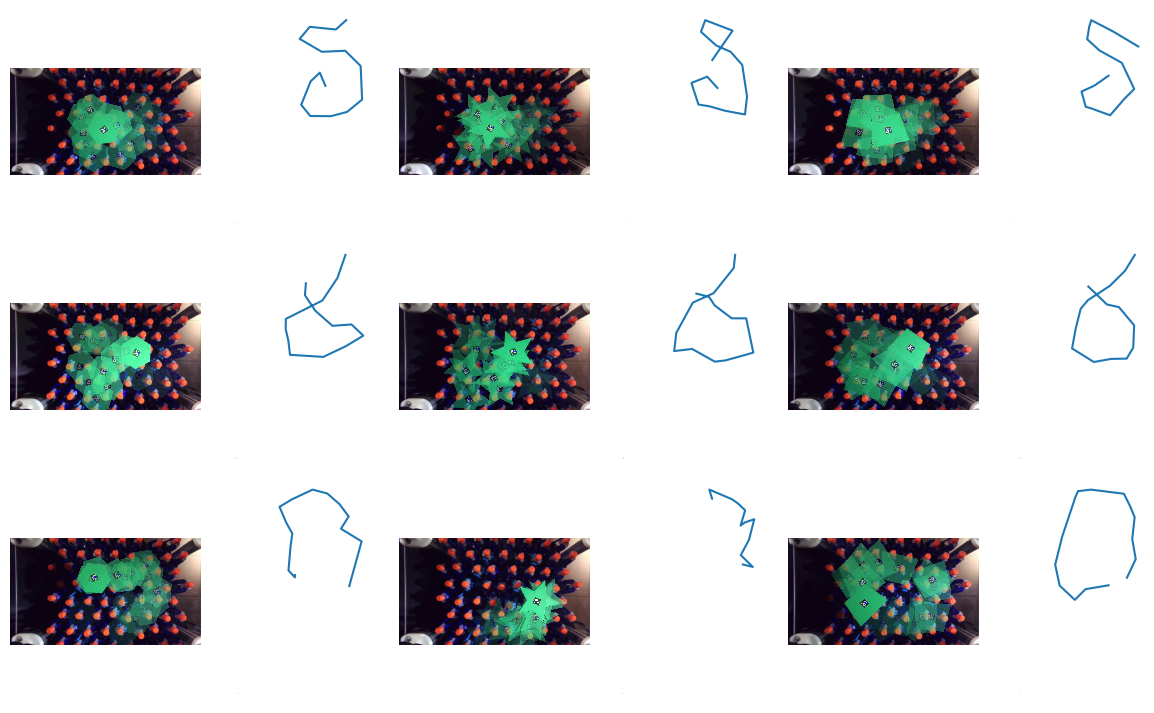

In [ ]:

import os
import cv2
import pickle
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from PIL import Image
from utils.vision_utils import VisUtils

# -------------------- Configuration --------------------
selected_algo     = 'MABC_Finetune_PB'
OBJECTS           = ['hexagon', 'star', 'trapezium']
TRAJECTORIES      = ['snek', 'cross', 'square']
DATA_DIR          = './data/test_traj'
VIDEO_DIR         = './data/videos/real'
GT_TRAJ_PKL       = './data/test_traj/test_trajs_new.pkl'
OUTPUT_FILE       = './plots/merged_masks_trajectories.png'
PLOTS_DIR         = './plots'
os.makedirs(PLOTS_DIR, exist_ok=True)

# Sampling and overlay parameters
NUM_SAMPLES       = 15
MASK_COLOR        = (150, 150, 150)
ALPHA_START       = 0.1
ALPHA_END         = 0.7
SMOOTH_SIGMA      = 1

# Calibration / ArUco
CALIB_DIR         = './utils/calibration_data'
ARUCO_DICT        = cv2.aruco.DICT_5X5_50
MARKER_SIZE       = 0.015  # meters

# -------------------- Helper Functions --------------------
def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)


def sample_frames(cap, n):
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    idxs  = np.linspace(0, total-1, n, dtype=int)
    frames = []
    for i in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, fr = cap.read()
        if not ret: break
        frames.append(fr)
    return frames


def compute_centers_masks(frames, vis):
    centers, masks = [], []
    for fr in frames:
        mask = vis.get_object_mask(fr)
        pts  = vis.get_bd_pts(fr, total_pts=150)
        com  = np.nanmean(pts, axis=0) if pts is not None and len(pts)>0 else [np.nan,np.nan]
        centers.append(com)
        masks.append(mask)
    return np.array(centers), masks


def smooth_path(path, sigma):
    ok = ~np.isnan(path[:,0])
    x,y = path[ok,0], path[ok,1]
    if len(x)<3: return path
    xs = gaussian_filter1d(x, sigma)
    ys = gaussian_filter1d(y, sigma)
    out = np.full_like(path, np.nan)
    out[ok,0], out[ok,1] = xs, ys
    return out


def overlay_object_mask(ax, frame, mask, alpha):
    fr_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    overlay = np.zeros((*mask.shape,4), dtype=np.uint8)
    pixels = mask>0
    overlay[pixels,:3] = fr_rgb[pixels]
    overlay[pixels, 3] = int(alpha*255)
    ax.imshow(overlay, interpolation='none')

# -------------------- Load calibration & instantiate VisUtils --------------------
cam_mtx = np.load(os.path.join(CALIB_DIR,'camera_matrix.npy'))
dist    = np.load(os.path.join(CALIB_DIR,'dist_coeffs.npy'))
aruco_dict  = cv2.aruco.getPredefinedDictionary(ARUCO_DICT)
aruco_params= cv2.aruco.DetectorParameters()
detector    = cv2.aruco.ArucoDetector(aruco_dict, aruco_params)
vis = VisUtils(
    plane_size=np.array([(0.009,-0.034),(0.242,0.376)]),
    obj_detection_model='IDEA-Research/grounding-dino-tiny',
    segmentation_model='facebook/sam-vit-base',
    device='cuda', traditional=False)

# -------------------- Load ground-truth trajectories --------------------
try:
    gt_data = load_pickle(GT_TRAJ_PKL)
except FileNotFoundError:
    gt_data = {}

# -------------------- Figure Setup --------------------
n_rows = 3
n_cols = 6  # mask + trajectory per object

# Rectangular aspect: width set to paper width, height computed
fig_w = 15.0
fig_h = 6
fig, axs = plt.subplots(n_rows, n_cols,
                        figsize=(fig_w, fig_h),
                        gridspec_kw={'wspace':0.02,'hspace':0.05},
                        squeeze=False)
bgs, maskss, framess, centerss = [], [], [], []
for i, traj in enumerate(TRAJECTORIES):
    # load GT
    gt = np.array(gt_data.get(traj))
    for j, obj in enumerate(OBJECTS):
        # Mask subplot
        ax_m = axs[i, 2*j]
        ax_m.axis('off')
        vid = os.path.join(VIDEO_DIR, f'video_{selected_algo}_{traj}_{obj}.mp4')
        cap = cv2.VideoCapture(vid)
        frames = sample_frames(cap, NUM_SAMPLES)
        cap.release()
        if not frames:
            continue
        centers, masks = compute_centers_masks(frames, vis)
        bg = cv2.cvtColor(frames[-1], cv2.COLOR_BGR2RGB)
        bgs.append(bg)
        maskss.append(masks)
        framess.append(frames)
        centerss.append(centers)
        
        ax_m.imshow(bg)
        alphas = np.linspace(ALPHA_START, ALPHA_END, len(masks))
        for k, msk in enumerate(masks):
            if msk is not None:
                overlay_object_mask(ax_m, frames[k], msk, alphas[k])
        ax_m.set_aspect('equal')

        # Trajectory subplot
        ax_t = axs[i, 2*j+1]
        ax_t.axis('off')
        if centers.size>0:
            smooth = smooth_path(centers[:,:2], SMOOTH_SIGMA)
            # convert to pixel coords
            pix = vis.convert_world_2_pix(
                np.hstack([smooth, np.zeros((smooth.shape[0],1))]))
            ax_t.plot(pix[:,1], pix[:,0], '-', color='tab:blue', lw=1.5)
        # plot GT if available
        # if isinstance(gt, np.ndarray):
        ax_t.plot(gt[:,1], gt[:,0], '--', color='darkgray', lw=1.)
        ax_t.set_aspect('equal')

# -------------------- Final Saving --------------------
plt.savefig(OUTPUT_FILE, dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

KeyboardInterrupt: 

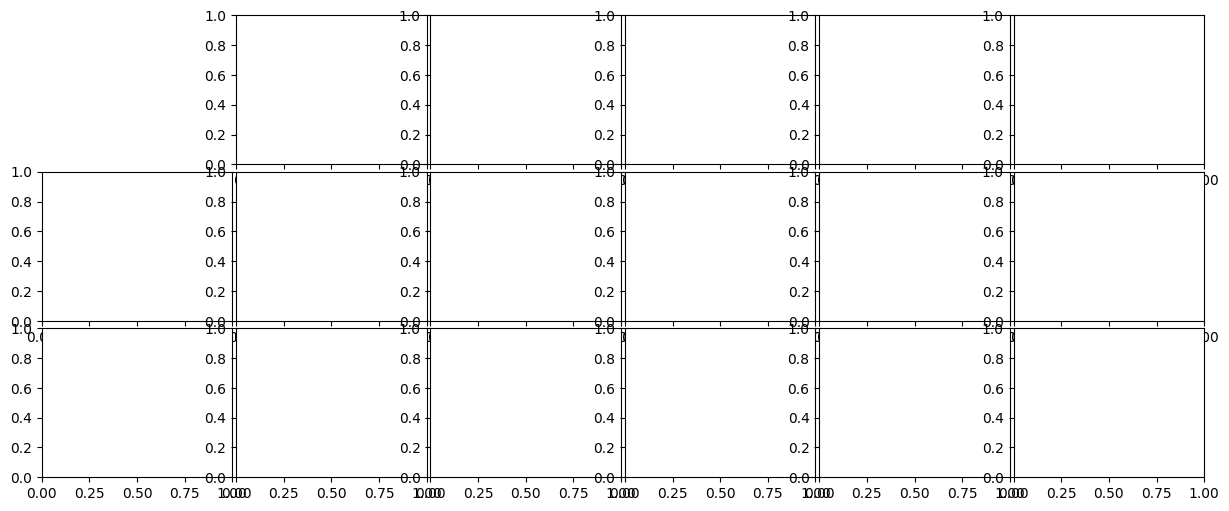

In [9]:
import os
import cv2
import pickle
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from PIL import Image
from utils.vision_utils import VisUtils

# -------------------- Configuration --------------------
# Candidate algorithms and selection
ALGO_CANDIDATES = ['MABC_Finetune_PB', 'MABC_Finetune_Bin']
OBJECTS           = ['hexagon', 'star', 'trapezium']
TRAJECTORIES      = ['snek', 'cross', 'square']
DATA_DIR          = './data/test_traj'
VIDEO_DIR         = './data/videos/real'
GT_TRAJ_PKL       = './data/test_traj/test_trajs_new.pkl'
OUTPUT_FILE       = './plots/merged_masks_best_algo.png'
PLOTS_DIR         = './plots'
os.makedirs(PLOTS_DIR, exist_ok=True)

# Sampling and overlay parameters
NUM_SAMPLES       = 15
MASK_COLOR        = (150, 150, 150)
ALPHA_START       = 0.1
ALPHA_END         = 0.7
SMOOTH_SIGMA      = 1

# Calibration / ArUco
CALIB_DIR         = './utils/calibration_data'
ARUCO_DICT        = cv2.aruco.DICT_5X5_50
MARKER_SIZE       = 0.015  # meters

# -------------------- Helper Functions --------------------
def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)


def compute_mean_reward(raw_data, obj, traj):
    # Navigate nested dicts to list of steps
    steps = None
    if obj in raw_data:
        steps = raw_data[obj].get(traj)
    elif isinstance(raw_data, dict):
        for v in raw_data.values():
            if isinstance(v, dict) and traj in v:
                steps = v[traj]
                break
    rewards = [s.get('reward', -np.inf) for s in steps]
    return np.sum(rewards)


def sample_frames(cap, n):
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    idxs  = np.linspace(0, total-1, n, dtype=int)
    frames=[]
    for i in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, fr = cap.read()
        if not ret: break
        frames.append(fr)
    return frames


def compute_centers_masks(frames, vis):
    centers, masks = [], []
    for fr in frames:
        mask = vis.get_object_mask(fr)
        pts  = vis.get_bd_pts(fr, total_pts=150)
        com  = np.nanmean(pts, axis=0) if pts is not None and len(pts)>0 else [np.nan,np.nan]
        centers.append(com)
        masks.append(mask)
    return np.array(centers), masks


def smooth_path(path, sigma):
    ok = ~np.isnan(path[:,0])
    x,y = path[ok,0], path[ok,1]
    if len(x)<3: return path
    xs = gaussian_filter1d(x, sigma)
    ys = gaussian_filter1d(y, sigma)
    out = np.full_like(path, np.nan)
    out[ok,0], out[ok,1] = xs, ys
    return out


def overlay_object_mask(ax, frame, mask, alpha):
    fr_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    overlay = np.zeros((*mask.shape,4), dtype=np.uint8)
    pixels = mask>0
    overlay[pixels,:3] = fr_rgb[pixels]
    overlay[pixels,3]  = int(alpha*255)
    ax.imshow(overlay, interpolation='none')

# -------------------- Load calibration & instantiate VisUtils --------------------
cam_mtx = np.load(os.path.join(CALIB_DIR,'camera_matrix.npy'))
dist    = np.load(os.path.join(CALIB_DIR,'dist_coeffs.npy'))
aruco_dict = cv2.aruco.getPredefinedDictionary(ARUCO_DICT)
aruco_params= cv2.aruco.DetectorParameters()
detector    = cv2.aruco.ArucoDetector(aruco_dict, aruco_params)
vis = VisUtils(
    plane_size=np.array([(0.009,-0.034),(0.242,0.376)]),
    obj_detection_model='IDEA-Research/grounding-dino-tiny',
    segmentation_model='facebook/sam-vit-base',
    device='cuda', traditional=False)

# -------------------- Load ground-truth trajectories --------------------
try:
    gt_data = load_pickle(GT_TRAJ_PKL)
except FileNotFoundError:
    gt_data = {}

# -------------------- Figure Setup --------------------
n_rows = len(TRAJECTORIES)
n_cols = len(OBJECTS)*2  # mask + trajectory
fig_w=15.0; fig_h=6.0
fig, axs = plt.subplots(n_rows, n_cols, figsize=(fig_w,fig_h),
                        gridspec_kw={'wspace':0.02,'hspace':0.05},squeeze=False)

# -------------------- Main Loop --------------------
for i, traj in enumerate(TRAJECTORIES):
    # pick best algo per object
    for j, obj in enumerate(OBJECTS):
        # evaluate both algorithms
        rewards = {}
        for algo in ALGO_CANDIDATES:
            pkl_path = os.path.join(DATA_DIR, f'test_traj_{algo}_{traj}_{obj}.pkl')
            if os.path.exists(pkl_path):
                raw = load_pickle(pkl_path)
                rewards[algo] = compute_mean_reward(raw, obj, traj)
        best_algo = max(rewards, key=rewards.get) if rewards else ALGO_CANDIDATES[0]

        # Mask subplot
        ax_m = axs[i,2*j]
        ax_m.axis('off')
        vid = os.path.join(VIDEO_DIR, f'video_{best_algo}_{traj}_{obj}.mp4')
        cap = cv2.VideoCapture(vid)
        frames = sample_frames(cap,NUM_SAMPLES); cap.release()
        if frames:
            centers, masks = compute_centers_masks(frames, vis)
            bg = cv2.cvtColor(frames[-1], cv2.COLOR_BGR2RGB)
            ax_m.imshow(bg); ax_m.set_aspect('equal')
            alphas = np.linspace(ALPHA_START, ALPHA_END, len(masks))
            for k, m in enumerate(masks):
                if m is not None:
                    overlay_object_mask(ax_m, frames[k], m, alphas[k])

        # Trajectory subplot
        ax_t = axs[i,2*j+1]
        ax_t.axis('off')
        if frames:
            smooth = smooth_path(centers[:,:2], SMOOTH_SIGMA)
            pix = vis.convert_world_2_pix(np.hstack([smooth,np.zeros((len(smooth),1))]))
            ax_t.plot(pix[:,1],pix[:,0],'-',color='tab:blue',lw=1.5)
        gt = gt_data.get(traj)
        if isinstance(gt,np.ndarray):
            ax_t.plot(gt[:,1],gt[:,0],'--',color='darkgray',lw=1.)
        ax_t.set_aspect('equal')

# -------------------- Final Saving --------------------
plt.savefig(OUTPUT_FILE, dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

In [3]:
import cv2
import numpy as np

img = cv2.imread('/home/nagababa/Sarvesh/Research/PaperWritingMaterial/MADDM/Main_Figure.png')
img = cv2.resize(img, (int(img.shape[1]//3), int(img.shape[0]//3)), cv2.INTER_CUBIC)
cv2.imwrite('/home/nagababa/Sarvesh/Research/PaperWritingMaterial/MADDM/Main_Figure_1.png', img)

True